# Multilayer Perceptron: predicting gene expression of a target gene in a given cell.

#### Features are expressions of other genes for each cell, where the set of other genes is either (1) genes considered first-degree neighbors in the StringDB gene network graph (2) all genes except target gene (3) a set of random genes of size N, where N is the number of first-degree neighbors the gene has in the StringDB gene network graph.

#### If StringDB is a "good" graph, the first-degree neighbors should provide as much or more information than all the genes

#### Date: March 24, 2020
#### Author: Aarthi

In [1]:
import sys
sys.path += ['..']
import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.mlp import MLP_regression
from models.gcn import GCN
from data import datasets
from data.gene_graphs import StringDBGraph
from data.utils import record_result, mouse_ensg_to_symbol

from sklearn.model_selection import train_test_split

import networkx as nx
import seaborn as sns

In [2]:
# run to make above modules reload as they are editted
# sometimes doesn't work ? have to restart kernel
%load_ext autoreload
%autoreload 2

### Get expression data and PHATE embeddings

In [3]:
pd.read_pickle("../data/joshi_processing/week8_ln_notebook_state.pkl")

<module '__main__'>

### Load dataset

In [4]:
dataset = datasets.GeneDataset(name="Week_8_LN",
                   expr_path='/home/aarthivenkat/gene-graph-conv/data/datastore/week8_ln_magic_expr.csv')

In [5]:
dataset.load_data()

In [6]:
# Convert expression values to scaled to mean = 0 for each gene.
# Define task as predicting expression value (regression)

#dataset.df = dataset.df - dataset.df.mean(axis=0) # try not mean-centering
label_df = dataset.df

### Load gene network graph

In [7]:
# Load StringDB graph
# Could use other gene network graphs but StringDB performed the best in previous papers
G = StringDBGraph()

 loading from cache file/home/aarthivenkat/gene-graph-conv/data/graphs/stringdb_mouse_graph_all_edges.adjlist


In [8]:
G.nx_graph.number_of_nodes()

20755

In [9]:
# Intersection between graph and dataset nodes encompasses 52% of graph nodes and 91% of dataset nodes

print ('Graph node coverage : %.2f' % (len(set(G.nx_graph.nodes())&set(dataset.df.columns))/(len(G.nx_graph.nodes())*1.0)*100))
print ('Dataset node coverage : %.2f' % (len(set(G.nx_graph.nodes())&set(dataset.df.columns))/(dataset.df.shape[1]*1.0)*100))

Graph node coverage : 53.08
Dataset node coverage : 90.93


### Dicts for mapping Ensembl and Gene Symbol

In [10]:
gene_symbol = mouse_ensg_to_symbol(datastore="../data") # ensembl to symbol
ensembl = dict((v,k) for k,v in gene_symbol.items()) # symbol to ensembl

### Train and Test MLP Function

In [11]:
def train_test_model(df, labels, gene, G, train_size, test_size, use_first_degree, n=10, cuda=False, random=False, use_GCN=False):
    seed = 123
    if not use_GCN:
        model = MLP_regression(name="MLP_regression", column_names=dataset.df.columns, dropout=False, cuda=cuda)
    else:
        model = GCN(name="GCN_lay4_chan32_emb32_dropout", cuda=True, num_layer=4, channels=32, embedding=32, dropout=True)

    results = []    
    accuracies = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(df, labels, \
                                                      shuffle=True, \
                                                      train_size=train_size, \
                                                      test_size=test_size)
        if use_first_degree:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            X_train = X_train.loc[:, neighbors].copy()
            X_test = X_test.loc[:, neighbors].copy()
            genes = neighbors
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph.subgraph(neighbors).copy())
        elif random:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            random_genes = np.random.choice(df.columns, len(neighbors)-1) 
            X_train = X_train.loc[:, random_genes].copy()
            X_test = X_test.loc[:, random_genes].copy()
            genes = random_genes
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph.subgraph(random_genes).copy())
        else:
            X_train = X_train.copy()
            X_test = X_test.copy()
            genes = []
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph)

        try:
            X_train[gene] = 1
            X_test[gene] = 1
            
            # X_train.drop(gene, axis=1, inplace=True)
            # X_test.drop(gene, axis=1, inplace=True)
        except:
            pass

        if not use_GCN:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, adj=adj)
        # x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
        if cuda:
            x_test = x_test.cuda()
        # y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
        y_hat = model.predict(X_test)[:, 0].data.cpu().numpy()
        mse = sklearn.metrics.mean_squared_error(y_test, np.asarray(y_hat).flatten())

        results.append(mse)
        
        error_margin = (y_test.max() - y_test.min()) / 10.0
        num_correct = sum(abs(y_hat - y_test) < error_margin)
        accuracy = num_correct / len(X_test)
        accuracies.append(accuracy)
            
    return results, [X_test, y_hat, y_test, accuracies]

### Three marker genes of interest in dataset
#### Cd8a should be highly expressed throughout, Sell should be highly expressed in one population and lowly expressed in another population, Foxp3 should be lowly expressed throughout

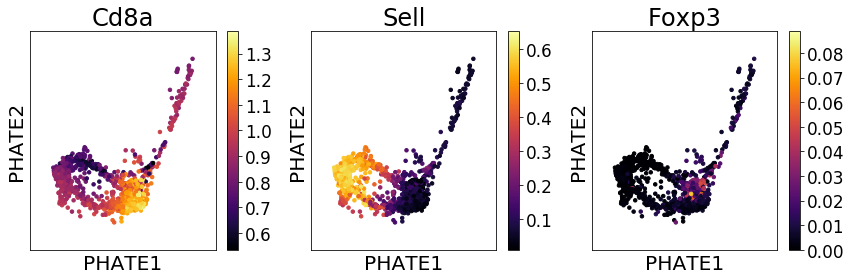

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc, ax=axes[0],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Cd8a"), title="Cd8a",
                     ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[1],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Sell"), title="Sell",
                     ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[2],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Foxp3"), title="Foxp3",
                     ticks=False, label_prefix="PHATE")

plt.tight_layout()

### Visualize distribution of expression across cells for each gene

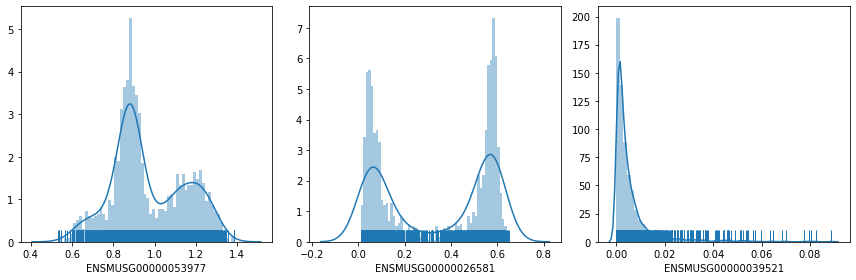

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(dataset.df[ensembl['Cd8a']], rug=True, bins=60, ax=axes[0])

sns.distplot(dataset.df[ensembl['Sell']], rug=True, bins=60, ax=axes[1])

sns.distplot(dataset.df[ensembl['Foxp3']], rug=True, bins=60, ax=axes[2])


plt.tight_layout()

## Train for Cd8a with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [14]:
gene = ensembl['Cd8a']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [15]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Cd8a
Number of first neighbors in graph 443
Number of first neighbors in graph and found in dataset 308


In [16]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

Early stopping metric is mean_squared_error


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.5209
  batch (10/652), train loss:0.6070
  batch (20/652), train loss:0.5239
  batch (30/652), train loss:0.5556
  batch (40/652), train loss:0.5243
  batch (50/652), train loss:0.6081
  batch (60/652), train loss:0.5437
  batch (70/652), train loss:0.5719
  batch (80/652), train loss:0.6263
  batch (90/652), train loss:0.5062
  batch (100/652), train loss:0.5117
  batch (110/652), train loss:0.6150
  batch (120/652), train loss:0.6242
  batch (130/652), train loss:0.5179
  batch (140/652), train loss:0.5956
  batch (150/652), train loss:0.5464
  batch (160/652), train loss:0.5345
  batch (170/652), train loss:0.6169
  batch (180/652), train loss:0.6933
  batch (190/652), train loss:0.4972
  batch (200/652), train loss:0.5202
  batch (210/652), train loss:0.5105
  batch (220/652), train loss:0.6120
  batch (230/652), train loss:0.5936
  batch (240/652), train loss:0.5761
  batch (250/652), train loss:0.5671
  batch (260/652), train loss:0.5622
  batch (270

  batch (30/652), train loss:0.2637
  batch (40/652), train loss:0.2410
  batch (50/652), train loss:0.2968
  batch (60/652), train loss:0.2503
  batch (70/652), train loss:0.2687
  batch (80/652), train loss:0.3078
  batch (90/652), train loss:0.2237
  batch (100/652), train loss:0.2240
  batch (110/652), train loss:0.2859
  batch (120/652), train loss:0.2908
  batch (130/652), train loss:0.2266
  batch (140/652), train loss:0.2716
  batch (150/652), train loss:0.2399
  batch (160/652), train loss:0.2313
  batch (170/652), train loss:0.2823
  batch (180/652), train loss:0.3319
  batch (190/652), train loss:0.2074
  batch (200/652), train loss:0.2170
  batch (210/652), train loss:0.2052
  batch (220/652), train loss:0.2641
  batch (230/652), train loss:0.2448
  batch (240/652), train loss:0.2421
  batch (250/652), train loss:0.2335
  batch (260/652), train loss:0.2227
  batch (270/652), train loss:0.2487
  batch (280/652), train loss:0.1734
  batch (290/652), train loss:0.3023
  batch 

  batch (140/652), train loss:0.0042
  batch (150/652), train loss:0.0053
  batch (160/652), train loss:0.0080
  batch (170/652), train loss:0.0086
  batch (180/652), train loss:0.0103
  batch (190/652), train loss:0.0049
  batch (200/652), train loss:0.0093
  batch (210/652), train loss:0.0041
  batch (220/652), train loss:0.0068
  batch (230/652), train loss:0.0024
  batch (240/652), train loss:0.0033
  batch (250/652), train loss:0.0031
  batch (260/652), train loss:0.0027
  batch (270/652), train loss:0.0060
  batch (280/652), train loss:0.0126
  batch (290/652), train loss:0.0073
  batch (300/652), train loss:0.0060
  batch (310/652), train loss:0.0030
  batch (320/652), train loss:0.0027
  batch (330/652), train loss:0.0058
  batch (340/652), train loss:0.0078
  batch (350/652), train loss:0.0050
  batch (360/652), train loss:0.0040
  batch (370/652), train loss:0.0122
  batch (380/652), train loss:0.0036
  batch (390/652), train loss:0.0094
  batch (400/652), train loss:0.0049
 

  batch (240/652), train loss:0.0021
  batch (250/652), train loss:0.0025
  batch (260/652), train loss:0.0020
  batch (270/652), train loss:0.0041
  batch (280/652), train loss:0.0110
  batch (290/652), train loss:0.0051
  batch (300/652), train loss:0.0051
  batch (310/652), train loss:0.0020
  batch (320/652), train loss:0.0017
  batch (330/652), train loss:0.0047
  batch (340/652), train loss:0.0058
  batch (350/652), train loss:0.0038
  batch (360/652), train loss:0.0033
  batch (370/652), train loss:0.0111
  batch (380/652), train loss:0.0030
  batch (390/652), train loss:0.0074
  batch (400/652), train loss:0.0030
  batch (410/652), train loss:0.0050
  batch (420/652), train loss:0.0032
  batch (430/652), train loss:0.0073
  batch (440/652), train loss:0.0052
  batch (450/652), train loss:0.0059
  batch (460/652), train loss:0.0042
  batch (470/652), train loss:0.0015
  batch (480/652), train loss:0.0063
  batch (490/652), train loss:0.0040
  batch (500/652), train loss:0.0027
 

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


  batch (340/652), train loss:0.0045
  batch (350/652), train loss:0.0029
  batch (360/652), train loss:0.0022
  batch (370/652), train loss:0.0078
  batch (380/652), train loss:0.0020
  batch (390/652), train loss:0.0048
  batch (400/652), train loss:0.0014
  batch (410/652), train loss:0.0034
  batch (420/652), train loss:0.0020
  batch (430/652), train loss:0.0047
  batch (440/652), train loss:0.0035
  batch (450/652), train loss:0.0041
  batch (460/652), train loss:0.0025
  batch (470/652), train loss:0.0008
  batch (480/652), train loss:0.0040
  batch (490/652), train loss:0.0029
  batch (500/652), train loss:0.0020
  batch (510/652), train loss:0.0019
  batch (520/652), train loss:0.0041
  batch (530/652), train loss:0.0064
  batch (540/652), train loss:0.0053
  batch (550/652), train loss:0.0014
  batch (560/652), train loss:0.0045
  batch (570/652), train loss:0.0018
  batch (580/652), train loss:0.0008
  batch (590/652), train loss:0.0042
  batch (600/652), train loss:0.0004
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4552
  batch (10/652), train loss:0.3998
  batch (20/652), train loss:0.3420
  batch (30/652), train loss:0.4609
  batch (40/652), train loss:0.2916
  batch (50/652), train loss:0.3287
  batch (60/652), train loss:0.3150
  batch (70/652), train loss:0.3187
  batch (80/652), train loss:0.4555
  batch (90/652), train loss:0.3741
  batch (100/652), train loss:0.3741
  batch (110/652), train loss:0.3431
  batch (120/652), train loss:0.4597
  batch (130/652), train loss:0.4581
  batch (140/652), train loss:0.3375
  batch (150/652), train loss:0.2960
  batch (160/652), train loss:0.2927
  batch (170/652), train loss:0.4028
  batch (180/652), train loss:0.4145
  batch (190/652), train loss:0.3596
  batch (200/652), train loss:0.3839
  batch (210/652), train loss:0.3602
  batch (220/652), train loss:0.3377
  batch (230/652), train loss:0.3227
  batch (240/652), train loss:0.3334
  batch (250/652), train loss:0.3217
  batch (260/652), train loss:0.3598
  batch (270

  batch (120/652), train loss:0.0569
  batch (130/652), train loss:0.0627
  batch (140/652), train loss:0.0315
  batch (150/652), train loss:0.0201
  batch (160/652), train loss:0.0214
  batch (170/652), train loss:0.0454
  batch (180/652), train loss:0.0468
  batch (190/652), train loss:0.0343
  batch (200/652), train loss:0.0412
  batch (210/652), train loss:0.0335
  batch (220/652), train loss:0.0259
  batch (230/652), train loss:0.0255
  batch (240/652), train loss:0.0279
  batch (250/652), train loss:0.0261
  batch (260/652), train loss:0.0375
  batch (270/652), train loss:0.0293
  batch (280/652), train loss:0.0447
  batch (290/652), train loss:0.0182
  batch (300/652), train loss:0.0399
  batch (310/652), train loss:0.0126
  batch (320/652), train loss:0.0250
  batch (330/652), train loss:0.0095
  batch (340/652), train loss:0.0256
  batch (350/652), train loss:0.0306
  batch (360/652), train loss:0.0296
  batch (370/652), train loss:0.0149
  batch (380/652), train loss:0.0191
 

  batch (250/652), train loss:0.0023
  batch (260/652), train loss:0.0115
  batch (270/652), train loss:0.0094
  batch (280/652), train loss:0.0076
  batch (290/652), train loss:0.0031
  batch (300/652), train loss:0.0063
  batch (310/652), train loss:0.0041
  batch (320/652), train loss:0.0048
  batch (330/652), train loss:0.0066
  batch (340/652), train loss:0.0050
  batch (350/652), train loss:0.0016
  batch (360/652), train loss:0.0112
  batch (370/652), train loss:0.0045
  batch (380/652), train loss:0.0033
  batch (390/652), train loss:0.0133
  batch (400/652), train loss:0.0054
  batch (410/652), train loss:0.0082
  batch (420/652), train loss:0.0065
  batch (430/652), train loss:0.0029
  batch (440/652), train loss:0.0071
  batch (450/652), train loss:0.0061
  batch (460/652), train loss:0.0023
  batch (470/652), train loss:0.0077
  batch (480/652), train loss:0.0052
  batch (490/652), train loss:0.0060
  batch (500/652), train loss:0.0048
  batch (510/652), train loss:0.0072
 

  batch (360/652), train loss:0.0073
  batch (370/652), train loss:0.0034
  batch (380/652), train loss:0.0022
  batch (390/652), train loss:0.0092
  batch (400/652), train loss:0.0035
  batch (410/652), train loss:0.0054
  batch (420/652), train loss:0.0045
  batch (430/652), train loss:0.0019
  batch (440/652), train loss:0.0046
  batch (450/652), train loss:0.0036
  batch (460/652), train loss:0.0017
  batch (470/652), train loss:0.0053
  batch (480/652), train loss:0.0032
  batch (490/652), train loss:0.0040
  batch (500/652), train loss:0.0032
  batch (510/652), train loss:0.0051
  batch (520/652), train loss:0.0064
  batch (530/652), train loss:0.0075
  batch (540/652), train loss:0.0037
  batch (550/652), train loss:0.0030
  batch (560/652), train loss:0.0022
  batch (570/652), train loss:0.0049
  batch (580/652), train loss:0.0082
  batch (590/652), train loss:0.0040
  batch (600/652), train loss:0.0058
  batch (610/652), train loss:0.0041
  batch (620/652), train loss:0.0051
 

  batch (540/652), train loss:0.0018
  batch (550/652), train loss:0.0014
  batch (560/652), train loss:0.0009
  batch (570/652), train loss:0.0026
  batch (580/652), train loss:0.0053
  batch (590/652), train loss:0.0019
  batch (600/652), train loss:0.0032
  batch (610/652), train loss:0.0022
  batch (620/652), train loss:0.0027
  batch (630/652), train loss:0.0008
  batch (640/652), train loss:0.0018
  batch (650/652), train loss:0.0136
total train time:1.65 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3680
  batch (10/652), train loss:0.3981
  batch (20/652), train loss:0.4786
  batch (30/652), train loss:0.3109
  batch (40/652), train loss:0.3915
  batch (50/652), train loss:0.4934
  batch (60/652), train loss:0.3911
  batch (70/652), train loss:0.3794
  batch (80/652), train loss:0.3825
  batch (90/652), train loss:0.4117
  batch (100/652), train loss:0.2998
  batch (110/652), train loss:0.3410
  batch (120/652), train loss:0.3703
  batch (130/652), train loss:0.2965
  batch (140/652), train loss:0.4064
  batch (150/652), train loss:0.3976
  batch (160/652), train loss:0.3892
  batch (170/652), train loss:0.4124
  batch (180/652), train loss:0.2878
  batch (190/652), train loss:0.3747
  batch (200/652), train loss:0.3506
  batch (210/652), train loss:0.3152
  batch (220/652), train loss:0.2599
  batch (230/652), train loss:0.3719
  batch (240/652), train loss:0.3113
  batch (250/652), train loss:0.3855
  batch (260/652), train loss:0.3166
  batch (270

  batch (200/652), train loss:0.0311
  batch (210/652), train loss:0.0261
  batch (220/652), train loss:0.0091
  batch (230/652), train loss:0.0447
  batch (240/652), train loss:0.0269
  batch (250/652), train loss:0.0436
  batch (260/652), train loss:0.0258
  batch (270/652), train loss:0.0250
  batch (280/652), train loss:0.0208
  batch (290/652), train loss:0.0343
  batch (300/652), train loss:0.0258
  batch (310/652), train loss:0.0189
  batch (320/652), train loss:0.0343
  batch (330/652), train loss:0.0369
  batch (340/652), train loss:0.0155
  batch (350/652), train loss:0.0201
  batch (360/652), train loss:0.0388
  batch (370/652), train loss:0.0519
  batch (380/652), train loss:0.0362
  batch (390/652), train loss:0.0277
  batch (400/652), train loss:0.0336
  batch (410/652), train loss:0.0279
  batch (420/652), train loss:0.0203
  batch (430/652), train loss:0.0199
  batch (440/652), train loss:0.0209
  batch (450/652), train loss:0.0133
  batch (460/652), train loss:0.0155
 

  batch (320/652), train loss:0.0081
  batch (330/652), train loss:0.0096
  batch (340/652), train loss:0.0035
  batch (350/652), train loss:0.0040
  batch (360/652), train loss:0.0090
  batch (370/652), train loss:0.0095
  batch (380/652), train loss:0.0061
  batch (390/652), train loss:0.0023
  batch (400/652), train loss:0.0057
  batch (410/652), train loss:0.0160
  batch (420/652), train loss:0.0039
  batch (430/652), train loss:0.0044
  batch (440/652), train loss:0.0071
  batch (450/652), train loss:0.0092
  batch (460/652), train loss:0.0046
  batch (470/652), train loss:0.0012
  batch (480/652), train loss:0.0110
  batch (490/652), train loss:0.0068
  batch (500/652), train loss:0.0070
  batch (510/652), train loss:0.0080
  batch (520/652), train loss:0.0077
  batch (530/652), train loss:0.0020
  batch (540/652), train loss:0.0043
  batch (550/652), train loss:0.0053
  batch (560/652), train loss:0.0216
  batch (570/652), train loss:0.0102
  batch (580/652), train loss:0.0088
 

  batch (470/652), train loss:0.0010
  batch (480/652), train loss:0.0085
  batch (490/652), train loss:0.0049
  batch (500/652), train loss:0.0050
  batch (510/652), train loss:0.0062
  batch (520/652), train loss:0.0052
  batch (530/652), train loss:0.0012
  batch (540/652), train loss:0.0023
  batch (550/652), train loss:0.0036
  batch (560/652), train loss:0.0156
  batch (570/652), train loss:0.0072
  batch (580/652), train loss:0.0057
  batch (590/652), train loss:0.0054
  batch (600/652), train loss:0.0070
  batch (610/652), train loss:0.0058
  batch (620/652), train loss:0.0028
  batch (630/652), train loss:0.0051
  batch (640/652), train loss:0.0105
  batch (650/652), train loss:0.0004
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
  batch (0/652), train loss:0.0035
  batch (10/652), train loss:0.0012
  batch (20/652), train loss:0.0045
  batch (30/652), train loss:0.0007
  batch (40/652), train loss:0.0016
  batch (50/652), train loss:0.0067
  batch (60/652), tr

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3247
  batch (10/652), train loss:0.3487
  batch (20/652), train loss:0.3775
  batch (30/652), train loss:0.2625
  batch (40/652), train loss:0.4735
  batch (50/652), train loss:0.4307
  batch (60/652), train loss:0.3925
  batch (70/652), train loss:0.3157
  batch (80/652), train loss:0.4741
  batch (90/652), train loss:0.3911
  batch (100/652), train loss:0.3413
  batch (110/652), train loss:0.3137
  batch (120/652), train loss:0.2666
  batch (130/652), train loss:0.2920
  batch (140/652), train loss:0.4256
  batch (150/652), train loss:0.3901
  batch (160/652), train loss:0.3453
  batch (170/652), train loss:0.3084
  batch (180/652), train loss:0.4003
  batch (190/652), train loss:0.4122
  batch (200/652), train loss:0.2762
  batch (210/652), train loss:0.4093
  batch (220/652), train loss:0.2941
  batch (230/652), train loss:0.3686
  batch (240/652), train loss:0.3556
  batch (250/652), train loss:0.2900
  batch (260/652), train loss:0.3210
  batch (270

  batch (530/652), train loss:0.0324
  batch (540/652), train loss:0.0168
  batch (550/652), train loss:0.0298
  batch (560/652), train loss:0.0138
  batch (570/652), train loss:0.0298
  batch (580/652), train loss:0.0283
  batch (590/652), train loss:0.0198
  batch (600/652), train loss:0.0151
  batch (610/652), train loss:0.0199
  batch (620/652), train loss:0.0180
  batch (630/652), train loss:0.0078
  batch (640/652), train loss:0.0083
  batch (650/652), train loss:0.0029
epoch: 4, time: 0.01, valid_metric: 0.18, train_metric: 0.18
  batch (0/652), train loss:0.0094
  batch (10/652), train loss:0.0106
  batch (20/652), train loss:0.0170
  batch (30/652), train loss:0.0034
  batch (40/652), train loss:0.0216
  batch (50/652), train loss:0.0166
  batch (60/652), train loss:0.0153
  batch (70/652), train loss:0.0053
  batch (80/652), train loss:0.0251
  batch (90/652), train loss:0.0127
  batch (100/652), train loss:0.0100
  batch (110/652), train loss:0.0062
  batch (120/652), train 

epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.12
  batch (0/652), train loss:0.0061
  batch (10/652), train loss:0.0067
  batch (20/652), train loss:0.0097
  batch (30/652), train loss:0.0081
  batch (40/652), train loss:0.0059
  batch (50/652), train loss:0.0031
  batch (60/652), train loss:0.0046
  batch (70/652), train loss:0.0034
  batch (80/652), train loss:0.0066
  batch (90/652), train loss:0.0036
  batch (100/652), train loss:0.0057
  batch (110/652), train loss:0.0042
  batch (120/652), train loss:0.0131
  batch (130/652), train loss:0.0098
  batch (140/652), train loss:0.0112
  batch (150/652), train loss:0.0121
  batch (160/652), train loss:0.0114
  batch (170/652), train loss:0.0036
  batch (180/652), train loss:0.0055
  batch (190/652), train loss:0.0062
  batch (200/652), train loss:0.0073
  batch (210/652), train loss:0.0073
  batch (220/652), train loss:0.0049
  batch (230/652), train loss:0.0089
  batch (240/652), train loss:0.0097
  batch (250/652), train 

  batch (440/652), train loss:0.0053
  batch (450/652), train loss:0.0039
  batch (460/652), train loss:0.0036
  batch (470/652), train loss:0.0037
  batch (480/652), train loss:0.0034
  batch (490/652), train loss:0.0064
  batch (500/652), train loss:0.0026
  batch (510/652), train loss:0.0048
  batch (520/652), train loss:0.0015
  batch (530/652), train loss:0.0049
  batch (540/652), train loss:0.0054
  batch (550/652), train loss:0.0068
  batch (560/652), train loss:0.0029
  batch (570/652), train loss:0.0037
  batch (580/652), train loss:0.0058
  batch (590/652), train loss:0.0052
  batch (600/652), train loss:0.0041
  batch (610/652), train loss:0.0034
  batch (620/652), train loss:0.0027
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0021
  batch (650/652), train loss:0.0099
epoch: 13, time: 0.01, valid_metric: 0.09, train_metric: 0.09
  batch (0/652), train loss:0.0039
  batch (10/652), train loss:0.0046
  batch (20/652), train loss:0.0059
  batch (30/652),

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3882
  batch (10/652), train loss:0.4677
  batch (20/652), train loss:0.4503
  batch (30/652), train loss:0.4467
  batch (40/652), train loss:0.3284
  batch (50/652), train loss:0.4372
  batch (60/652), train loss:0.4203
  batch (70/652), train loss:0.3362
  batch (80/652), train loss:0.3521
  batch (90/652), train loss:0.4713
  batch (100/652), train loss:0.4064
  batch (110/652), train loss:0.4131
  batch (120/652), train loss:0.3091
  batch (130/652), train loss:0.3500
  batch (140/652), train loss:0.3914
  batch (150/652), train loss:0.4000
  batch (160/652), train loss:0.3571
  batch (170/652), train loss:0.3701
  batch (180/652), train loss:0.3392
  batch (190/652), train loss:0.2608
  batch (200/652), train loss:0.3372
  batch (210/652), train loss:0.2916
  batch (220/652), train loss:0.3441
  batch (230/652), train loss:0.3023
  batch (240/652), train loss:0.3423
  batch (250/652), train loss:0.3228
  batch (260/652), train loss:0.3317
  batch (270

  batch (230/652), train loss:0.0230
  batch (240/652), train loss:0.0291
  batch (250/652), train loss:0.0299
  batch (260/652), train loss:0.0356
  batch (270/652), train loss:0.0238
  batch (280/652), train loss:0.0451
  batch (290/652), train loss:0.0203
  batch (300/652), train loss:0.0296
  batch (310/652), train loss:0.0271
  batch (320/652), train loss:0.0276
  batch (330/652), train loss:0.0264
  batch (340/652), train loss:0.0396
  batch (350/652), train loss:0.0138
  batch (360/652), train loss:0.0120
  batch (370/652), train loss:0.0219
  batch (380/652), train loss:0.0292
  batch (390/652), train loss:0.0169
  batch (400/652), train loss:0.0331
  batch (410/652), train loss:0.0228
  batch (420/652), train loss:0.0235
  batch (430/652), train loss:0.0226
  batch (440/652), train loss:0.0312
  batch (450/652), train loss:0.0186
  batch (460/652), train loss:0.0339
  batch (470/652), train loss:0.0339
  batch (480/652), train loss:0.0199
  batch (490/652), train loss:0.0265
 

  batch (450/652), train loss:0.0032
  batch (460/652), train loss:0.0053
  batch (470/652), train loss:0.0065
  batch (480/652), train loss:0.0081
  batch (490/652), train loss:0.0033
  batch (500/652), train loss:0.0070
  batch (510/652), train loss:0.0061
  batch (520/652), train loss:0.0024
  batch (530/652), train loss:0.0100
  batch (540/652), train loss:0.0073
  batch (550/652), train loss:0.0007
  batch (560/652), train loss:0.0041
  batch (570/652), train loss:0.0069
  batch (580/652), train loss:0.0049
  batch (590/652), train loss:0.0020
  batch (600/652), train loss:0.0053
  batch (610/652), train loss:0.0049
  batch (620/652), train loss:0.0060
  batch (630/652), train loss:0.0029
  batch (640/652), train loss:0.0047
  batch (650/652), train loss:0.0133
epoch: 8, time: 0.01, valid_metric: 0.12, train_metric: 0.11
  batch (0/652), train loss:0.0063
  batch (10/652), train loss:0.0058
  batch (20/652), train loss:0.0046
  batch (30/652), train loss:0.0048
  batch (40/652), t

  batch (650/652), train loss:0.0085
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
  batch (0/652), train loss:0.0052
  batch (10/652), train loss:0.0040
  batch (20/652), train loss:0.0038
  batch (30/652), train loss:0.0031
  batch (40/652), train loss:0.0130
  batch (50/652), train loss:0.0073
  batch (60/652), train loss:0.0019
  batch (70/652), train loss:0.0048
  batch (80/652), train loss:0.0050
  batch (90/652), train loss:0.0076
  batch (100/652), train loss:0.0065
  batch (110/652), train loss:0.0053
  batch (120/652), train loss:0.0047
  batch (130/652), train loss:0.0019
  batch (140/652), train loss:0.0023
  batch (150/652), train loss:0.0040
  batch (160/652), train loss:0.0040
  batch (170/652), train loss:0.0033
  batch (180/652), train loss:0.0008
  batch (190/652), train loss:0.0015
  batch (200/652), train loss:0.0091
  batch (210/652), train loss:0.0047
  batch (220/652), train loss:0.0067
  batch (230/652), train loss:0.0051
  batch (240/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4545
  batch (10/652), train loss:0.4231
  batch (20/652), train loss:0.3973
  batch (30/652), train loss:0.3496
  batch (40/652), train loss:0.3895
  batch (50/652), train loss:0.3998
  batch (60/652), train loss:0.4959
  batch (70/652), train loss:0.4747
  batch (80/652), train loss:0.4099
  batch (90/652), train loss:0.3977
  batch (100/652), train loss:0.3855
  batch (110/652), train loss:0.3595
  batch (120/652), train loss:0.3525
  batch (130/652), train loss:0.4070
  batch (140/652), train loss:0.4021
  batch (150/652), train loss:0.3260
  batch (160/652), train loss:0.3021
  batch (170/652), train loss:0.3752
  batch (180/652), train loss:0.3023
  batch (190/652), train loss:0.3773
  batch (200/652), train loss:0.3720
  batch (210/652), train loss:0.3275
  batch (220/652), train loss:0.3736
  batch (230/652), train loss:0.2910
  batch (240/652), train loss:0.3309
  batch (250/652), train loss:0.3778
  batch (260/652), train loss:0.2806
  batch (270

  batch (200/652), train loss:0.0336
  batch (210/652), train loss:0.0288
  batch (220/652), train loss:0.0367
  batch (230/652), train loss:0.0196
  batch (240/652), train loss:0.0215
  batch (250/652), train loss:0.0338
  batch (260/652), train loss:0.0179
  batch (270/652), train loss:0.0319
  batch (280/652), train loss:0.0305
  batch (290/652), train loss:0.0236
  batch (300/652), train loss:0.0195
  batch (310/652), train loss:0.0249
  batch (320/652), train loss:0.0324
  batch (330/652), train loss:0.0299
  batch (340/652), train loss:0.0192
  batch (350/652), train loss:0.0488
  batch (360/652), train loss:0.0308
  batch (370/652), train loss:0.0137
  batch (380/652), train loss:0.0252
  batch (390/652), train loss:0.0306
  batch (400/652), train loss:0.0182
  batch (410/652), train loss:0.0235
  batch (420/652), train loss:0.0320
  batch (430/652), train loss:0.0218
  batch (440/652), train loss:0.0382
  batch (450/652), train loss:0.0237
  batch (460/652), train loss:0.0369
 

  batch (300/652), train loss:0.0029
  batch (310/652), train loss:0.0066
  batch (320/652), train loss:0.0083
  batch (330/652), train loss:0.0037
  batch (340/652), train loss:0.0087
  batch (350/652), train loss:0.0103
  batch (360/652), train loss:0.0050
  batch (370/652), train loss:0.0048
  batch (380/652), train loss:0.0142
  batch (390/652), train loss:0.0069
  batch (400/652), train loss:0.0076
  batch (410/652), train loss:0.0122
  batch (420/652), train loss:0.0124
  batch (430/652), train loss:0.0042
  batch (440/652), train loss:0.0116
  batch (450/652), train loss:0.0047
  batch (460/652), train loss:0.0133
  batch (470/652), train loss:0.0054
  batch (480/652), train loss:0.0015
  batch (490/652), train loss:0.0036
  batch (500/652), train loss:0.0037
  batch (510/652), train loss:0.0087
  batch (520/652), train loss:0.0104
  batch (530/652), train loss:0.0044
  batch (540/652), train loss:0.0036
  batch (550/652), train loss:0.0079
  batch (560/652), train loss:0.0117
 

  batch (490/652), train loss:0.0020
  batch (500/652), train loss:0.0032
  batch (510/652), train loss:0.0055
  batch (520/652), train loss:0.0048
  batch (530/652), train loss:0.0031
  batch (540/652), train loss:0.0027
  batch (550/652), train loss:0.0054
  batch (560/652), train loss:0.0078
  batch (570/652), train loss:0.0025
  batch (580/652), train loss:0.0055
  batch (590/652), train loss:0.0055
  batch (600/652), train loss:0.0073
  batch (610/652), train loss:0.0053
  batch (620/652), train loss:0.0049
  batch (630/652), train loss:0.0038
  batch (640/652), train loss:0.0029
  batch (650/652), train loss:0.0043
epoch: 12, time: 0.01, valid_metric: 0.09, train_metric: 0.10
  batch (0/652), train loss:0.0056
  batch (10/652), train loss:0.0031
  batch (20/652), train loss:0.0034
  batch (30/652), train loss:0.0034
  batch (40/652), train loss:0.0033
  batch (50/652), train loss:0.0027
  batch (60/652), train loss:0.0052
  batch (70/652), train loss:0.0047
  batch (80/652), trai

  batch (610/652), train loss:0.0026
  batch (620/652), train loss:0.0028
  batch (630/652), train loss:0.0021
  batch (640/652), train loss:0.0017
  batch (650/652), train loss:0.0021
total train time:1.64 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4452
  batch (10/652), train loss:0.3964
  batch (20/652), train loss:0.3655
  batch (30/652), train loss:0.3870
  batch (40/652), train loss:0.4465
  batch (50/652), train loss:0.3403
  batch (60/652), train loss:0.4715
  batch (70/652), train loss:0.4209
  batch (80/652), train loss:0.4073
  batch (90/652), train loss:0.3584
  batch (100/652), train loss:0.5093
  batch (110/652), train loss:0.4375
  batch (120/652), train loss:0.3796
  batch (130/652), train loss:0.3264
  batch (140/652), train loss:0.3899
  batch (150/652), train loss:0.3033
  batch (160/652), train loss:0.3645
  batch (170/652), train loss:0.3413
  batch (180/652), train loss:0.3239
  batch (190/652), train loss:0.3882
  batch (200/652), train loss:0.3088
  batch (210/652), train loss:0.2781
  batch (220/652), train loss:0.3415
  batch (230/652), train loss:0.3736
  batch (240/652), train loss:0.2871
  batch (250/652), train loss:0.3870
  batch (260/652), train loss:0.2909
  batch (270

  batch (160/652), train loss:0.0354
  batch (170/652), train loss:0.0304
  batch (180/652), train loss:0.0220
  batch (190/652), train loss:0.0429
  batch (200/652), train loss:0.0319
  batch (210/652), train loss:0.0156
  batch (220/652), train loss:0.0349
  batch (230/652), train loss:0.0383
  batch (240/652), train loss:0.0177
  batch (250/652), train loss:0.0375
  batch (260/652), train loss:0.0211
  batch (270/652), train loss:0.0263
  batch (280/652), train loss:0.0158
  batch (290/652), train loss:0.0172
  batch (300/652), train loss:0.0291
  batch (310/652), train loss:0.0247
  batch (320/652), train loss:0.0414
  batch (330/652), train loss:0.0272
  batch (340/652), train loss:0.0288
  batch (350/652), train loss:0.0418
  batch (360/652), train loss:0.0371
  batch (370/652), train loss:0.0269
  batch (380/652), train loss:0.0241
  batch (390/652), train loss:0.0323
  batch (400/652), train loss:0.0186
  batch (410/652), train loss:0.0320
  batch (420/652), train loss:0.0123
 

  batch (340/652), train loss:0.0028
  batch (350/652), train loss:0.0090
  batch (360/652), train loss:0.0075
  batch (370/652), train loss:0.0034
  batch (380/652), train loss:0.0034
  batch (390/652), train loss:0.0095
  batch (400/652), train loss:0.0053
  batch (410/652), train loss:0.0057
  batch (420/652), train loss:0.0069
  batch (430/652), train loss:0.0042
  batch (440/652), train loss:0.0079
  batch (450/652), train loss:0.0005
  batch (460/652), train loss:0.0046
  batch (470/652), train loss:0.0056
  batch (480/652), train loss:0.0024
  batch (490/652), train loss:0.0058
  batch (500/652), train loss:0.0099
  batch (510/652), train loss:0.0059
  batch (520/652), train loss:0.0023
  batch (530/652), train loss:0.0044
  batch (540/652), train loss:0.0030
  batch (550/652), train loss:0.0062
  batch (560/652), train loss:0.0053
  batch (570/652), train loss:0.0068
  batch (580/652), train loss:0.0166
  batch (590/652), train loss:0.0016
  batch (600/652), train loss:0.0088
 

  batch (510/652), train loss:0.0047
  batch (520/652), train loss:0.0015
  batch (530/652), train loss:0.0028
  batch (540/652), train loss:0.0024
  batch (550/652), train loss:0.0046
  batch (560/652), train loss:0.0042
  batch (570/652), train loss:0.0049
  batch (580/652), train loss:0.0131
  batch (590/652), train loss:0.0011
  batch (600/652), train loss:0.0066
  batch (610/652), train loss:0.0056
  batch (620/652), train loss:0.0031
  batch (630/652), train loss:0.0049
  batch (640/652), train loss:0.0085
  batch (650/652), train loss:0.0029
epoch: 12, time: 0.01, valid_metric: 0.11, train_metric: 0.10
  batch (0/652), train loss:0.0036
  batch (10/652), train loss:0.0032
  batch (20/652), train loss:0.0039
  batch (30/652), train loss:0.0025
  batch (40/652), train loss:0.0080
  batch (50/652), train loss:0.0027
  batch (60/652), train loss:0.0052
  batch (70/652), train loss:0.0059
  batch (80/652), train loss:0.0045
  batch (90/652), train loss:0.0018
  batch (100/652), train

  batch (360/652), train loss:0.0044
  batch (370/652), train loss:0.0020
  batch (380/652), train loss:0.0014
  batch (390/652), train loss:0.0037
  batch (400/652), train loss:0.0031
  batch (410/652), train loss:0.0025
  batch (420/652), train loss:0.0032
  batch (430/652), train loss:0.0016
  batch (440/652), train loss:0.0046
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0015
  batch (470/652), train loss:0.0032
  batch (480/652), train loss:0.0008
  batch (490/652), train loss:0.0023
  batch (500/652), train loss:0.0047
  batch (510/652), train loss:0.0031
  batch (520/652), train loss:0.0009
  batch (530/652), train loss:0.0015
  batch (540/652), train loss:0.0020
  batch (550/652), train loss:0.0028
  batch (560/652), train loss:0.0027
  batch (570/652), train loss:0.0031
  batch (580/652), train loss:0.0089
  batch (590/652), train loss:0.0007
  batch (600/652), train loss:0.0042
  batch (610/652), train loss:0.0037
  batch (620/652), train loss:0.0018
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4307
  batch (10/652), train loss:0.3648
  batch (20/652), train loss:0.4040
  batch (30/652), train loss:0.3869
  batch (40/652), train loss:0.4450
  batch (50/652), train loss:0.3807
  batch (60/652), train loss:0.3485
  batch (70/652), train loss:0.4855
  batch (80/652), train loss:0.3089
  batch (90/652), train loss:0.4313
  batch (100/652), train loss:0.3547
  batch (110/652), train loss:0.3374
  batch (120/652), train loss:0.2937
  batch (130/652), train loss:0.3833
  batch (140/652), train loss:0.3024
  batch (150/652), train loss:0.4067
  batch (160/652), train loss:0.4159
  batch (170/652), train loss:0.2938
  batch (180/652), train loss:0.3080
  batch (190/652), train loss:0.3480
  batch (200/652), train loss:0.3159
  batch (210/652), train loss:0.4194
  batch (220/652), train loss:0.3184
  batch (230/652), train loss:0.3510
  batch (240/652), train loss:0.3018
  batch (250/652), train loss:0.2967
  batch (260/652), train loss:0.3099
  batch (270

  batch (80/652), train loss:0.0216
  batch (90/652), train loss:0.0547
  batch (100/652), train loss:0.0280
  batch (110/652), train loss:0.0245
  batch (120/652), train loss:0.0196
  batch (130/652), train loss:0.0387
  batch (140/652), train loss:0.0251
  batch (150/652), train loss:0.0420
  batch (160/652), train loss:0.0460
  batch (170/652), train loss:0.0169
  batch (180/652), train loss:0.0248
  batch (190/652), train loss:0.0364
  batch (200/652), train loss:0.0251
  batch (210/652), train loss:0.0467
  batch (220/652), train loss:0.0297
  batch (230/652), train loss:0.0345
  batch (240/652), train loss:0.0287
  batch (250/652), train loss:0.0204
  batch (260/652), train loss:0.0231
  batch (270/652), train loss:0.0398
  batch (280/652), train loss:0.0317
  batch (290/652), train loss:0.0455
  batch (300/652), train loss:0.0211
  batch (310/652), train loss:0.0303
  batch (320/652), train loss:0.0363
  batch (330/652), train loss:0.0282
  batch (340/652), train loss:0.0371
  b

  batch (160/652), train loss:0.0068
  batch (170/652), train loss:0.0030
  batch (180/652), train loss:0.0061
  batch (190/652), train loss:0.0079
  batch (200/652), train loss:0.0045
  batch (210/652), train loss:0.0063
  batch (220/652), train loss:0.0056
  batch (230/652), train loss:0.0071
  batch (240/652), train loss:0.0138
  batch (250/652), train loss:0.0052
  batch (260/652), train loss:0.0019
  batch (270/652), train loss:0.0065
  batch (280/652), train loss:0.0033
  batch (290/652), train loss:0.0114
  batch (300/652), train loss:0.0043
  batch (310/652), train loss:0.0055
  batch (320/652), train loss:0.0052
  batch (330/652), train loss:0.0061
  batch (340/652), train loss:0.0057
  batch (350/652), train loss:0.0075
  batch (360/652), train loss:0.0064
  batch (370/652), train loss:0.0007
  batch (380/652), train loss:0.0082
  batch (390/652), train loss:0.0040
  batch (400/652), train loss:0.0083
  batch (410/652), train loss:0.0030
  batch (420/652), train loss:0.0144
 

  batch (360/652), train loss:0.0038
  batch (370/652), train loss:0.0005
  batch (380/652), train loss:0.0066
  batch (390/652), train loss:0.0022
  batch (400/652), train loss:0.0055
  batch (410/652), train loss:0.0016
  batch (420/652), train loss:0.0100
  batch (430/652), train loss:0.0011
  batch (440/652), train loss:0.0028
  batch (450/652), train loss:0.0066
  batch (460/652), train loss:0.0036
  batch (470/652), train loss:0.0066
  batch (480/652), train loss:0.0024
  batch (490/652), train loss:0.0032
  batch (500/652), train loss:0.0052
  batch (510/652), train loss:0.0033
  batch (520/652), train loss:0.0028
  batch (530/652), train loss:0.0062
  batch (540/652), train loss:0.0022
  batch (550/652), train loss:0.0025
  batch (560/652), train loss:0.0046
  batch (570/652), train loss:0.0034
  batch (580/652), train loss:0.0046
  batch (590/652), train loss:0.0024
  batch (600/652), train loss:0.0022
  batch (610/652), train loss:0.0026
  batch (620/652), train loss:0.0057
 

  batch (490/652), train loss:0.0011
  batch (500/652), train loss:0.0033
  batch (510/652), train loss:0.0014
  batch (520/652), train loss:0.0015
  batch (530/652), train loss:0.0036
  batch (540/652), train loss:0.0017
  batch (550/652), train loss:0.0010
  batch (560/652), train loss:0.0042
  batch (570/652), train loss:0.0015
  batch (580/652), train loss:0.0018
  batch (590/652), train loss:0.0014
  batch (600/652), train loss:0.0011
  batch (610/652), train loss:0.0015
  batch (620/652), train loss:0.0035
  batch (630/652), train loss:0.0038
  batch (640/652), train loss:0.0071
  batch (650/652), train loss:0.0001
total train time:1.65 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4557
  batch (10/652), train loss:0.3530
  batch (20/652), train loss:0.4260
  batch (30/652), train loss:0.4170
  batch (40/652), train loss:0.4568
  batch (50/652), train loss:0.3704
  batch (60/652), train loss:0.3915
  batch (70/652), train loss:0.3215
  batch (80/652), train loss:0.3148
  batch (90/652), train loss:0.3977
  batch (100/652), train loss:0.4475
  batch (110/652), train loss:0.3479
  batch (120/652), train loss:0.3979
  batch (130/652), train loss:0.4273
  batch (140/652), train loss:0.3587
  batch (150/652), train loss:0.3074
  batch (160/652), train loss:0.3662
  batch (170/652), train loss:0.3486
  batch (180/652), train loss:0.3312
  batch (190/652), train loss:0.3399
  batch (200/652), train loss:0.3083
  batch (210/652), train loss:0.2996
  batch (220/652), train loss:0.3900
  batch (230/652), train loss:0.3046
  batch (240/652), train loss:0.3664
  batch (250/652), train loss:0.3477
  batch (260/652), train loss:0.3143
  batch (270

  batch (110/652), train loss:0.0257
  batch (120/652), train loss:0.0464
  batch (130/652), train loss:0.0402
  batch (140/652), train loss:0.0299
  batch (150/652), train loss:0.0275
  batch (160/652), train loss:0.0359
  batch (170/652), train loss:0.0336
  batch (180/652), train loss:0.0314
  batch (190/652), train loss:0.0347
  batch (200/652), train loss:0.0221
  batch (210/652), train loss:0.0197
  batch (220/652), train loss:0.0428
  batch (230/652), train loss:0.0222
  batch (240/652), train loss:0.0353
  batch (250/652), train loss:0.0371
  batch (260/652), train loss:0.0245
  batch (270/652), train loss:0.0591
  batch (280/652), train loss:0.0169
  batch (290/652), train loss:0.0333
  batch (300/652), train loss:0.0296
  batch (310/652), train loss:0.0246
  batch (320/652), train loss:0.0307
  batch (330/652), train loss:0.0261
  batch (340/652), train loss:0.0181
  batch (350/652), train loss:0.0379
  batch (360/652), train loss:0.0119
  batch (370/652), train loss:0.0216
 

  batch (300/652), train loss:0.0077
  batch (310/652), train loss:0.0076
  batch (320/652), train loss:0.0067
  batch (330/652), train loss:0.0100
  batch (340/652), train loss:0.0086
  batch (350/652), train loss:0.0061
  batch (360/652), train loss:0.0062
  batch (370/652), train loss:0.0059
  batch (380/652), train loss:0.0070
  batch (390/652), train loss:0.0043
  batch (400/652), train loss:0.0084
  batch (410/652), train loss:0.0089
  batch (420/652), train loss:0.0080
  batch (430/652), train loss:0.0058
  batch (440/652), train loss:0.0057
  batch (450/652), train loss:0.0058
  batch (460/652), train loss:0.0080
  batch (470/652), train loss:0.0078
  batch (480/652), train loss:0.0092
  batch (490/652), train loss:0.0130
  batch (500/652), train loss:0.0063
  batch (510/652), train loss:0.0040
  batch (520/652), train loss:0.0021
  batch (530/652), train loss:0.0030
  batch (540/652), train loss:0.0008
  batch (550/652), train loss:0.0129
  batch (560/652), train loss:0.0070
 

  batch (500/652), train loss:0.0039
  batch (510/652), train loss:0.0027
  batch (520/652), train loss:0.0013
  batch (530/652), train loss:0.0016
  batch (540/652), train loss:0.0007
  batch (550/652), train loss:0.0093
  batch (560/652), train loss:0.0055
  batch (570/652), train loss:0.0032
  batch (580/652), train loss:0.0083
  batch (590/652), train loss:0.0035
  batch (600/652), train loss:0.0077
  batch (610/652), train loss:0.0045
  batch (620/652), train loss:0.0077
  batch (630/652), train loss:0.0046
  batch (640/652), train loss:0.0066
  batch (650/652), train loss:0.0194
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
  batch (0/652), train loss:0.0040
  batch (10/652), train loss:0.0032
  batch (20/652), train loss:0.0055
  batch (30/652), train loss:0.0038
  batch (40/652), train loss:0.0022
  batch (50/652), train loss:0.0076
  batch (60/652), train loss:0.0064
  batch (70/652), train loss:0.0017
  batch (80/652), train loss:0.0039
  batch (90/652), train

total train time:1.62 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4057
  batch (10/652), train loss:0.3676
  batch (20/652), train loss:0.4193
  batch (30/652), train loss:0.4142
  batch (40/652), train loss:0.4432
  batch (50/652), train loss:0.4555
  batch (60/652), train loss:0.5203
  batch (70/652), train loss:0.3231
  batch (80/652), train loss:0.4350
  batch (90/652), train loss:0.3085
  batch (100/652), train loss:0.3675
  batch (110/652), train loss:0.2793
  batch (120/652), train loss:0.3944
  batch (130/652), train loss:0.3475
  batch (140/652), train loss:0.3340
  batch (150/652), train loss:0.3896
  batch (160/652), train loss:0.3253
  batch (170/652), train loss:0.3923
  batch (180/652), train loss:0.3766
  batch (190/652), train loss:0.3275
  batch (200/652), train loss:0.3800
  batch (210/652), train loss:0.2908
  batch (220/652), train loss:0.3522
  batch (230/652), train loss:0.2801
  batch (240/652), train loss:0.3121
  batch (250/652), train loss:0.2913
  batch (260/652), train loss:0.3173
  batch (270

epoch: 3, time: 0.01, valid_metric: 0.30, train_metric: 0.29
  batch (0/652), train loss:0.0453
  batch (10/652), train loss:0.0374
  batch (20/652), train loss:0.0468
  batch (30/652), train loss:0.0456
  batch (40/652), train loss:0.0501
  batch (50/652), train loss:0.0532
  batch (60/652), train loss:0.0654
  batch (70/652), train loss:0.0283
  batch (80/652), train loss:0.0494
  batch (90/652), train loss:0.0215
  batch (100/652), train loss:0.0391
  batch (110/652), train loss:0.0174
  batch (120/652), train loss:0.0401
  batch (130/652), train loss:0.0273
  batch (140/652), train loss:0.0295
  batch (150/652), train loss:0.0460
  batch (160/652), train loss:0.0211
  batch (170/652), train loss:0.0387
  batch (180/652), train loss:0.0329
  batch (190/652), train loss:0.0309
  batch (200/652), train loss:0.0399
  batch (210/652), train loss:0.0180
  batch (220/652), train loss:0.0350
  batch (230/652), train loss:0.0177
  batch (240/652), train loss:0.0265
  batch (250/652), train 

  batch (60/652), train loss:0.0056
  batch (70/652), train loss:0.0039
  batch (80/652), train loss:0.0144
  batch (90/652), train loss:0.0073
  batch (100/652), train loss:0.0149
  batch (110/652), train loss:0.0076
  batch (120/652), train loss:0.0085
  batch (130/652), train loss:0.0049
  batch (140/652), train loss:0.0136
  batch (150/652), train loss:0.0079
  batch (160/652), train loss:0.0038
  batch (170/652), train loss:0.0067
  batch (180/652), train loss:0.0048
  batch (190/652), train loss:0.0045
  batch (200/652), train loss:0.0073
  batch (210/652), train loss:0.0049
  batch (220/652), train loss:0.0129
  batch (230/652), train loss:0.0038
  batch (240/652), train loss:0.0072
  batch (250/652), train loss:0.0033
  batch (260/652), train loss:0.0058
  batch (270/652), train loss:0.0062
  batch (280/652), train loss:0.0041
  batch (290/652), train loss:0.0052
  batch (300/652), train loss:0.0134
  batch (310/652), train loss:0.0079
  batch (320/652), train loss:0.0029
  bat

  batch (0/652), train loss:0.0065
  batch (10/652), train loss:0.0102
  batch (20/652), train loss:0.0063
  batch (30/652), train loss:0.0034
  batch (40/652), train loss:0.0063
  batch (50/652), train loss:0.0036
  batch (60/652), train loss:0.0040
  batch (70/652), train loss:0.0031
  batch (80/652), train loss:0.0120
  batch (90/652), train loss:0.0063
  batch (100/652), train loss:0.0109
  batch (110/652), train loss:0.0065
  batch (120/652), train loss:0.0062
  batch (130/652), train loss:0.0043
  batch (140/652), train loss:0.0106
  batch (150/652), train loss:0.0057
  batch (160/652), train loss:0.0032
  batch (170/652), train loss:0.0049
  batch (180/652), train loss:0.0033
  batch (190/652), train loss:0.0033
  batch (200/652), train loss:0.0050
  batch (210/652), train loss:0.0038
  batch (220/652), train loss:0.0103
  batch (230/652), train loss:0.0029
  batch (240/652), train loss:0.0053
  batch (250/652), train loss:0.0025
  batch (260/652), train loss:0.0042
  batch (270

  batch (20/652), train loss:0.0040
  batch (30/652), train loss:0.0017
  batch (40/652), train loss:0.0035
  batch (50/652), train loss:0.0029
  batch (60/652), train loss:0.0028
  batch (70/652), train loss:0.0018
  batch (80/652), train loss:0.0084
  batch (90/652), train loss:0.0040
  batch (100/652), train loss:0.0056
  batch (110/652), train loss:0.0039
  batch (120/652), train loss:0.0037
  batch (130/652), train loss:0.0034
  batch (140/652), train loss:0.0058
  batch (150/652), train loss:0.0033
  batch (160/652), train loss:0.0026
  batch (170/652), train loss:0.0028
  batch (180/652), train loss:0.0015
  batch (190/652), train loss:0.0020
  batch (200/652), train loss:0.0022
  batch (210/652), train loss:0.0021
  batch (220/652), train loss:0.0057
  batch (230/652), train loss:0.0018
  batch (240/652), train loss:0.0025
  batch (250/652), train loss:0.0014
  batch (260/652), train loss:0.0022
  batch (270/652), train loss:0.0022
  batch (280/652), train loss:0.0016
  batch (

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.2735
  batch (10/652), train loss:0.3440
  batch (20/652), train loss:0.3480
  batch (30/652), train loss:0.3323
  batch (40/652), train loss:0.2525
  batch (50/652), train loss:0.2222
  batch (60/652), train loss:0.1609
  batch (70/652), train loss:0.1304
  batch (80/652), train loss:0.0880
  batch (90/652), train loss:0.1059
  batch (100/652), train loss:0.0873
  batch (110/652), train loss:0.0531
  batch (120/652), train loss:0.0861
  batch (130/652), train loss:0.0413
  batch (140/652), train loss:0.0415
  batch (150/652), train loss:0.0270
  batch (160/652), train loss:0.0403
  batch (170/652), train loss:0.0236
  batch (180/652), train loss:0.0163
  batch (190/652), train loss:0.0102
  batch (200/652), train loss:0.0049
  batch (210/652), train loss:0.0230
  batch (220/652), train loss:0.0229
  batch (230/652), train loss:0.0155
  batch (240/652), train loss:0.0107
  batch (250/652), train loss:0.0063
  batch (260/652), train loss:0.0118
  batch (270

  batch (490/652), train loss:0.0025
  batch (500/652), train loss:0.0017
  batch (510/652), train loss:0.0055
  batch (520/652), train loss:0.0047
  batch (530/652), train loss:0.0015
  batch (540/652), train loss:0.0035
  batch (550/652), train loss:0.0033
  batch (560/652), train loss:0.0030
  batch (570/652), train loss:0.0015
  batch (580/652), train loss:0.0043
  batch (590/652), train loss:0.0028
  batch (600/652), train loss:0.0013
  batch (610/652), train loss:0.0031
  batch (620/652), train loss:0.0026
  batch (630/652), train loss:0.0027
  batch (640/652), train loss:0.0005
  batch (650/652), train loss:0.0124
epoch: 4, time: 0.03, valid_metric: 0.08, train_metric: 0.07
  batch (0/652), train loss:0.0011
  batch (10/652), train loss:0.0015
  batch (20/652), train loss:0.0025
  batch (30/652), train loss:0.0028
  batch (40/652), train loss:0.0013
  batch (50/652), train loss:0.0025
  batch (60/652), train loss:0.0032
  batch (70/652), train loss:0.0053
  batch (80/652), train

  batch (540/652), train loss:0.0020
  batch (550/652), train loss:0.0009
  batch (560/652), train loss:0.0011
  batch (570/652), train loss:0.0012
  batch (580/652), train loss:0.0022
  batch (590/652), train loss:0.0012
  batch (600/652), train loss:0.0010
  batch (610/652), train loss:0.0015
  batch (620/652), train loss:0.0011
  batch (630/652), train loss:0.0015
  batch (640/652), train loss:0.0004
  batch (650/652), train loss:0.0017
epoch: 9, time: 0.03, valid_metric: 0.06, train_metric: 0.05
  batch (0/652), train loss:0.0006
  batch (10/652), train loss:0.0014
  batch (20/652), train loss:0.0020
  batch (30/652), train loss:0.0016
  batch (40/652), train loss:0.0009
  batch (50/652), train loss:0.0012
  batch (60/652), train loss:0.0013
  batch (70/652), train loss:0.0019
  batch (80/652), train loss:0.0014
  batch (90/652), train loss:0.0009
  batch (100/652), train loss:0.0016
  batch (110/652), train loss:0.0018
  batch (120/652), train loss:0.0018
  batch (130/652), train 

  batch (540/652), train loss:0.0011
  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0005
  batch (570/652), train loss:0.0010
  batch (580/652), train loss:0.0010
  batch (590/652), train loss:0.0004
  batch (600/652), train loss:0.0005
  batch (610/652), train loss:0.0011
  batch (620/652), train loss:0.0004
  batch (630/652), train loss:0.0008
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0002
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0010
  batch (20/652), train loss:0.0013
  batch (30/652), train loss:0.0008
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0010
  batch (80/652), train loss:0.0007
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0007
  batch (110/652), train loss:0.0010
  batch (120/652), train loss:0.0010
  batch (130/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3244
  batch (10/652), train loss:0.3050
  batch (20/652), train loss:0.3024
  batch (30/652), train loss:0.2174
  batch (40/652), train loss:0.2257
  batch (50/652), train loss:0.1785
  batch (60/652), train loss:0.1296
  batch (70/652), train loss:0.2031
  batch (80/652), train loss:0.1674
  batch (90/652), train loss:0.0951
  batch (100/652), train loss:0.0861
  batch (110/652), train loss:0.0857
  batch (120/652), train loss:0.0631
  batch (130/652), train loss:0.0445
  batch (140/652), train loss:0.0344
  batch (150/652), train loss:0.0273
  batch (160/652), train loss:0.0085
  batch (170/652), train loss:0.0186
  batch (180/652), train loss:0.0187
  batch (190/652), train loss:0.0279
  batch (200/652), train loss:0.0119
  batch (210/652), train loss:0.0202
  batch (220/652), train loss:0.0038
  batch (230/652), train loss:0.0283
  batch (240/652), train loss:0.0097
  batch (250/652), train loss:0.0228
  batch (260/652), train loss:0.0327
  batch (270

  batch (540/652), train loss:0.0015
  batch (550/652), train loss:0.0010
  batch (560/652), train loss:0.0021
  batch (570/652), train loss:0.0023
  batch (580/652), train loss:0.0024
  batch (590/652), train loss:0.0080
  batch (600/652), train loss:0.0103
  batch (610/652), train loss:0.0015
  batch (620/652), train loss:0.0024
  batch (630/652), train loss:0.0009
  batch (640/652), train loss:0.0035
  batch (650/652), train loss:0.0024
epoch: 4, time: 0.03, valid_metric: 0.08, train_metric: 0.07
  batch (0/652), train loss:0.0024
  batch (10/652), train loss:0.0048
  batch (20/652), train loss:0.0021
  batch (30/652), train loss:0.0035
  batch (40/652), train loss:0.0018
  batch (50/652), train loss:0.0044
  batch (60/652), train loss:0.0040
  batch (70/652), train loss:0.0041
  batch (80/652), train loss:0.0023
  batch (90/652), train loss:0.0028
  batch (100/652), train loss:0.0032
  batch (110/652), train loss:0.0040
  batch (120/652), train loss:0.0029
  batch (130/652), train 

  batch (40/652), train loss:0.0008
  batch (50/652), train loss:0.0019
  batch (60/652), train loss:0.0021
  batch (70/652), train loss:0.0019
  batch (80/652), train loss:0.0007
  batch (90/652), train loss:0.0018
  batch (100/652), train loss:0.0018
  batch (110/652), train loss:0.0020
  batch (120/652), train loss:0.0015
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0020
  batch (150/652), train loss:0.0026
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0011
  batch (180/652), train loss:0.0019
  batch (190/652), train loss:0.0018
  batch (200/652), train loss:0.0033
  batch (210/652), train loss:0.0006
  batch (220/652), train loss:0.0004
  batch (230/652), train loss:0.0012
  batch (240/652), train loss:0.0013
  batch (250/652), train loss:0.0011
  batch (260/652), train loss:0.0026
  batch (270/652), train loss:0.0021
  batch (280/652), train loss:0.0011
  batch (290/652), train loss:0.0025
  batch (300/652), train loss:0.0015
  batch

  batch (10/652), train loss:0.0018
  batch (20/652), train loss:0.0010
  batch (30/652), train loss:0.0007
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0008
  batch (60/652), train loss:0.0011
  batch (70/652), train loss:0.0011
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0014
  batch (100/652), train loss:0.0010
  batch (110/652), train loss:0.0011
  batch (120/652), train loss:0.0009
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0011
  batch (150/652), train loss:0.0012
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0006
  batch (180/652), train loss:0.0010
  batch (190/652), train loss:0.0010
  batch (200/652), train loss:0.0017
  batch (210/652), train loss:0.0005
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0005
  batch (240/652), train loss:0.0006
  batch (250/652), train loss:0.0006
  batch (260/652), train loss:0.0015
  batch (270/652), train loss:0.0012
  batch (2

  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0003
  batch (490/652), train loss:0.0005
  batch (500/652), train loss:0.0005
  batch (510/652), train loss:0.0009
  batch (520/652), train loss:0.0005
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0005
  batch (550/652), train loss:0.0005
  batch (560/652), train loss:0.0010
  batch (570/652), train loss:0.0007
  batch (580/652), train loss:0.0004
  batch (590/652), train loss:0.0006
  batch (600/652), train loss:0.0014
  batch (610/652), train loss:0.0004
  batch (620/652), train loss:0.0005
  batch (630/652), train loss:0.0005
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0009
total train time:2.51 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.2783
  batch (10/652), train loss:0.3373
  batch (20/652), train loss:0.3168
  batch (30/652), train loss:0.2892
  batch (40/652), train loss:0.2110
  batch (50/652), train loss:0.1852
  batch (60/652), train loss:0.2652
  batch (70/652), train loss:0.1265
  batch (80/652), train loss:0.1199
  batch (90/652), train loss:0.0873
  batch (100/652), train loss:0.0882
  batch (110/652), train loss:0.0835
  batch (120/652), train loss:0.0600
  batch (130/652), train loss:0.0408
  batch (140/652), train loss:0.0188
  batch (150/652), train loss:0.0149
  batch (160/652), train loss:0.0224
  batch (170/652), train loss:0.0248
  batch (180/652), train loss:0.0092
  batch (190/652), train loss:0.0092
  batch (200/652), train loss:0.0104
  batch (210/652), train loss:0.0037
  batch (220/652), train loss:0.0091
  batch (230/652), train loss:0.0344
  batch (240/652), train loss:0.0247
  batch (250/652), train loss:0.0397
  batch (260/652), train loss:0.0259
  batch (270

  batch (220/652), train loss:0.0038
  batch (230/652), train loss:0.0024
  batch (240/652), train loss:0.0053
  batch (250/652), train loss:0.0045
  batch (260/652), train loss:0.0054
  batch (270/652), train loss:0.0064
  batch (280/652), train loss:0.0022
  batch (290/652), train loss:0.0067
  batch (300/652), train loss:0.0034
  batch (310/652), train loss:0.0032
  batch (320/652), train loss:0.0020
  batch (330/652), train loss:0.0012
  batch (340/652), train loss:0.0010
  batch (350/652), train loss:0.0025
  batch (360/652), train loss:0.0015
  batch (370/652), train loss:0.0022
  batch (380/652), train loss:0.0062
  batch (390/652), train loss:0.0004
  batch (400/652), train loss:0.0126
  batch (410/652), train loss:0.0051
  batch (420/652), train loss:0.0049
  batch (430/652), train loss:0.0032
  batch (440/652), train loss:0.0006
  batch (450/652), train loss:0.0038
  batch (460/652), train loss:0.0079
  batch (470/652), train loss:0.0057
  batch (480/652), train loss:0.0060
 

  batch (510/652), train loss:0.0008
  batch (520/652), train loss:0.0014
  batch (530/652), train loss:0.0006
  batch (540/652), train loss:0.0040
  batch (550/652), train loss:0.0015
  batch (560/652), train loss:0.0043
  batch (570/652), train loss:0.0011
  batch (580/652), train loss:0.0025
  batch (590/652), train loss:0.0014
  batch (600/652), train loss:0.0017
  batch (610/652), train loss:0.0020
  batch (620/652), train loss:0.0026
  batch (630/652), train loss:0.0026
  batch (640/652), train loss:0.0021
  batch (650/652), train loss:0.0004
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.06
  batch (0/652), train loss:0.0024
  batch (10/652), train loss:0.0015
  batch (20/652), train loss:0.0021
  batch (30/652), train loss:0.0011
  batch (40/652), train loss:0.0014
  batch (50/652), train loss:0.0023
  batch (60/652), train loss:0.0033
  batch (70/652), train loss:0.0009
  batch (80/652), train loss:0.0013
  batch (90/652), train loss:0.0014
  batch (100/652), train 

  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0014
  batch (60/652), train loss:0.0016
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0011
  batch (90/652), train loss:0.0008
  batch (100/652), train loss:0.0009
  batch (110/652), train loss:0.0006
  batch (120/652), train loss:0.0025
  batch (130/652), train loss:0.0010
  batch (140/652), train loss:0.0006
  batch (150/652), train loss:0.0009
  batch (160/652), train loss:0.0023
  batch (170/652), train loss:0.0018
  batch (180/652), train loss:0.0004
  batch (190/652), train loss:0.0017
  batch (200/652), train loss:0.0005
  batch (210/652), train loss:0.0005
  batch (220/652), train loss:0.0012
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0008
  batch (250/652), train loss:0.0008
  batch (260/652), train loss:0.0010
  batch (270/652), train loss:0.0013
  batch (280/652), train loss:0.0008
  batch (290/652), train loss:0.0015
  batch (300/652), train loss:0.0008
  batch

  batch (270/652), train loss:0.0008
  batch (280/652), train loss:0.0006
  batch (290/652), train loss:0.0012
  batch (300/652), train loss:0.0006
  batch (310/652), train loss:0.0015
  batch (320/652), train loss:0.0007
  batch (330/652), train loss:0.0003
  batch (340/652), train loss:0.0005
  batch (350/652), train loss:0.0006
  batch (360/652), train loss:0.0004
  batch (370/652), train loss:0.0007
  batch (380/652), train loss:0.0012
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0016
  batch (410/652), train loss:0.0002
  batch (420/652), train loss:0.0008
  batch (430/652), train loss:0.0009
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0006
  batch (460/652), train loss:0.0007
  batch (470/652), train loss:0.0010
  batch (480/652), train loss:0.0009
  batch (490/652), train loss:0.0010
  batch (500/652), train loss:0.0003
  batch (510/652), train loss:0.0004
  batch (520/652), train loss:0.0009
  batch (530/652), train loss:0.0004
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3480
  batch (10/652), train loss:0.4322
  batch (20/652), train loss:0.3019
  batch (30/652), train loss:0.3112
  batch (40/652), train loss:0.2599
  batch (50/652), train loss:0.1601
  batch (60/652), train loss:0.2694
  batch (70/652), train loss:0.1774
  batch (80/652), train loss:0.1339
  batch (90/652), train loss:0.0870
  batch (100/652), train loss:0.0940
  batch (110/652), train loss:0.0511
  batch (120/652), train loss:0.0637
  batch (130/652), train loss:0.0302
  batch (140/652), train loss:0.0415
  batch (150/652), train loss:0.0191
  batch (160/652), train loss:0.0127
  batch (170/652), train loss:0.0094
  batch (180/652), train loss:0.0130
  batch (190/652), train loss:0.0283
  batch (200/652), train loss:0.0180
  batch (210/652), train loss:0.0080
  batch (220/652), train loss:0.0137
  batch (230/652), train loss:0.0235
  batch (240/652), train loss:0.0308
  batch (250/652), train loss:0.0140
  batch (260/652), train loss:0.0496
  batch (270

epoch: 3, time: 0.03, valid_metric: 0.08, train_metric: 0.08
  batch (0/652), train loss:0.0038
  batch (10/652), train loss:0.0031
  batch (20/652), train loss:0.0042
  batch (30/652), train loss:0.0025
  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0034
  batch (60/652), train loss:0.0049
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0039
  batch (90/652), train loss:0.0053
  batch (100/652), train loss:0.0014
  batch (110/652), train loss:0.0035
  batch (120/652), train loss:0.0044
  batch (130/652), train loss:0.0032
  batch (140/652), train loss:0.0032
  batch (150/652), train loss:0.0017
  batch (160/652), train loss:0.0006
  batch (170/652), train loss:0.0019
  batch (180/652), train loss:0.0032
  batch (190/652), train loss:0.0011
  batch (200/652), train loss:0.0058
  batch (210/652), train loss:0.0034
  batch (220/652), train loss:0.0043
  batch (230/652), train loss:0.0046
  batch (240/652), train loss:0.0012
  batch (250/652), train 

  batch (240/652), train loss:0.0004
  batch (250/652), train loss:0.0004
  batch (260/652), train loss:0.0026
  batch (270/652), train loss:0.0007
  batch (280/652), train loss:0.0014
  batch (290/652), train loss:0.0024
  batch (300/652), train loss:0.0021
  batch (310/652), train loss:0.0012
  batch (320/652), train loss:0.0028
  batch (330/652), train loss:0.0044
  batch (340/652), train loss:0.0005
  batch (350/652), train loss:0.0010
  batch (360/652), train loss:0.0018
  batch (370/652), train loss:0.0006
  batch (380/652), train loss:0.0012
  batch (390/652), train loss:0.0020
  batch (400/652), train loss:0.0015
  batch (410/652), train loss:0.0027
  batch (420/652), train loss:0.0012
  batch (430/652), train loss:0.0011
  batch (440/652), train loss:0.0017
  batch (450/652), train loss:0.0014
  batch (460/652), train loss:0.0020
  batch (470/652), train loss:0.0020
  batch (480/652), train loss:0.0021
  batch (490/652), train loss:0.0007
  batch (500/652), train loss:0.0017
 

  batch (580/652), train loss:0.0006
  batch (590/652), train loss:0.0005
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0010
  batch (620/652), train loss:0.0019
  batch (630/652), train loss:0.0003
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0002
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0009
  batch (10/652), train loss:0.0005
  batch (20/652), train loss:0.0012
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0015
  batch (60/652), train loss:0.0013
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0007
  batch (90/652), train loss:0.0008
  batch (100/652), train loss:0.0004
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0014
  batch (130/652), train loss:0.0005
  batch (140/652), train loss:0.0011
  batch (150/652), train loss:0.0005
  batch (160/652), train loss:0.0004
  batch (170/652), train

  batch (510/652), train loss:0.0007
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0008
  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0005
  batch (590/652), train loss:0.0003
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0006
  batch (620/652), train loss:0.0008
  batch (630/652), train loss:0.0003
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0001
total train time:2.53 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4270
  batch (10/652), train loss:0.3732
  batch (20/652), train loss:0.3162
  batch (30/652), train loss:0.3210
  batch (40/652), train loss:0.2236
  batch (50/652), train loss:0.1899
  batch (60/652), train loss:0.1246
  batch (70/652), train loss:0.1303
  batch (80/652), train loss:0.1231
  batch (90/652), train loss:0.0887
  batch (100/652), train loss:0.0989
  batch (110/652), train loss:0.0579
  batch (120/652), train loss:0.0733
  batch (130/652), train loss:0.0351
  batch (140/652), train loss:0.0291
  batch (150/652), train loss:0.0300
  batch (160/652), train loss:0.0254
  batch (170/652), train loss:0.0137
  batch (180/652), train loss:0.0093
  batch (190/652), train loss:0.0177
  batch (200/652), train loss:0.0058
  batch (210/652), train loss:0.0038
  batch (220/652), train loss:0.0238
  batch (230/652), train loss:0.0431
  batch (240/652), train loss:0.0070
  batch (250/652), train loss:0.0121
  batch (260/652), train loss:0.0668
  batch (270

  batch (180/652), train loss:0.0025
  batch (190/652), train loss:0.0028
  batch (200/652), train loss:0.0012
  batch (210/652), train loss:0.0009
  batch (220/652), train loss:0.0027
  batch (230/652), train loss:0.0048
  batch (240/652), train loss:0.0027
  batch (250/652), train loss:0.0014
  batch (260/652), train loss:0.0084
  batch (270/652), train loss:0.0031
  batch (280/652), train loss:0.0042
  batch (290/652), train loss:0.0034
  batch (300/652), train loss:0.0066
  batch (310/652), train loss:0.0015
  batch (320/652), train loss:0.0037
  batch (330/652), train loss:0.0019
  batch (340/652), train loss:0.0022
  batch (350/652), train loss:0.0026
  batch (360/652), train loss:0.0028
  batch (370/652), train loss:0.0048
  batch (380/652), train loss:0.0036
  batch (390/652), train loss:0.0027
  batch (400/652), train loss:0.0047
  batch (410/652), train loss:0.0016
  batch (420/652), train loss:0.0033
  batch (430/652), train loss:0.0026
  batch (440/652), train loss:0.0019
 

  batch (330/652), train loss:0.0015
  batch (340/652), train loss:0.0014
  batch (350/652), train loss:0.0013
  batch (360/652), train loss:0.0021
  batch (370/652), train loss:0.0017
  batch (380/652), train loss:0.0023
  batch (390/652), train loss:0.0011
  batch (400/652), train loss:0.0025
  batch (410/652), train loss:0.0007
  batch (420/652), train loss:0.0011
  batch (430/652), train loss:0.0012
  batch (440/652), train loss:0.0010
  batch (450/652), train loss:0.0015
  batch (460/652), train loss:0.0019
  batch (470/652), train loss:0.0016
  batch (480/652), train loss:0.0011
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0011
  batch (510/652), train loss:0.0030
  batch (520/652), train loss:0.0006
  batch (530/652), train loss:0.0010
  batch (540/652), train loss:0.0004
  batch (550/652), train loss:0.0011
  batch (560/652), train loss:0.0024
  batch (570/652), train loss:0.0022
  batch (580/652), train loss:0.0014
  batch (590/652), train loss:0.0021
 

  batch (450/652), train loss:0.0010
  batch (460/652), train loss:0.0009
  batch (470/652), train loss:0.0008
  batch (480/652), train loss:0.0008
  batch (490/652), train loss:0.0005
  batch (500/652), train loss:0.0010
  batch (510/652), train loss:0.0012
  batch (520/652), train loss:0.0004
  batch (530/652), train loss:0.0006
  batch (540/652), train loss:0.0003
  batch (550/652), train loss:0.0005
  batch (560/652), train loss:0.0015
  batch (570/652), train loss:0.0018
  batch (580/652), train loss:0.0008
  batch (590/652), train loss:0.0013
  batch (600/652), train loss:0.0006
  batch (610/652), train loss:0.0008
  batch (620/652), train loss:0.0008
  batch (630/652), train loss:0.0007
  batch (640/652), train loss:0.0018
  batch (650/652), train loss:0.0002
epoch: 12, time: 0.03, valid_metric: 0.05, train_metric: 0.04
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0006
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0012
  batch (40/652), 

total train time:2.49 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.2758
  batch (10/652), train loss:0.3093
  batch (20/652), train loss:0.2628
  batch (30/652), train loss:0.3549
  batch (40/652), train loss:0.1798
  batch (50/652), train loss:0.1762
  batch (60/652), train loss:0.2983
  batch (70/652), train loss:0.1701
  batch (80/652), train loss:0.1638
  batch (90/652), train loss:0.1023
  batch (100/652), train loss:0.1028
  batch (110/652), train loss:0.0803
  batch (120/652), train loss:0.0461
  batch (130/652), train loss:0.0487
  batch (140/652), train loss:0.0290
  batch (150/652), train loss:0.0307
  batch (160/652), train loss:0.0090
  batch (170/652), train loss:0.0134
  batch (180/652), train loss:0.0167
  batch (190/652), train loss:0.0287
  batch (200/652), train loss:0.0061
  batch (210/652), train loss:0.0053
  batch (220/652), train loss:0.0114
  batch (230/652), train loss:0.0409
  batch (240/652), train loss:0.0313
  batch (250/652), train loss:0.0421
  batch (260/652), train loss:0.0051
  batch (270

  batch (470/652), train loss:0.0019
  batch (480/652), train loss:0.0010
  batch (490/652), train loss:0.0021
  batch (500/652), train loss:0.0035
  batch (510/652), train loss:0.0003
  batch (520/652), train loss:0.0023
  batch (530/652), train loss:0.0016
  batch (540/652), train loss:0.0041
  batch (550/652), train loss:0.0060
  batch (560/652), train loss:0.0016
  batch (570/652), train loss:0.0026
  batch (580/652), train loss:0.0026
  batch (590/652), train loss:0.0042
  batch (600/652), train loss:0.0009
  batch (610/652), train loss:0.0024
  batch (620/652), train loss:0.0037
  batch (630/652), train loss:0.0005
  batch (640/652), train loss:0.0019
  batch (650/652), train loss:0.0029
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.07
  batch (0/652), train loss:0.0025
  batch (10/652), train loss:0.0038
  batch (20/652), train loss:0.0022
  batch (30/652), train loss:0.0039
  batch (40/652), train loss:0.0027
  batch (50/652), train loss:0.0007
  batch (60/652), tra

  batch (200/652), train loss:0.0013
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0010
  batch (230/652), train loss:0.0007
  batch (240/652), train loss:0.0008
  batch (250/652), train loss:0.0012
  batch (260/652), train loss:0.0010
  batch (270/652), train loss:0.0013
  batch (280/652), train loss:0.0003
  batch (290/652), train loss:0.0007
  batch (300/652), train loss:0.0005
  batch (310/652), train loss:0.0007
  batch (320/652), train loss:0.0007
  batch (330/652), train loss:0.0005
  batch (340/652), train loss:0.0004
  batch (350/652), train loss:0.0006
  batch (360/652), train loss:0.0010
  batch (370/652), train loss:0.0019
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0010
  batch (400/652), train loss:0.0011
  batch (410/652), train loss:0.0011
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0008
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0007
 

  batch (440/652), train loss:0.0005
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0005
  batch (470/652), train loss:0.0004
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0004
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0005
  batch (550/652), train loss:0.0011
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0006
  batch (580/652), train loss:0.0003
  batch (590/652), train loss:0.0009
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0005
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0008
epoch: 12, time: 0.02, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0012
  batch (20/652), train loss:0.0006
  batch (30/652),

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4636
  batch (10/652), train loss:0.3682
  batch (20/652), train loss:0.3503
  batch (30/652), train loss:0.3003
  batch (40/652), train loss:0.2496
  batch (50/652), train loss:0.2131
  batch (60/652), train loss:0.2390
  batch (70/652), train loss:0.1332
  batch (80/652), train loss:0.1638
  batch (90/652), train loss:0.0956
  batch (100/652), train loss:0.1399
  batch (110/652), train loss:0.0957
  batch (120/652), train loss:0.0597
  batch (130/652), train loss:0.0389
  batch (140/652), train loss:0.0576
  batch (150/652), train loss:0.0179
  batch (160/652), train loss:0.0151
  batch (170/652), train loss:0.0154
  batch (180/652), train loss:0.0199
  batch (190/652), train loss:0.0232
  batch (200/652), train loss:0.0233
  batch (210/652), train loss:0.0177
  batch (220/652), train loss:0.0160
  batch (230/652), train loss:0.0188
  batch (240/652), train loss:0.0259
  batch (250/652), train loss:0.0143
  batch (260/652), train loss:0.0208
  batch (270

  batch (440/652), train loss:0.0034
  batch (450/652), train loss:0.0018
  batch (460/652), train loss:0.0027
  batch (470/652), train loss:0.0019
  batch (480/652), train loss:0.0024
  batch (490/652), train loss:0.0015
  batch (500/652), train loss:0.0067
  batch (510/652), train loss:0.0041
  batch (520/652), train loss:0.0017
  batch (530/652), train loss:0.0014
  batch (540/652), train loss:0.0014
  batch (550/652), train loss:0.0016
  batch (560/652), train loss:0.0041
  batch (570/652), train loss:0.0025
  batch (580/652), train loss:0.0016
  batch (590/652), train loss:0.0031
  batch (600/652), train loss:0.0014
  batch (610/652), train loss:0.0015
  batch (620/652), train loss:0.0035
  batch (630/652), train loss:0.0046
  batch (640/652), train loss:0.0029
  batch (650/652), train loss:0.0001
epoch: 4, time: 0.02, valid_metric: 0.08, train_metric: 0.07
  batch (0/652), train loss:0.0010
  batch (10/652), train loss:0.0055
  batch (20/652), train loss:0.0008
  batch (30/652), 

  batch (200/652), train loss:0.0006
  batch (210/652), train loss:0.0030
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0017
  batch (240/652), train loss:0.0011
  batch (250/652), train loss:0.0004
  batch (260/652), train loss:0.0014
  batch (270/652), train loss:0.0007
  batch (280/652), train loss:0.0010
  batch (290/652), train loss:0.0003
  batch (300/652), train loss:0.0015
  batch (310/652), train loss:0.0017
  batch (320/652), train loss:0.0024
  batch (330/652), train loss:0.0015
  batch (340/652), train loss:0.0016
  batch (350/652), train loss:0.0010
  batch (360/652), train loss:0.0008
  batch (370/652), train loss:0.0025
  batch (380/652), train loss:0.0031
  batch (390/652), train loss:0.0013
  batch (400/652), train loss:0.0015
  batch (410/652), train loss:0.0011
  batch (420/652), train loss:0.0017
  batch (430/652), train loss:0.0012
  batch (440/652), train loss:0.0018
  batch (450/652), train loss:0.0011
  batch (460/652), train loss:0.0010
 

  batch (430/652), train loss:0.0008
  batch (440/652), train loss:0.0014
  batch (450/652), train loss:0.0009
  batch (460/652), train loss:0.0009
  batch (470/652), train loss:0.0007
  batch (480/652), train loss:0.0008
  batch (490/652), train loss:0.0007
  batch (500/652), train loss:0.0017
  batch (510/652), train loss:0.0007
  batch (520/652), train loss:0.0008
  batch (530/652), train loss:0.0010
  batch (540/652), train loss:0.0003
  batch (550/652), train loss:0.0007
  batch (560/652), train loss:0.0015
  batch (570/652), train loss:0.0005
  batch (580/652), train loss:0.0004
  batch (590/652), train loss:0.0007
  batch (600/652), train loss:0.0004
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0007
  batch (630/652), train loss:0.0016
  batch (640/652), train loss:0.0008
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.02, valid_metric: 0.05, train_metric: 0.04
  batch (0/652), train loss:0.0006
  batch (10/652), train loss:0.0021
  batch (20/652)

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4734
  batch (10/652), train loss:0.4306
  batch (20/652), train loss:0.2921
  batch (30/652), train loss:0.2679
  batch (40/652), train loss:0.2071
  batch (50/652), train loss:0.2252
  batch (60/652), train loss:0.1410
  batch (70/652), train loss:0.1351
  batch (80/652), train loss:0.1493
  batch (90/652), train loss:0.1602
  batch (100/652), train loss:0.0748
  batch (110/652), train loss:0.0709
  batch (120/652), train loss:0.0426
  batch (130/652), train loss:0.0177
  batch (140/652), train loss:0.0313
  batch (150/652), train loss:0.0286
  batch (160/652), train loss:0.0158
  batch (170/652), train loss:0.0181
  batch (180/652), train loss:0.0169
  batch (190/652), train loss:0.0307
  batch (200/652), train loss:0.0096
  batch (210/652), train loss:0.0065
  batch (220/652), train loss:0.0050
  batch (230/652), train loss:0.0158
  batch (240/652), train loss:0.0391
  batch (250/652), train loss:0.0298
  batch (260/652), train loss:0.0315
  batch (270

  batch (10/652), train loss:0.0061
  batch (20/652), train loss:0.0035
  batch (30/652), train loss:0.0010
  batch (40/652), train loss:0.0106
  batch (50/652), train loss:0.0010
  batch (60/652), train loss:0.0051
  batch (70/652), train loss:0.0019
  batch (80/652), train loss:0.0009
  batch (90/652), train loss:0.0009
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0071
  batch (120/652), train loss:0.0021
  batch (130/652), train loss:0.0017
  batch (140/652), train loss:0.0029
  batch (150/652), train loss:0.0040
  batch (160/652), train loss:0.0068
  batch (170/652), train loss:0.0033
  batch (180/652), train loss:0.0030
  batch (190/652), train loss:0.0066
  batch (200/652), train loss:0.0033
  batch (210/652), train loss:0.0039
  batch (220/652), train loss:0.0016
  batch (230/652), train loss:0.0047
  batch (240/652), train loss:0.0045
  batch (250/652), train loss:0.0019
  batch (260/652), train loss:0.0020
  batch (270/652), train loss:0.0096
  batch (2

  batch (80/652), train loss:0.0008
  batch (90/652), train loss:0.0006
  batch (100/652), train loss:0.0005
  batch (110/652), train loss:0.0038
  batch (120/652), train loss:0.0009
  batch (130/652), train loss:0.0009
  batch (140/652), train loss:0.0024
  batch (150/652), train loss:0.0022
  batch (160/652), train loss:0.0031
  batch (170/652), train loss:0.0014
  batch (180/652), train loss:0.0011
  batch (190/652), train loss:0.0033
  batch (200/652), train loss:0.0021
  batch (210/652), train loss:0.0018
  batch (220/652), train loss:0.0010
  batch (230/652), train loss:0.0030
  batch (240/652), train loss:0.0025
  batch (250/652), train loss:0.0017
  batch (260/652), train loss:0.0010
  batch (270/652), train loss:0.0052
  batch (280/652), train loss:0.0022
  batch (290/652), train loss:0.0035
  batch (300/652), train loss:0.0024
  batch (310/652), train loss:0.0031
  batch (320/652), train loss:0.0020
  batch (330/652), train loss:0.0021
  batch (340/652), train loss:0.0012
  b

epoch: 12, time: 0.02, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0008
  batch (10/652), train loss:0.0015
  batch (20/652), train loss:0.0012
  batch (30/652), train loss:0.0008
  batch (40/652), train loss:0.0013
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0007
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0006
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0019
  batch (120/652), train loss:0.0005
  batch (130/652), train loss:0.0005
  batch (140/652), train loss:0.0014
  batch (150/652), train loss:0.0008
  batch (160/652), train loss:0.0010
  batch (170/652), train loss:0.0007
  batch (180/652), train loss:0.0007
  batch (190/652), train loss:0.0013
  batch (200/652), train loss:0.0014
  batch (210/652), train loss:0.0010
  batch (220/652), train loss:0.0007
  batch (230/652), train loss:0.0013
  batch (240/652), train loss:0.0009
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3798
  batch (10/652), train loss:0.3461
  batch (20/652), train loss:0.2723
  batch (30/652), train loss:0.3369
  batch (40/652), train loss:0.2905
  batch (50/652), train loss:0.1408
  batch (60/652), train loss:0.1894
  batch (70/652), train loss:0.2007
  batch (80/652), train loss:0.0832
  batch (90/652), train loss:0.1420
  batch (100/652), train loss:0.0877
  batch (110/652), train loss:0.0472
  batch (120/652), train loss:0.0437
  batch (130/652), train loss:0.0559
  batch (140/652), train loss:0.0213
  batch (150/652), train loss:0.0149
  batch (160/652), train loss:0.0168
  batch (170/652), train loss:0.0229
  batch (180/652), train loss:0.0156
  batch (190/652), train loss:0.0230
  batch (200/652), train loss:0.0064
  batch (210/652), train loss:0.0371
  batch (220/652), train loss:0.0130
  batch (230/652), train loss:0.0328
  batch (240/652), train loss:0.0095
  batch (250/652), train loss:0.0079
  batch (260/652), train loss:0.0436
  batch (270

  batch (180/652), train loss:0.0085
  batch (190/652), train loss:0.0030
  batch (200/652), train loss:0.0023
  batch (210/652), train loss:0.0072
  batch (220/652), train loss:0.0050
  batch (230/652), train loss:0.0021
  batch (240/652), train loss:0.0029
  batch (250/652), train loss:0.0007
  batch (260/652), train loss:0.0044
  batch (270/652), train loss:0.0030
  batch (280/652), train loss:0.0060
  batch (290/652), train loss:0.0032
  batch (300/652), train loss:0.0022
  batch (310/652), train loss:0.0043
  batch (320/652), train loss:0.0033
  batch (330/652), train loss:0.0049
  batch (340/652), train loss:0.0013
  batch (350/652), train loss:0.0047
  batch (360/652), train loss:0.0007
  batch (370/652), train loss:0.0010
  batch (380/652), train loss:0.0039
  batch (390/652), train loss:0.0008
  batch (400/652), train loss:0.0018
  batch (410/652), train loss:0.0016
  batch (420/652), train loss:0.0028
  batch (430/652), train loss:0.0050
  batch (440/652), train loss:0.0044
 

  batch (380/652), train loss:0.0013
  batch (390/652), train loss:0.0007
  batch (400/652), train loss:0.0008
  batch (410/652), train loss:0.0009
  batch (420/652), train loss:0.0007
  batch (430/652), train loss:0.0018
  batch (440/652), train loss:0.0009
  batch (450/652), train loss:0.0006
  batch (460/652), train loss:0.0007
  batch (470/652), train loss:0.0009
  batch (480/652), train loss:0.0008
  batch (490/652), train loss:0.0010
  batch (500/652), train loss:0.0005
  batch (510/652), train loss:0.0010
  batch (520/652), train loss:0.0009
  batch (530/652), train loss:0.0011
  batch (540/652), train loss:0.0008
  batch (550/652), train loss:0.0011
  batch (560/652), train loss:0.0016
  batch (570/652), train loss:0.0007
  batch (580/652), train loss:0.0005
  batch (590/652), train loss:0.0013
  batch (600/652), train loss:0.0008
  batch (610/652), train loss:0.0016
  batch (620/652), train loss:0.0006
  batch (630/652), train loss:0.0011
  batch (640/652), train loss:0.0011
 

epoch: 11, time: 0.03, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0005
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0008
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0006
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0006
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0007
  batch (180/652), train loss:0.0008
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0009
  batch (210/652), train loss:0.0005
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0005
  batch (250/652), train

  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0004
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0005
  batch (520/652), train loss:0.0006
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0004
  batch (560/652), train loss:0.0003
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0004
  batch (600/652), train loss:0.0003
  batch (610/652), train loss:0.0006
  batch (620/652), train loss:0.0003
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0005
  batch (650/652), train loss:0.0001
total train time:2.31 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3860
  batch (10/652), train loss:0.2004
  batch (20/652), train loss:0.3277
  batch (30/652), train loss:0.2631
  batch (40/652), train loss:0.3169
  batch (50/652), train loss:0.2635
  batch (60/652), train loss:0.2041
  batch (70/652), train loss:0.1610
  batch (80/652), train loss:0.1396
  batch (90/652), train loss:0.0972
  batch (100/652), train loss:0.0668
  batch (110/652), train loss:0.0654
  batch (120/652), train loss:0.0543
  batch (130/652), train loss:0.0327
  batch (140/652), train loss:0.0476
  batch (150/652), train loss:0.0371
  batch (160/652), train loss:0.0105
  batch (170/652), train loss:0.0217
  batch (180/652), train loss:0.0024
  batch (190/652), train loss:0.0087
  batch (200/652), train loss:0.0304
  batch (210/652), train loss:0.0226
  batch (220/652), train loss:0.0166
  batch (230/652), train loss:0.0141
  batch (240/652), train loss:0.0137
  batch (250/652), train loss:0.0308
  batch (260/652), train loss:0.0166
  batch (270

  batch (440/652), train loss:0.0016
  batch (450/652), train loss:0.0047
  batch (460/652), train loss:0.0011
  batch (470/652), train loss:0.0011
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0025
  batch (500/652), train loss:0.0040
  batch (510/652), train loss:0.0026
  batch (520/652), train loss:0.0039
  batch (530/652), train loss:0.0055
  batch (540/652), train loss:0.0044
  batch (550/652), train loss:0.0029
  batch (560/652), train loss:0.0037
  batch (570/652), train loss:0.0022
  batch (580/652), train loss:0.0020
  batch (590/652), train loss:0.0032
  batch (600/652), train loss:0.0012
  batch (610/652), train loss:0.0012
  batch (620/652), train loss:0.0022
  batch (630/652), train loss:0.0021
  batch (640/652), train loss:0.0031
  batch (650/652), train loss:0.0014
epoch: 4, time: 0.02, valid_metric: 0.08, train_metric: 0.07
  batch (0/652), train loss:0.0035
  batch (10/652), train loss:0.0045
  batch (20/652), train loss:0.0014
  batch (30/652), 

epoch: 7, time: 0.02, valid_metric: 0.05, train_metric: 0.05
  batch (0/652), train loss:0.0017
  batch (10/652), train loss:0.0014
  batch (20/652), train loss:0.0008
  batch (30/652), train loss:0.0011
  batch (40/652), train loss:0.0032
  batch (50/652), train loss:0.0016
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0018
  batch (80/652), train loss:0.0018
  batch (90/652), train loss:0.0022
  batch (100/652), train loss:0.0009
  batch (110/652), train loss:0.0015
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0009
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0013
  batch (160/652), train loss:0.0009
  batch (170/652), train loss:0.0013
  batch (180/652), train loss:0.0010
  batch (190/652), train loss:0.0017
  batch (200/652), train loss:0.0008
  batch (210/652), train loss:0.0017
  batch (220/652), train loss:0.0014
  batch (230/652), train loss:0.0012
  batch (240/652), train loss:0.0005
  batch (250/652), train 

  batch (250/652), train loss:0.0007
  batch (260/652), train loss:0.0006
  batch (270/652), train loss:0.0010
  batch (280/652), train loss:0.0002
  batch (290/652), train loss:0.0003
  batch (300/652), train loss:0.0007
  batch (310/652), train loss:0.0003
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0006
  batch (340/652), train loss:0.0008
  batch (350/652), train loss:0.0003
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0008
  batch (380/652), train loss:0.0006
  batch (390/652), train loss:0.0003
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0010
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0005
  batch (450/652), train loss:0.0005
  batch (460/652), train loss:0.0002
  batch (470/652), train loss:0.0007
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0007
  batch (510/652), train loss:0.0002
 

  batch (550/652), train loss:0.0002
  batch (560/652), train loss:0.0003
  batch (570/652), train loss:0.0006
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0005
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0005
  batch (650/652), train loss:0.0004
epoch: 14, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0007
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0009
  batch (50/652), train loss:0.0005
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0006
  batch (90/652), train loss:0.0007
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0005
  batch (140/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.6382
  batch (10/652), train loss:0.6525
  batch (20/652), train loss:0.5972
  batch (30/652), train loss:0.4849
  batch (40/652), train loss:0.5792
  batch (50/652), train loss:0.5628
  batch (60/652), train loss:0.6527
  batch (70/652), train loss:0.6179
  batch (80/652), train loss:0.5814
  batch (90/652), train loss:0.7127
  batch (100/652), train loss:0.5232
  batch (110/652), train loss:0.5157
  batch (120/652), train loss:0.5296
  batch (130/652), train loss:0.6586
  batch (140/652), train loss:0.6299
  batch (150/652), train loss:0.5100
  batch (160/652), train loss:0.5368
  batch (170/652), train loss:0.5873
  batch (180/652), train loss:0.6222
  batch (190/652), train loss:0.4840
  batch (200/652), train loss:0.4783
  batch (210/652), train loss:0.5733
  batch (220/652), train loss:0.4964
  batch (230/652), train loss:0.5813
  batch (240/652), train loss:0.6065
  batch (250/652), train loss:0.6114
  batch (260/652), train loss:0.5645
  batch (270

  batch (210/652), train loss:0.0852
  batch (220/652), train loss:0.0603
  batch (230/652), train loss:0.0931
  batch (240/652), train loss:0.1010
  batch (250/652), train loss:0.1051
  batch (260/652), train loss:0.0823
  batch (270/652), train loss:0.1014
  batch (280/652), train loss:0.0783
  batch (290/652), train loss:0.0943
  batch (300/652), train loss:0.0580
  batch (310/652), train loss:0.0900
  batch (320/652), train loss:0.0709
  batch (330/652), train loss:0.0571
  batch (340/652), train loss:0.0666
  batch (350/652), train loss:0.0768
  batch (360/652), train loss:0.0526
  batch (370/652), train loss:0.0561
  batch (380/652), train loss:0.0934
  batch (390/652), train loss:0.0442
  batch (400/652), train loss:0.0807
  batch (410/652), train loss:0.0791
  batch (420/652), train loss:0.0721
  batch (430/652), train loss:0.0740
  batch (440/652), train loss:0.0519
  batch (450/652), train loss:0.0632
  batch (460/652), train loss:0.0573
  batch (470/652), train loss:0.0718
 

  batch (330/652), train loss:0.0194
  batch (340/652), train loss:0.0105
  batch (350/652), train loss:0.0133
  batch (360/652), train loss:0.0022
  batch (370/652), train loss:0.0053
  batch (380/652), train loss:0.0185
  batch (390/652), train loss:0.0177
  batch (400/652), train loss:0.0116
  batch (410/652), train loss:0.0077
  batch (420/652), train loss:0.0108
  batch (430/652), train loss:0.0159
  batch (440/652), train loss:0.0026
  batch (450/652), train loss:0.0099
  batch (460/652), train loss:0.0128
  batch (470/652), train loss:0.0110
  batch (480/652), train loss:0.0116
  batch (490/652), train loss:0.0236
  batch (500/652), train loss:0.0147
  batch (510/652), train loss:0.0041
  batch (520/652), train loss:0.0095
  batch (530/652), train loss:0.0219
  batch (540/652), train loss:0.0046
  batch (550/652), train loss:0.0093
  batch (560/652), train loss:0.0157
  batch (570/652), train loss:0.0226
  batch (580/652), train loss:0.0100
  batch (590/652), train loss:0.0083
 

  batch (460/652), train loss:0.0117
  batch (470/652), train loss:0.0098
  batch (480/652), train loss:0.0104
  batch (490/652), train loss:0.0221
  batch (500/652), train loss:0.0136
  batch (510/652), train loss:0.0037
  batch (520/652), train loss:0.0086
  batch (530/652), train loss:0.0205
  batch (540/652), train loss:0.0040
  batch (550/652), train loss:0.0086
  batch (560/652), train loss:0.0144
  batch (570/652), train loss:0.0211
  batch (580/652), train loss:0.0089
  batch (590/652), train loss:0.0074
  batch (600/652), train loss:0.0227
  batch (610/652), train loss:0.0112
  batch (620/652), train loss:0.0091
  batch (630/652), train loss:0.0146
  batch (640/652), train loss:0.0217
  batch (650/652), train loss:0.0048
epoch: 12, time: 0.01, valid_metric: 0.15, train_metric: 0.15
  batch (0/652), train loss:0.0136
  batch (10/652), train loss:0.0057
  batch (20/652), train loss:0.0057
  batch (30/652), train loss:0.0141
  batch (40/652), train loss:0.0058
  batch (50/652), t

  batch (590/652), train loss:0.0064
  batch (600/652), train loss:0.0210
  batch (610/652), train loss:0.0103
  batch (620/652), train loss:0.0082
  batch (630/652), train loss:0.0131
  batch (640/652), train loss:0.0196
  batch (650/652), train loss:0.0038
total train time:1.64 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3968
  batch (10/652), train loss:0.3974
  batch (20/652), train loss:0.3809
  batch (30/652), train loss:0.3785
  batch (40/652), train loss:0.3835
  batch (50/652), train loss:0.2869
  batch (60/652), train loss:0.3774
  batch (70/652), train loss:0.3968
  batch (80/652), train loss:0.3608
  batch (90/652), train loss:0.3105
  batch (100/652), train loss:0.3981
  batch (110/652), train loss:0.3774
  batch (120/652), train loss:0.3415
  batch (130/652), train loss:0.4257
  batch (140/652), train loss:0.2895
  batch (150/652), train loss:0.3268
  batch (160/652), train loss:0.3720
  batch (170/652), train loss:0.2482
  batch (180/652), train loss:0.3603
  batch (190/652), train loss:0.4469
  batch (200/652), train loss:0.3611
  batch (210/652), train loss:0.2819
  batch (220/652), train loss:0.3618
  batch (230/652), train loss:0.2728
  batch (240/652), train loss:0.4444
  batch (250/652), train loss:0.3706
  batch (260/652), train loss:0.4515
  batch (270

  batch (360/652), train loss:0.0791
  batch (370/652), train loss:0.0616
  batch (380/652), train loss:0.1044
  batch (390/652), train loss:0.0847
  batch (400/652), train loss:0.0950
  batch (410/652), train loss:0.0884
  batch (420/652), train loss:0.0956
  batch (430/652), train loss:0.0709
  batch (440/652), train loss:0.0993
  batch (450/652), train loss:0.0730
  batch (460/652), train loss:0.0933
  batch (470/652), train loss:0.0911
  batch (480/652), train loss:0.0717
  batch (490/652), train loss:0.1042
  batch (500/652), train loss:0.0815
  batch (510/652), train loss:0.0820
  batch (520/652), train loss:0.0964
  batch (530/652), train loss:0.0943
  batch (540/652), train loss:0.1011
  batch (550/652), train loss:0.1093
  batch (560/652), train loss:0.0663
  batch (570/652), train loss:0.0613
  batch (580/652), train loss:0.0683
  batch (590/652), train loss:0.0288
  batch (600/652), train loss:0.0599
  batch (610/652), train loss:0.0726
  batch (620/652), train loss:0.0869
 

  batch (630/652), train loss:0.0085
  batch (640/652), train loss:0.0137
  batch (650/652), train loss:0.0088
epoch: 8, time: 0.01, valid_metric: 0.17, train_metric: 0.16
  batch (0/652), train loss:0.0104
  batch (10/652), train loss:0.0146
  batch (20/652), train loss:0.0100
  batch (30/652), train loss:0.0123
  batch (40/652), train loss:0.0118
  batch (50/652), train loss:0.0060
  batch (60/652), train loss:0.0142
  batch (70/652), train loss:0.0177
  batch (80/652), train loss:0.0091
  batch (90/652), train loss:0.0118
  batch (100/652), train loss:0.0108
  batch (110/652), train loss:0.0138
  batch (120/652), train loss:0.0194
  batch (130/652), train loss:0.0136
  batch (140/652), train loss:0.0100
  batch (150/652), train loss:0.0180
  batch (160/652), train loss:0.0066
  batch (170/652), train loss:0.0045
  batch (180/652), train loss:0.0098
  batch (190/652), train loss:0.0194
  batch (200/652), train loss:0.0102
  batch (210/652), train loss:0.0115
  batch (220/652), train 

  batch (70/652), train loss:0.0162
  batch (80/652), train loss:0.0083
  batch (90/652), train loss:0.0123
  batch (100/652), train loss:0.0099
  batch (110/652), train loss:0.0140
  batch (120/652), train loss:0.0209
  batch (130/652), train loss:0.0116
  batch (140/652), train loss:0.0129
  batch (150/652), train loss:0.0183
  batch (160/652), train loss:0.0055
  batch (170/652), train loss:0.0059
  batch (180/652), train loss:0.0083
  batch (190/652), train loss:0.0150
  batch (200/652), train loss:0.0082
  batch (210/652), train loss:0.0129
  batch (220/652), train loss:0.0120
  batch (230/652), train loss:0.0047
  batch (240/652), train loss:0.0110
  batch (250/652), train loss:0.0087
  batch (260/652), train loss:0.0134
  batch (270/652), train loss:0.0050
  batch (280/652), train loss:0.0060
  batch (290/652), train loss:0.0125
  batch (300/652), train loss:0.0112
  batch (310/652), train loss:0.0134
  batch (320/652), train loss:0.0150
  batch (330/652), train loss:0.0079
  ba

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3780
  batch (10/652), train loss:0.4434
  batch (20/652), train loss:0.4845
  batch (30/652), train loss:0.5004
  batch (40/652), train loss:0.4080
  batch (50/652), train loss:0.4089
  batch (60/652), train loss:0.3395
  batch (70/652), train loss:0.4233
  batch (80/652), train loss:0.3820
  batch (90/652), train loss:0.3968
  batch (100/652), train loss:0.4182
  batch (110/652), train loss:0.4163
  batch (120/652), train loss:0.4790
  batch (130/652), train loss:0.3819
  batch (140/652), train loss:0.5728
  batch (150/652), train loss:0.3493
  batch (160/652), train loss:0.4032
  batch (170/652), train loss:0.3717
  batch (180/652), train loss:0.3359
  batch (190/652), train loss:0.4859
  batch (200/652), train loss:0.3947
  batch (210/652), train loss:0.2896
  batch (220/652), train loss:0.3683
  batch (230/652), train loss:0.4453
  batch (240/652), train loss:0.4025
  batch (250/652), train loss:0.4006
  batch (260/652), train loss:0.3462
  batch (270

  batch (240/652), train loss:0.1007
  batch (250/652), train loss:0.0951
  batch (260/652), train loss:0.0780
  batch (270/652), train loss:0.0993
  batch (280/652), train loss:0.0863
  batch (290/652), train loss:0.1034
  batch (300/652), train loss:0.0793
  batch (310/652), train loss:0.0730
  batch (320/652), train loss:0.0719
  batch (330/652), train loss:0.0893
  batch (340/652), train loss:0.0772
  batch (350/652), train loss:0.0538
  batch (360/652), train loss:0.0945
  batch (370/652), train loss:0.0735
  batch (380/652), train loss:0.0987
  batch (390/652), train loss:0.1028
  batch (400/652), train loss:0.0762
  batch (410/652), train loss:0.0649
  batch (420/652), train loss:0.0394
  batch (430/652), train loss:0.0997
  batch (440/652), train loss:0.0705
  batch (450/652), train loss:0.0972
  batch (460/652), train loss:0.0618
  batch (470/652), train loss:0.0594
  batch (480/652), train loss:0.1148
  batch (490/652), train loss:0.0855
  batch (500/652), train loss:0.0477
 

  batch (540/652), train loss:0.0082
  batch (550/652), train loss:0.0215
  batch (560/652), train loss:0.0170
  batch (570/652), train loss:0.0112
  batch (580/652), train loss:0.0079
  batch (590/652), train loss:0.0139
  batch (600/652), train loss:0.0117
  batch (610/652), train loss:0.0106
  batch (620/652), train loss:0.0080
  batch (630/652), train loss:0.0122
  batch (640/652), train loss:0.0277
  batch (650/652), train loss:0.0127
epoch: 8, time: 0.01, valid_metric: 0.18, train_metric: 0.18
  batch (0/652), train loss:0.0106
  batch (10/652), train loss:0.0214
  batch (20/652), train loss:0.0215
  batch (30/652), train loss:0.0282
  batch (40/652), train loss:0.0134
  batch (50/652), train loss:0.0087
  batch (60/652), train loss:0.0049
  batch (70/652), train loss:0.0137
  batch (80/652), train loss:0.0182
  batch (90/652), train loss:0.0216
  batch (100/652), train loss:0.0148
  batch (110/652), train loss:0.0243
  batch (120/652), train loss:0.0234
  batch (130/652), train 

  batch (140/652), train loss:0.0265
  batch (150/652), train loss:0.0130
  batch (160/652), train loss:0.0054
  batch (170/652), train loss:0.0128
  batch (180/652), train loss:0.0088
  batch (190/652), train loss:0.0258
  batch (200/652), train loss:0.0053
  batch (210/652), train loss:0.0099
  batch (220/652), train loss:0.0080
  batch (230/652), train loss:0.0168
  batch (240/652), train loss:0.0125
  batch (250/652), train loss:0.0117
  batch (260/652), train loss:0.0158
  batch (270/652), train loss:0.0128
  batch (280/652), train loss:0.0280
  batch (290/652), train loss:0.0192
  batch (300/652), train loss:0.0080
  batch (310/652), train loss:0.0217
  batch (320/652), train loss:0.0062
  batch (330/652), train loss:0.0237
  batch (340/652), train loss:0.0076
  batch (350/652), train loss:0.0137
  batch (360/652), train loss:0.0106
  batch (370/652), train loss:0.0085
  batch (380/652), train loss:0.0180
  batch (390/652), train loss:0.0136
  batch (400/652), train loss:0.0082
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3790
  batch (10/652), train loss:0.4269
  batch (20/652), train loss:0.4334
  batch (30/652), train loss:0.4817
  batch (40/652), train loss:0.3490
  batch (50/652), train loss:0.3356
  batch (60/652), train loss:0.3486
  batch (70/652), train loss:0.2967
  batch (80/652), train loss:0.3411
  batch (90/652), train loss:0.4074
  batch (100/652), train loss:0.3332
  batch (110/652), train loss:0.3965
  batch (120/652), train loss:0.4076
  batch (130/652), train loss:0.3029
  batch (140/652), train loss:0.2976
  batch (150/652), train loss:0.3692
  batch (160/652), train loss:0.4449
  batch (170/652), train loss:0.3006
  batch (180/652), train loss:0.3679
  batch (190/652), train loss:0.3157
  batch (200/652), train loss:0.3349
  batch (210/652), train loss:0.3639
  batch (220/652), train loss:0.4135
  batch (230/652), train loss:0.4037
  batch (240/652), train loss:0.3916
  batch (250/652), train loss:0.3955
  batch (260/652), train loss:0.4322
  batch (270

  batch (280/652), train loss:0.1139
  batch (290/652), train loss:0.1114
  batch (300/652), train loss:0.1392
  batch (310/652), train loss:0.1392
  batch (320/652), train loss:0.1356
  batch (330/652), train loss:0.1304
  batch (340/652), train loss:0.0913
  batch (350/652), train loss:0.1283
  batch (360/652), train loss:0.1150
  batch (370/652), train loss:0.1106
  batch (380/652), train loss:0.1048
  batch (390/652), train loss:0.0908
  batch (400/652), train loss:0.0849
  batch (410/652), train loss:0.1420
  batch (420/652), train loss:0.0863
  batch (430/652), train loss:0.0953
  batch (440/652), train loss:0.0674
  batch (450/652), train loss:0.1055
  batch (460/652), train loss:0.1343
  batch (470/652), train loss:0.1148
  batch (480/652), train loss:0.1042
  batch (490/652), train loss:0.0750
  batch (500/652), train loss:0.1183
  batch (510/652), train loss:0.1299
  batch (520/652), train loss:0.1115
  batch (530/652), train loss:0.1204
  batch (540/652), train loss:0.0942
 

  batch (560/652), train loss:0.0199
  batch (570/652), train loss:0.0104
  batch (580/652), train loss:0.0166
  batch (590/652), train loss:0.0130
  batch (600/652), train loss:0.0167
  batch (610/652), train loss:0.0123
  batch (620/652), train loss:0.0195
  batch (630/652), train loss:0.0189
  batch (640/652), train loss:0.0112
  batch (650/652), train loss:0.0319
epoch: 8, time: 0.01, valid_metric: 0.18, train_metric: 0.17
  batch (0/652), train loss:0.0076
  batch (10/652), train loss:0.0136
  batch (20/652), train loss:0.0161
  batch (30/652), train loss:0.0194
  batch (40/652), train loss:0.0217
  batch (50/652), train loss:0.0234
  batch (60/652), train loss:0.0095
  batch (70/652), train loss:0.0021
  batch (80/652), train loss:0.0039
  batch (90/652), train loss:0.0170
  batch (100/652), train loss:0.0105
  batch (110/652), train loss:0.0101
  batch (120/652), train loss:0.0139
  batch (130/652), train loss:0.0108
  batch (140/652), train loss:0.0116
  batch (150/652), train 

  batch (120/652), train loss:0.0095
  batch (130/652), train loss:0.0124
  batch (140/652), train loss:0.0135
  batch (150/652), train loss:0.0144
  batch (160/652), train loss:0.0168
  batch (170/652), train loss:0.0092
  batch (180/652), train loss:0.0118
  batch (190/652), train loss:0.0195
  batch (200/652), train loss:0.0093
  batch (210/652), train loss:0.0199
  batch (220/652), train loss:0.0170
  batch (230/652), train loss:0.0133
  batch (240/652), train loss:0.0239
  batch (250/652), train loss:0.0050
  batch (260/652), train loss:0.0100
  batch (270/652), train loss:0.0040
  batch (280/652), train loss:0.0079
  batch (290/652), train loss:0.0028
  batch (300/652), train loss:0.0123
  batch (310/652), train loss:0.0126
  batch (320/652), train loss:0.0154
  batch (330/652), train loss:0.0221
  batch (340/652), train loss:0.0050
  batch (350/652), train loss:0.0173
  batch (360/652), train loss:0.0082
  batch (370/652), train loss:0.0104
  batch (380/652), train loss:0.0167
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4024
  batch (10/652), train loss:0.4106
  batch (20/652), train loss:0.4289
  batch (30/652), train loss:0.4948
  batch (40/652), train loss:0.3280
  batch (50/652), train loss:0.4505
  batch (60/652), train loss:0.4518
  batch (70/652), train loss:0.3361
  batch (80/652), train loss:0.4441
  batch (90/652), train loss:0.3987
  batch (100/652), train loss:0.4120
  batch (110/652), train loss:0.3265
  batch (120/652), train loss:0.3467
  batch (130/652), train loss:0.3273
  batch (140/652), train loss:0.3198
  batch (150/652), train loss:0.3424
  batch (160/652), train loss:0.2993
  batch (170/652), train loss:0.4622
  batch (180/652), train loss:0.4177
  batch (190/652), train loss:0.3706
  batch (200/652), train loss:0.3624
  batch (210/652), train loss:0.2856
  batch (220/652), train loss:0.3687
  batch (230/652), train loss:0.4935
  batch (240/652), train loss:0.4175
  batch (250/652), train loss:0.3937
  batch (260/652), train loss:0.3230
  batch (270

  batch (140/652), train loss:0.0491
  batch (150/652), train loss:0.0664
  batch (160/652), train loss:0.0432
  batch (170/652), train loss:0.1051
  batch (180/652), train loss:0.0948
  batch (190/652), train loss:0.0777
  batch (200/652), train loss:0.0666
  batch (210/652), train loss:0.0373
  batch (220/652), train loss:0.0700
  batch (230/652), train loss:0.1310
  batch (240/652), train loss:0.0916
  batch (250/652), train loss:0.0872
  batch (260/652), train loss:0.0532
  batch (270/652), train loss:0.1144
  batch (280/652), train loss:0.0604
  batch (290/652), train loss:0.0469
  batch (300/652), train loss:0.0615
  batch (310/652), train loss:0.0646
  batch (320/652), train loss:0.1000
  batch (330/652), train loss:0.0607
  batch (340/652), train loss:0.0828
  batch (350/652), train loss:0.1079
  batch (360/652), train loss:0.0767
  batch (370/652), train loss:0.0844
  batch (380/652), train loss:0.0512
  batch (390/652), train loss:0.0647
  batch (400/652), train loss:0.0685
 

  batch (310/652), train loss:0.0114
  batch (320/652), train loss:0.0169
  batch (330/652), train loss:0.0128
  batch (340/652), train loss:0.0118
  batch (350/652), train loss:0.0202
  batch (360/652), train loss:0.0137
  batch (370/652), train loss:0.0265
  batch (380/652), train loss:0.0107
  batch (390/652), train loss:0.0057
  batch (400/652), train loss:0.0096
  batch (410/652), train loss:0.0110
  batch (420/652), train loss:0.0041
  batch (430/652), train loss:0.0205
  batch (440/652), train loss:0.0144
  batch (450/652), train loss:0.0266
  batch (460/652), train loss:0.0238
  batch (470/652), train loss:0.0264
  batch (480/652), train loss:0.0250
  batch (490/652), train loss:0.0142
  batch (500/652), train loss:0.0094
  batch (510/652), train loss:0.0142
  batch (520/652), train loss:0.0125
  batch (530/652), train loss:0.0152
  batch (540/652), train loss:0.0096
  batch (550/652), train loss:0.0112
  batch (560/652), train loss:0.0142
  batch (570/652), train loss:0.0142
 

  batch (450/652), train loss:0.0215
  batch (460/652), train loss:0.0226
  batch (470/652), train loss:0.0208
  batch (480/652), train loss:0.0204
  batch (490/652), train loss:0.0136
  batch (500/652), train loss:0.0082
  batch (510/652), train loss:0.0143
  batch (520/652), train loss:0.0101
  batch (530/652), train loss:0.0132
  batch (540/652), train loss:0.0070
  batch (550/652), train loss:0.0095
  batch (560/652), train loss:0.0138
  batch (570/652), train loss:0.0121
  batch (580/652), train loss:0.0160
  batch (590/652), train loss:0.0091
  batch (600/652), train loss:0.0144
  batch (610/652), train loss:0.0094
  batch (620/652), train loss:0.0050
  batch (630/652), train loss:0.0098
  batch (640/652), train loss:0.0152
  batch (650/652), train loss:0.0146
epoch: 12, time: 0.01, valid_metric: 0.15, train_metric: 0.16
  batch (0/652), train loss:0.0082
  batch (10/652), train loss:0.0118
  batch (20/652), train loss:0.0139
  batch (30/652), train loss:0.0202
  batch (40/652), 

  batch (470/652), train loss:0.0166
  batch (480/652), train loss:0.0165
  batch (490/652), train loss:0.0115
  batch (500/652), train loss:0.0063
  batch (510/652), train loss:0.0117
  batch (520/652), train loss:0.0077
  batch (530/652), train loss:0.0104
  batch (540/652), train loss:0.0049
  batch (550/652), train loss:0.0071
  batch (560/652), train loss:0.0122
  batch (570/652), train loss:0.0104
  batch (580/652), train loss:0.0127
  batch (590/652), train loss:0.0077
  batch (600/652), train loss:0.0107
  batch (610/652), train loss:0.0068
  batch (620/652), train loss:0.0034
  batch (630/652), train loss:0.0075
  batch (640/652), train loss:0.0114
  batch (650/652), train loss:0.0101
total train time:1.66 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4974
  batch (10/652), train loss:0.4182
  batch (20/652), train loss:0.3455
  batch (30/652), train loss:0.4300
  batch (40/652), train loss:0.3904
  batch (50/652), train loss:0.3739
  batch (60/652), train loss:0.3032
  batch (70/652), train loss:0.4139
  batch (80/652), train loss:0.3230
  batch (90/652), train loss:0.4712
  batch (100/652), train loss:0.4057
  batch (110/652), train loss:0.3928
  batch (120/652), train loss:0.3469
  batch (130/652), train loss:0.3630
  batch (140/652), train loss:0.3417
  batch (150/652), train loss:0.3286
  batch (160/652), train loss:0.2757
  batch (170/652), train loss:0.3004
  batch (180/652), train loss:0.3158
  batch (190/652), train loss:0.3520
  batch (200/652), train loss:0.2788
  batch (210/652), train loss:0.2991
  batch (220/652), train loss:0.3529
  batch (230/652), train loss:0.3646
  batch (240/652), train loss:0.3427
  batch (250/652), train loss:0.3087
  batch (260/652), train loss:0.4259
  batch (270

  batch (240/652), train loss:0.0608
  batch (250/652), train loss:0.0491
  batch (260/652), train loss:0.0964
  batch (270/652), train loss:0.0793
  batch (280/652), train loss:0.0863
  batch (290/652), train loss:0.0798
  batch (300/652), train loss:0.0635
  batch (310/652), train loss:0.0561
  batch (320/652), train loss:0.0192
  batch (330/652), train loss:0.0511
  batch (340/652), train loss:0.0485
  batch (350/652), train loss:0.0355
  batch (360/652), train loss:0.0559
  batch (370/652), train loss:0.0580
  batch (380/652), train loss:0.0385
  batch (390/652), train loss:0.0640
  batch (400/652), train loss:0.0261
  batch (410/652), train loss:0.0612
  batch (420/652), train loss:0.0519
  batch (430/652), train loss:0.0793
  batch (440/652), train loss:0.0625
  batch (450/652), train loss:0.0799
  batch (460/652), train loss:0.0294
  batch (470/652), train loss:0.0772
  batch (480/652), train loss:0.0508
  batch (490/652), train loss:0.0261
  batch (500/652), train loss:0.0542
 

  batch (450/652), train loss:0.0225
  batch (460/652), train loss:0.0064
  batch (470/652), train loss:0.0177
  batch (480/652), train loss:0.0062
  batch (490/652), train loss:0.0186
  batch (500/652), train loss:0.0152
  batch (510/652), train loss:0.0156
  batch (520/652), train loss:0.0112
  batch (530/652), train loss:0.0071
  batch (540/652), train loss:0.0047
  batch (550/652), train loss:0.0112
  batch (560/652), train loss:0.0091
  batch (570/652), train loss:0.0131
  batch (580/652), train loss:0.0074
  batch (590/652), train loss:0.0106
  batch (600/652), train loss:0.0110
  batch (610/652), train loss:0.0158
  batch (620/652), train loss:0.0072
  batch (630/652), train loss:0.0106
  batch (640/652), train loss:0.0083
  batch (650/652), train loss:0.0006
epoch: 8, time: 0.01, valid_metric: 0.16, train_metric: 0.16
  batch (0/652), train loss:0.0172
  batch (10/652), train loss:0.0125
  batch (20/652), train loss:0.0128
  batch (30/652), train loss:0.0118
  batch (40/652), t

  batch (590/652), train loss:0.0102
  batch (600/652), train loss:0.0103
  batch (610/652), train loss:0.0146
  batch (620/652), train loss:0.0073
  batch (630/652), train loss:0.0100
  batch (640/652), train loss:0.0074
  batch (650/652), train loss:0.0006
epoch: 12, time: 0.01, valid_metric: 0.15, train_metric: 0.16
  batch (0/652), train loss:0.0155
  batch (10/652), train loss:0.0117
  batch (20/652), train loss:0.0124
  batch (30/652), train loss:0.0107
  batch (40/652), train loss:0.0132
  batch (50/652), train loss:0.0046
  batch (60/652), train loss:0.0136
  batch (70/652), train loss:0.0139
  batch (80/652), train loss:0.0084
  batch (90/652), train loss:0.0200
  batch (100/652), train loss:0.0157
  batch (110/652), train loss:0.0088
  batch (120/652), train loss:0.0161
  batch (130/652), train loss:0.0071
  batch (140/652), train loss:0.0117
  batch (150/652), train loss:0.0198
  batch (160/652), train loss:0.0124
  batch (170/652), train loss:0.0082
  batch (180/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4246
  batch (10/652), train loss:0.4231
  batch (20/652), train loss:0.5584
  batch (30/652), train loss:0.3521
  batch (40/652), train loss:0.3408
  batch (50/652), train loss:0.4151
  batch (60/652), train loss:0.4667
  batch (70/652), train loss:0.3646
  batch (80/652), train loss:0.4700
  batch (90/652), train loss:0.4141
  batch (100/652), train loss:0.4105
  batch (110/652), train loss:0.3791
  batch (120/652), train loss:0.3792
  batch (130/652), train loss:0.3646
  batch (140/652), train loss:0.4226
  batch (150/652), train loss:0.4002
  batch (160/652), train loss:0.4301
  batch (170/652), train loss:0.3438
  batch (180/652), train loss:0.5111
  batch (190/652), train loss:0.5219
  batch (200/652), train loss:0.3957
  batch (210/652), train loss:0.4932
  batch (220/652), train loss:0.3814
  batch (230/652), train loss:0.4861
  batch (240/652), train loss:0.3756
  batch (250/652), train loss:0.4161
  batch (260/652), train loss:0.4252
  batch (270

  batch (160/652), train loss:0.0676
  batch (170/652), train loss:0.0392
  batch (180/652), train loss:0.1008
  batch (190/652), train loss:0.1030
  batch (200/652), train loss:0.0669
  batch (210/652), train loss:0.0991
  batch (220/652), train loss:0.0541
  batch (230/652), train loss:0.0954
  batch (240/652), train loss:0.0527
  batch (250/652), train loss:0.0759
  batch (260/652), train loss:0.0650
  batch (270/652), train loss:0.0692
  batch (280/652), train loss:0.0569
  batch (290/652), train loss:0.0776
  batch (300/652), train loss:0.0377
  batch (310/652), train loss:0.0379
  batch (320/652), train loss:0.0673
  batch (330/652), train loss:0.0569
  batch (340/652), train loss:0.0337
  batch (350/652), train loss:0.0201
  batch (360/652), train loss:0.0460
  batch (370/652), train loss:0.0727
  batch (380/652), train loss:0.0489
  batch (390/652), train loss:0.0315
  batch (400/652), train loss:0.0486
  batch (410/652), train loss:0.0476
  batch (420/652), train loss:0.0675
 

  batch (330/652), train loss:0.0071
  batch (340/652), train loss:0.0085
  batch (350/652), train loss:0.0096
  batch (360/652), train loss:0.0107
  batch (370/652), train loss:0.0198
  batch (380/652), train loss:0.0096
  batch (390/652), train loss:0.0132
  batch (400/652), train loss:0.0056
  batch (410/652), train loss:0.0136
  batch (420/652), train loss:0.0112
  batch (430/652), train loss:0.0046
  batch (440/652), train loss:0.0185
  batch (450/652), train loss:0.0142
  batch (460/652), train loss:0.0105
  batch (470/652), train loss:0.0190
  batch (480/652), train loss:0.0112
  batch (490/652), train loss:0.0124
  batch (500/652), train loss:0.0063
  batch (510/652), train loss:0.0108
  batch (520/652), train loss:0.0161
  batch (530/652), train loss:0.0161
  batch (540/652), train loss:0.0094
  batch (550/652), train loss:0.0083
  batch (560/652), train loss:0.0250
  batch (570/652), train loss:0.0103
  batch (580/652), train loss:0.0049
  batch (590/652), train loss:0.0132
 

  batch (500/652), train loss:0.0054
  batch (510/652), train loss:0.0097
  batch (520/652), train loss:0.0164
  batch (530/652), train loss:0.0150
  batch (540/652), train loss:0.0088
  batch (550/652), train loss:0.0086
  batch (560/652), train loss:0.0240
  batch (570/652), train loss:0.0104
  batch (580/652), train loss:0.0046
  batch (590/652), train loss:0.0126
  batch (600/652), train loss:0.0103
  batch (610/652), train loss:0.0128
  batch (620/652), train loss:0.0061
  batch (630/652), train loss:0.0065
  batch (640/652), train loss:0.0082
  batch (650/652), train loss:0.0045
epoch: 12, time: 0.01, valid_metric: 0.16, train_metric: 0.15
  batch (0/652), train loss:0.0116
  batch (10/652), train loss:0.0109
  batch (20/652), train loss:0.0139
  batch (30/652), train loss:0.0108
  batch (40/652), train loss:0.0085
  batch (50/652), train loss:0.0094
  batch (60/652), train loss:0.0248
  batch (70/652), train loss:0.0136
  batch (80/652), train loss:0.0110
  batch (90/652), train

total train time:1.62 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.3922
  batch (10/652), train loss:0.4471
  batch (20/652), train loss:0.4623
  batch (30/652), train loss:0.3887
  batch (40/652), train loss:0.3880
  batch (50/652), train loss:0.4811
  batch (60/652), train loss:0.4322
  batch (70/652), train loss:0.3129
  batch (80/652), train loss:0.4646
  batch (90/652), train loss:0.3341
  batch (100/652), train loss:0.3753
  batch (110/652), train loss:0.3511
  batch (120/652), train loss:0.3608
  batch (130/652), train loss:0.3469
  batch (140/652), train loss:0.3591
  batch (150/652), train loss:0.4220
  batch (160/652), train loss:0.3685
  batch (170/652), train loss:0.4394
  batch (180/652), train loss:0.4562
  batch (190/652), train loss:0.4664
  batch (200/652), train loss:0.3316
  batch (210/652), train loss:0.3038
  batch (220/652), train loss:0.3797
  batch (230/652), train loss:0.3662
  batch (240/652), train loss:0.2804
  batch (250/652), train loss:0.3585
  batch (260/652), train loss:0.3070
  batch (270

  batch (260/652), train loss:0.0602
  batch (270/652), train loss:0.0800
  batch (280/652), train loss:0.1243
  batch (290/652), train loss:0.0551
  batch (300/652), train loss:0.0510
  batch (310/652), train loss:0.0962
  batch (320/652), train loss:0.0658
  batch (330/652), train loss:0.0855
  batch (340/652), train loss:0.0817
  batch (350/652), train loss:0.0858
  batch (360/652), train loss:0.0660
  batch (370/652), train loss:0.0883
  batch (380/652), train loss:0.0557
  batch (390/652), train loss:0.0763
  batch (400/652), train loss:0.0655
  batch (410/652), train loss:0.0914
  batch (420/652), train loss:0.0677
  batch (430/652), train loss:0.0788
  batch (440/652), train loss:0.0652
  batch (450/652), train loss:0.0816
  batch (460/652), train loss:0.0545
  batch (470/652), train loss:0.0642
  batch (480/652), train loss:0.0809
  batch (490/652), train loss:0.0478
  batch (500/652), train loss:0.0918
  batch (510/652), train loss:0.0743
  batch (520/652), train loss:0.0487
 

  batch (520/652), train loss:0.0149
  batch (530/652), train loss:0.0084
  batch (540/652), train loss:0.0083
  batch (550/652), train loss:0.0142
  batch (560/652), train loss:0.0060
  batch (570/652), train loss:0.0110
  batch (580/652), train loss:0.0068
  batch (590/652), train loss:0.0179
  batch (600/652), train loss:0.0100
  batch (610/652), train loss:0.0078
  batch (620/652), train loss:0.0194
  batch (630/652), train loss:0.0179
  batch (640/652), train loss:0.0090
  batch (650/652), train loss:0.0122
epoch: 8, time: 0.01, valid_metric: 0.15, train_metric: 0.16
  batch (0/652), train loss:0.0188
  batch (10/652), train loss:0.0231
  batch (20/652), train loss:0.0146
  batch (30/652), train loss:0.0020
  batch (40/652), train loss:0.0188
  batch (50/652), train loss:0.0148
  batch (60/652), train loss:0.0137
  batch (70/652), train loss:0.0083
  batch (80/652), train loss:0.0140
  batch (90/652), train loss:0.0101
  batch (100/652), train loss:0.0219
  batch (110/652), train 

epoch: 12, time: 0.01, valid_metric: 0.14, train_metric: 0.15
  batch (0/652), train loss:0.0182
  batch (10/652), train loss:0.0212
  batch (20/652), train loss:0.0130
  batch (30/652), train loss:0.0017
  batch (40/652), train loss:0.0181
  batch (50/652), train loss:0.0128
  batch (60/652), train loss:0.0122
  batch (70/652), train loss:0.0087
  batch (80/652), train loss:0.0120
  batch (90/652), train loss:0.0095
  batch (100/652), train loss:0.0206
  batch (110/652), train loss:0.0063
  batch (120/652), train loss:0.0045
  batch (130/652), train loss:0.0209
  batch (140/652), train loss:0.0191
  batch (150/652), train loss:0.0056
  batch (160/652), train loss:0.0135
  batch (170/652), train loss:0.0110
  batch (180/652), train loss:0.0185
  batch (190/652), train loss:0.0131
  batch (200/652), train loss:0.0132
  batch (210/652), train loss:0.0109
  batch (220/652), train loss:0.0126
  batch (230/652), train loss:0.0078
  batch (240/652), train loss:0.0237
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.4696
  batch (10/652), train loss:0.3848
  batch (20/652), train loss:0.4291
  batch (30/652), train loss:0.5042
  batch (40/652), train loss:0.4107
  batch (50/652), train loss:0.4851
  batch (60/652), train loss:0.3684
  batch (70/652), train loss:0.4303
  batch (80/652), train loss:0.4971
  batch (90/652), train loss:0.4279
  batch (100/652), train loss:0.4216
  batch (110/652), train loss:0.4473
  batch (120/652), train loss:0.4943
  batch (130/652), train loss:0.4746
  batch (140/652), train loss:0.4754
  batch (150/652), train loss:0.4205
  batch (160/652), train loss:0.3368
  batch (170/652), train loss:0.4430
  batch (180/652), train loss:0.3838
  batch (190/652), train loss:0.4063
  batch (200/652), train loss:0.3974
  batch (210/652), train loss:0.3219
  batch (220/652), train loss:0.4717
  batch (230/652), train loss:0.4136
  batch (240/652), train loss:0.3481
  batch (250/652), train loss:0.3674
  batch (260/652), train loss:0.2571
  batch (270

  batch (400/652), train loss:0.1709
  batch (410/652), train loss:0.1664
  batch (420/652), train loss:0.1064
  batch (430/652), train loss:0.2460
  batch (440/652), train loss:0.1479
  batch (450/652), train loss:0.1400
  batch (460/652), train loss:0.1349
  batch (470/652), train loss:0.1239
  batch (480/652), train loss:0.1193
  batch (490/652), train loss:0.1601
  batch (500/652), train loss:0.1295
  batch (510/652), train loss:0.1453
  batch (520/652), train loss:0.1331
  batch (530/652), train loss:0.1287
  batch (540/652), train loss:0.1443
  batch (550/652), train loss:0.1279
  batch (560/652), train loss:0.1249
  batch (570/652), train loss:0.1460
  batch (580/652), train loss:0.1171
  batch (590/652), train loss:0.1121
  batch (600/652), train loss:0.1567
  batch (610/652), train loss:0.1070
  batch (620/652), train loss:0.1100
  batch (630/652), train loss:0.1192
  batch (640/652), train loss:0.1808
  batch (650/652), train loss:0.2791
epoch: 4, time: 0.01, valid_metric: 0.

  batch (0/652), train loss:0.0168
  batch (10/652), train loss:0.0179
  batch (20/652), train loss:0.0132
  batch (30/652), train loss:0.0273
  batch (40/652), train loss:0.0146
  batch (50/652), train loss:0.0163
  batch (60/652), train loss:0.0171
  batch (70/652), train loss:0.0110
  batch (80/652), train loss:0.0203
  batch (90/652), train loss:0.0199
  batch (100/652), train loss:0.0071
  batch (110/652), train loss:0.0316
  batch (120/652), train loss:0.0280
  batch (130/652), train loss:0.0202
  batch (140/652), train loss:0.0204
  batch (150/652), train loss:0.0159
  batch (160/652), train loss:0.0039
  batch (170/652), train loss:0.0216
  batch (180/652), train loss:0.0076
  batch (190/652), train loss:0.0101
  batch (200/652), train loss:0.0132
  batch (210/652), train loss:0.0163
  batch (220/652), train loss:0.0287
  batch (230/652), train loss:0.0113
  batch (240/652), train loss:0.0111
  batch (250/652), train loss:0.0089
  batch (260/652), train loss:0.0046
  batch (270

  batch (270/652), train loss:0.0215
  batch (280/652), train loss:0.0104
  batch (290/652), train loss:0.0179
  batch (300/652), train loss:0.0093
  batch (310/652), train loss:0.0116
  batch (320/652), train loss:0.0160
  batch (330/652), train loss:0.0057
  batch (340/652), train loss:0.0067
  batch (350/652), train loss:0.0217
  batch (360/652), train loss:0.0173
  batch (370/652), train loss:0.0168
  batch (380/652), train loss:0.0076
  batch (390/652), train loss:0.0095
  batch (400/652), train loss:0.0157
  batch (410/652), train loss:0.0133
  batch (420/652), train loss:0.0138
  batch (430/652), train loss:0.0177
  batch (440/652), train loss:0.0090
  batch (450/652), train loss:0.0090
  batch (460/652), train loss:0.0173
  batch (470/652), train loss:0.0108
  batch (480/652), train loss:0.0286
  batch (490/652), train loss:0.0122
  batch (500/652), train loss:0.0043
  batch (510/652), train loss:0.0130
  batch (520/652), train loss:0.0092
  batch (530/652), train loss:0.0183
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.6185
  batch (10/652), train loss:0.6474
  batch (20/652), train loss:0.6307
  batch (30/652), train loss:0.7667
  batch (40/652), train loss:0.5916
  batch (50/652), train loss:0.6245
  batch (60/652), train loss:0.6384
  batch (70/652), train loss:0.6292
  batch (80/652), train loss:0.6907
  batch (90/652), train loss:0.6257
  batch (100/652), train loss:0.6045
  batch (110/652), train loss:0.5894
  batch (120/652), train loss:0.5515
  batch (130/652), train loss:0.6567
  batch (140/652), train loss:0.6614
  batch (150/652), train loss:0.5952
  batch (160/652), train loss:0.5839
  batch (170/652), train loss:0.6258
  batch (180/652), train loss:0.4878
  batch (190/652), train loss:0.6783
  batch (200/652), train loss:0.6315
  batch (210/652), train loss:0.5624
  batch (220/652), train loss:0.6449
  batch (230/652), train loss:0.6782
  batch (240/652), train loss:0.6645
  batch (250/652), train loss:0.5630
  batch (260/652), train loss:0.5784
  batch (270

  batch (80/652), train loss:0.2204
  batch (90/652), train loss:0.1990
  batch (100/652), train loss:0.1807
  batch (110/652), train loss:0.1631
  batch (120/652), train loss:0.1504
  batch (130/652), train loss:0.1985
  batch (140/652), train loss:0.2086
  batch (150/652), train loss:0.1645
  batch (160/652), train loss:0.1586
  batch (170/652), train loss:0.1732
  batch (180/652), train loss:0.1109
  batch (190/652), train loss:0.1975
  batch (200/652), train loss:0.1858
  batch (210/652), train loss:0.1460
  batch (220/652), train loss:0.1847
  batch (230/652), train loss:0.1912
  batch (240/652), train loss:0.1866
  batch (250/652), train loss:0.1424
  batch (260/652), train loss:0.1412
  batch (270/652), train loss:0.1318
  batch (280/652), train loss:0.1678
  batch (290/652), train loss:0.1599
  batch (300/652), train loss:0.1218
  batch (310/652), train loss:0.1513
  batch (320/652), train loss:0.1175
  batch (330/652), train loss:0.1465
  batch (340/652), train loss:0.1243
  b

  batch (200/652), train loss:0.0081
  batch (210/652), train loss:0.0106
  batch (220/652), train loss:0.0352
  batch (230/652), train loss:0.0098
  batch (240/652), train loss:0.0230
  batch (250/652), train loss:0.0093
  batch (260/652), train loss:0.0119
  batch (270/652), train loss:0.0160
  batch (280/652), train loss:0.0069
  batch (290/652), train loss:0.0043
  batch (300/652), train loss:0.0039
  batch (310/652), train loss:0.0062
  batch (320/652), train loss:0.0059
  batch (330/652), train loss:0.0144
  batch (340/652), train loss:0.0182
  batch (350/652), train loss:0.0067
  batch (360/652), train loss:0.0046
  batch (370/652), train loss:0.0196
  batch (380/652), train loss:0.0153
  batch (390/652), train loss:0.0177
  batch (400/652), train loss:0.0057
  batch (410/652), train loss:0.0124
  batch (420/652), train loss:0.0069
  batch (430/652), train loss:0.0062
  batch (440/652), train loss:0.0046
  batch (450/652), train loss:0.0123
  batch (460/652), train loss:0.0147
 

  batch (320/652), train loss:0.0056
  batch (330/652), train loss:0.0120
  batch (340/652), train loss:0.0172
  batch (350/652), train loss:0.0062
  batch (360/652), train loss:0.0040
  batch (370/652), train loss:0.0181
  batch (380/652), train loss:0.0126
  batch (390/652), train loss:0.0155
  batch (400/652), train loss:0.0048
  batch (410/652), train loss:0.0105
  batch (420/652), train loss:0.0059
  batch (430/652), train loss:0.0053
  batch (440/652), train loss:0.0038
  batch (450/652), train loss:0.0107
  batch (460/652), train loss:0.0128
  batch (470/652), train loss:0.0149
  batch (480/652), train loss:0.0075
  batch (490/652), train loss:0.0023
  batch (500/652), train loss:0.0066
  batch (510/652), train loss:0.0251
  batch (520/652), train loss:0.0221
  batch (530/652), train loss:0.0056
  batch (540/652), train loss:0.0106
  batch (550/652), train loss:0.0098
  batch (560/652), train loss:0.0105
  batch (570/652), train loss:0.0062
  batch (580/652), train loss:0.0048
 

  batch (440/652), train loss:0.0031
  batch (450/652), train loss:0.0089
  batch (460/652), train loss:0.0101
  batch (470/652), train loss:0.0134
  batch (480/652), train loss:0.0064
  batch (490/652), train loss:0.0019
  batch (500/652), train loss:0.0056
  batch (510/652), train loss:0.0226
  batch (520/652), train loss:0.0178
  batch (530/652), train loss:0.0043
  batch (540/652), train loss:0.0087
  batch (550/652), train loss:0.0072
  batch (560/652), train loss:0.0084
  batch (570/652), train loss:0.0044
  batch (580/652), train loss:0.0038
  batch (590/652), train loss:0.0089
  batch (600/652), train loss:0.0062
  batch (610/652), train loss:0.0012
  batch (620/652), train loss:0.0045
  batch (630/652), train loss:0.0136
  batch (640/652), train loss:0.0015
  batch (650/652), train loss:0.0124
total train time:1.66 for epochs: 16


### RMSE results

In [17]:
print('RMSE (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('RMSE (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('RMSE (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

RMSE (first degree): 0.006 +/- 0.001
RMSE (all genes): 0.001 +/- 0.000
RMSE (random genes): 0.021 +/- 0.003


### Accuracy within Error Margin Results

In [18]:
print('Accuracy (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_test[3]), np.std(firstdeg_test[3])))
print('Accuracy (all genes): %.3f +/- %.3f' %(np.mean(fc_test[3]), np.std(fc_test[3])))
print('Accuracy (random genes): %.3f +/- %.3f' %(np.mean(random_test[3]), np.std(random_test[3])))

Accuracy (first degree): 0.763 +/- 0.031
Accuracy (all genes): 0.975 +/- 0.011
Accuracy (random genes): 0.518 +/- 0.059


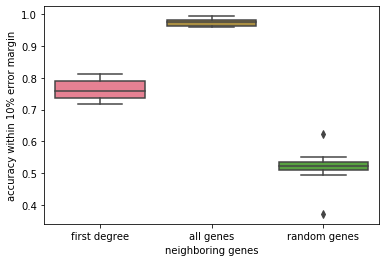

In [42]:
acc_df = pd.DataFrame.from_dict({'first degree': firstdeg_test[3], 
                                 'all genes': fc_test[3],
                                 'random genes': random_test[3]})

acc_df= acc_df.melt()
acc_df.columns = ["neighboring genes", "accuracy within 10% error margin"]
sns.set_palette("husl")
sns.boxplot(x="neighboring genes", y="accuracy within 10% error margin", data=acc_df)

### Visualizing Prediction for Test Data (First Degree Neighbor Genes)

In [19]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [20]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

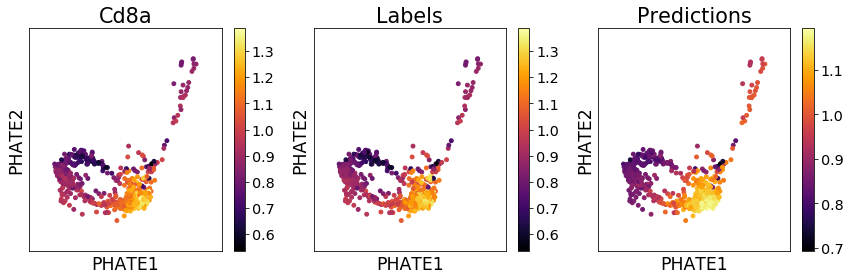

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (All Genes)

In [22]:
fc_test[0]['prediction'] = fc_test[1]
fc_test[0]['label'] = fc_test[2]
fc_test[0].sort_index(inplace=True)

In [23]:
test_mask = data_magic_filt.index.isin(fc_test[0].index)

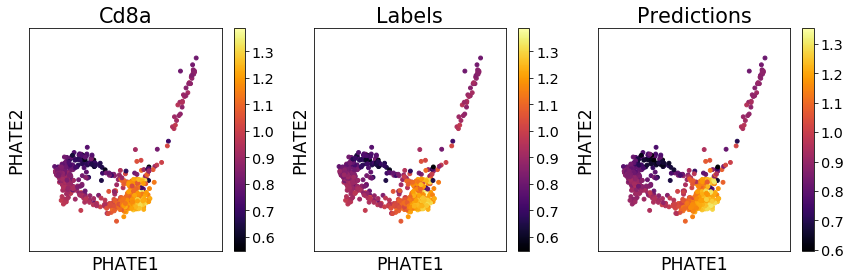

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=fc_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=fc_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (Random Genes)

In [25]:
random_test[0]['prediction'] = random_test[1]
random_test[0]['label'] = random_test[2]
random_test[0].sort_index(inplace=True)

In [26]:
test_mask = data_magic_filt.index.isin(random_test[0].index)

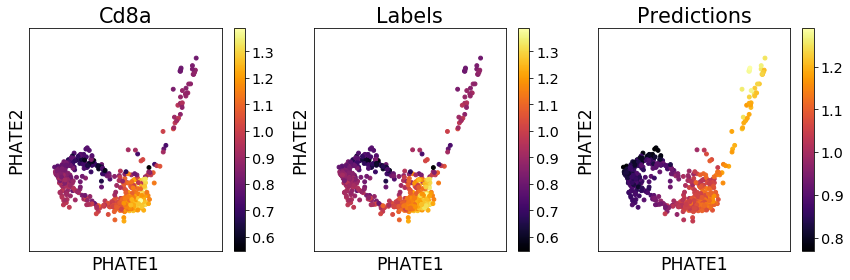

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=random_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=random_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

## Train for Sell with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [43]:
gene = ensembl['Sell']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [44]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Sell
Number of first neighbors in graph 1296
Number of first neighbors in graph and found in dataset 821


In [45]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

Early stopping metric is mean_squared_error


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0429
  batch (10/652), train loss:0.0339
  batch (20/652), train loss:0.0262
  batch (30/652), train loss:0.0308
  batch (40/652), train loss:0.0416
  batch (50/652), train loss:0.0366
  batch (60/652), train loss:0.0319
  batch (70/652), train loss:0.0347
  batch (80/652), train loss:0.0249
  batch (90/652), train loss:0.0335
  batch (100/652), train loss:0.0240
  batch (110/652), train loss:0.0248
  batch (120/652), train loss:0.0329
  batch (130/652), train loss:0.0210
  batch (140/652), train loss:0.0328
  batch (150/652), train loss:0.0265
  batch (160/652), train loss:0.0349
  batch (170/652), train loss:0.0322
  batch (180/652), train loss:0.0317
  batch (190/652), train loss:0.0298
  batch (200/652), train loss:0.0339
  batch (210/652), train loss:0.0287
  batch (220/652), train loss:0.0279
  batch (230/652), train loss:0.0226
  batch (240/652), train loss:0.0201
  batch (250/652), train loss:0.0295
  batch (260/652), train loss:0.0247
  batch (270

  batch (280/652), train loss:0.0024
  batch (290/652), train loss:0.0017
  batch (300/652), train loss:0.0019
  batch (310/652), train loss:0.0012
  batch (320/652), train loss:0.0016
  batch (330/652), train loss:0.0011
  batch (340/652), train loss:0.0025
  batch (350/652), train loss:0.0017
  batch (360/652), train loss:0.0017
  batch (370/652), train loss:0.0009
  batch (380/652), train loss:0.0029
  batch (390/652), train loss:0.0009
  batch (400/652), train loss:0.0010
  batch (410/652), train loss:0.0012
  batch (420/652), train loss:0.0015
  batch (430/652), train loss:0.0007
  batch (440/652), train loss:0.0014
  batch (450/652), train loss:0.0016
  batch (460/652), train loss:0.0011
  batch (470/652), train loss:0.0012
  batch (480/652), train loss:0.0007
  batch (490/652), train loss:0.0011
  batch (500/652), train loss:0.0006
  batch (510/652), train loss:0.0012
  batch (520/652), train loss:0.0010
  batch (530/652), train loss:0.0010
  batch (540/652), train loss:0.0016
 

epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0009
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0010
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0009
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0009
  batch (140/652), train loss:0.0009
  batch (150/652), train loss:0.0004
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0006
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0010
  batch (230/652), train loss:0.0005
  batch (240/652), train loss:0.0005
  batch (250/652), train 

  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0008
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0008
  batch (550/652), train loss:0.0006
  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0005
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0012
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0003
  batch (640/652), train loss:0.0005
  batch (650/652), train loss:0.0009
epoch: 10, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0008
  batch (30/652), train loss:0.0002
  batch (40/652), 

  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0007
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0006
  batch (140/652), train loss:0.0007
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0005
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0007
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0004
  batch (250/652), train loss:0.0011
  batch (260/652), train loss:0.0009
  batch (270/652), train loss:0.0003
  batch (280/652), train loss:0.0007
  batch (290/652), train loss:0.0004
  batch (300/652), train loss:0.0002
  batch (310/652), train loss:0.0002
  batc

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0327
  batch (10/652), train loss:0.0303
  batch (20/652), train loss:0.0285
  batch (30/652), train loss:0.0262
  batch (40/652), train loss:0.0305
  batch (50/652), train loss:0.0296
  batch (60/652), train loss:0.0320
  batch (70/652), train loss:0.0337
  batch (80/652), train loss:0.0244
  batch (90/652), train loss:0.0288
  batch (100/652), train loss:0.0286
  batch (110/652), train loss:0.0395
  batch (120/652), train loss:0.0306
  batch (130/652), train loss:0.0345
  batch (140/652), train loss:0.0176
  batch (150/652), train loss:0.0313
  batch (160/652), train loss:0.0311
  batch (170/652), train loss:0.0306
  batch (180/652), train loss:0.0318
  batch (190/652), train loss:0.0247
  batch (200/652), train loss:0.0349
  batch (210/652), train loss:0.0352
  batch (220/652), train loss:0.0289
  batch (230/652), train loss:0.0241
  batch (240/652), train loss:0.0244
  batch (250/652), train loss:0.0230
  batch (260/652), train loss:0.0280
  batch (270

  batch (300/652), train loss:0.0013
  batch (310/652), train loss:0.0015
  batch (320/652), train loss:0.0017
  batch (330/652), train loss:0.0021
  batch (340/652), train loss:0.0019
  batch (350/652), train loss:0.0020
  batch (360/652), train loss:0.0014
  batch (370/652), train loss:0.0021
  batch (380/652), train loss:0.0013
  batch (390/652), train loss:0.0016
  batch (400/652), train loss:0.0021
  batch (410/652), train loss:0.0021
  batch (420/652), train loss:0.0015
  batch (430/652), train loss:0.0023
  batch (440/652), train loss:0.0024
  batch (450/652), train loss:0.0014
  batch (460/652), train loss:0.0012
  batch (470/652), train loss:0.0022
  batch (480/652), train loss:0.0014
  batch (490/652), train loss:0.0015
  batch (500/652), train loss:0.0021
  batch (510/652), train loss:0.0019
  batch (520/652), train loss:0.0015
  batch (530/652), train loss:0.0013
  batch (540/652), train loss:0.0008
  batch (550/652), train loss:0.0023
  batch (560/652), train loss:0.0007
 

  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0005
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0003
  batch (610/652), train loss:0.0005
  batch (620/652), train loss:0.0006
  batch (630/652), train loss:0.0006
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0000
epoch: 7, time: 0.03, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0007
  batch (10/652), train loss:0.0005
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0012
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0007
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0021
  batch (150/652), train 

  batch (490/652), train loss:0.0007
  batch (500/652), train loss:0.0005
  batch (510/652), train loss:0.0004
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0003
  batch (540/652), train loss:0.0003
  batch (550/652), train loss:0.0012
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0003
  batch (630/652), train loss:0.0003
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 11, time: 0.03, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0005
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0004
  batch (80/652), trai

  batch (260/652), train loss:0.0003
  batch (270/652), train loss:0.0006
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0002
  batch (300/652), train loss:0.0002
  batch (310/652), train loss:0.0005
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0003
  batch (370/652), train loss:0.0003
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0006
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0012
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0002
  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0004
  batch (510/652), train loss:0.0003
  batch (520/652), train loss:0.0001
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0318
  batch (10/652), train loss:0.0402
  batch (20/652), train loss:0.0354
  batch (30/652), train loss:0.0292
  batch (40/652), train loss:0.0235
  batch (50/652), train loss:0.0334
  batch (60/652), train loss:0.0293
  batch (70/652), train loss:0.0295
  batch (80/652), train loss:0.0351
  batch (90/652), train loss:0.0284
  batch (100/652), train loss:0.0332
  batch (110/652), train loss:0.0236
  batch (120/652), train loss:0.0288
  batch (130/652), train loss:0.0303
  batch (140/652), train loss:0.0321
  batch (150/652), train loss:0.0284
  batch (160/652), train loss:0.0284
  batch (170/652), train loss:0.0330
  batch (180/652), train loss:0.0236
  batch (190/652), train loss:0.0287
  batch (200/652), train loss:0.0307
  batch (210/652), train loss:0.0176
  batch (220/652), train loss:0.0268
  batch (230/652), train loss:0.0299
  batch (240/652), train loss:0.0265
  batch (250/652), train loss:0.0237
  batch (260/652), train loss:0.0196
  batch (270

  batch (580/652), train loss:0.0010
  batch (590/652), train loss:0.0018
  batch (600/652), train loss:0.0014
  batch (610/652), train loss:0.0011
  batch (620/652), train loss:0.0017
  batch (630/652), train loss:0.0010
  batch (640/652), train loss:0.0017
  batch (650/652), train loss:0.0045
epoch: 3, time: 0.02, valid_metric: 0.05, train_metric: 0.05
  batch (0/652), train loss:0.0014
  batch (10/652), train loss:0.0019
  batch (20/652), train loss:0.0008
  batch (30/652), train loss:0.0012
  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0011
  batch (60/652), train loss:0.0010
  batch (70/652), train loss:0.0008
  batch (80/652), train loss:0.0009
  batch (90/652), train loss:0.0011
  batch (100/652), train loss:0.0009
  batch (110/652), train loss:0.0018
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0005
  batch (140/652), train loss:0.0011
  batch (150/652), train loss:0.0010
  batch (160/652), train loss:0.0010
  batch (170/652), train 

  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0011
epoch: 8, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0006
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0008
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0007
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0005
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0007
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0007
  batch (180/652), train loss:0.0010
  batch (190/652), train loss:0.0005
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0005
  batch (220/652), train 

  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0007
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0006
  batch (180/652), train loss:0.0007
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0004
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0003
  batch (250/652), train loss:0.0006
  batch (260/652), train loss:0.0004
  batch (270/652), train loss:0.0003
  batch (280/652), train loss:0.0002
  batch (290/652), train loss:0.0002
  batch (300/652), train loss:0.0002
  batch (310/652), train loss:0.0000
  batc

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0295
  batch (10/652), train loss:0.0346
  batch (20/652), train loss:0.0326
  batch (30/652), train loss:0.0352
  batch (40/652), train loss:0.0316
  batch (50/652), train loss:0.0311
  batch (60/652), train loss:0.0209
  batch (70/652), train loss:0.0328
  batch (80/652), train loss:0.0293
  batch (90/652), train loss:0.0235
  batch (100/652), train loss:0.0241
  batch (110/652), train loss:0.0316
  batch (120/652), train loss:0.0360
  batch (130/652), train loss:0.0322
  batch (140/652), train loss:0.0395
  batch (150/652), train loss:0.0223
  batch (160/652), train loss:0.0324
  batch (170/652), train loss:0.0309
  batch (180/652), train loss:0.0295
  batch (190/652), train loss:0.0224
  batch (200/652), train loss:0.0262
  batch (210/652), train loss:0.0292
  batch (220/652), train loss:0.0249
  batch (230/652), train loss:0.0305
  batch (240/652), train loss:0.0196
  batch (250/652), train loss:0.0314
  batch (260/652), train loss:0.0303
  batch (270

  batch (570/652), train loss:0.0009
  batch (580/652), train loss:0.0007
  batch (590/652), train loss:0.0013
  batch (600/652), train loss:0.0014
  batch (610/652), train loss:0.0013
  batch (620/652), train loss:0.0008
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0010
  batch (650/652), train loss:0.0009
epoch: 3, time: 0.02, valid_metric: 0.04, train_metric: 0.05
  batch (0/652), train loss:0.0009
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0019
  batch (30/652), train loss:0.0016
  batch (40/652), train loss:0.0008
  batch (50/652), train loss:0.0017
  batch (60/652), train loss:0.0011
  batch (70/652), train loss:0.0006
  batch (80/652), train loss:0.0009
  batch (90/652), train loss:0.0015
  batch (100/652), train loss:0.0007
  batch (110/652), train loss:0.0016
  batch (120/652), train loss:0.0007
  batch (130/652), train loss:0.0008
  batch (140/652), train loss:0.0005
  batch (150/652), train loss:0.0005
  batch (160/652), train 

  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0010
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0009
  batch (250/652), train loss:0.0002
  batch (260/652), train loss:0.0004
  batch (270/652), train loss:0.0008
  batch (280/652), train loss:0.0003
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0002
  batch (310/652), train loss:0.0006
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0003
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0013
  batch (360/652), train loss:0.0009
  batch (370/652), train loss:0.0010
  batch (380/652), train loss:0.0008
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0003
 

  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0005
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0009
  batch (360/652), train loss:0.0008
  batch (370/652), train loss:0.0009
  batch (380/652), train loss:0.0003
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0003
  batch (420/652), train loss:0.0005
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0004
  batch (460/652), train loss:0.0002
  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0005
  batch (510/652), train loss:0.0011
  batch (520/652), train loss:0.0005
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0003
  batch (550/652), train loss:0.0011
  batch (560/652), train loss:0.0002
 

epoch: 15, time: 0.04, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0010
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0005
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0008
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0006
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0360
  batch (10/652), train loss:0.0294
  batch (20/652), train loss:0.0336
  batch (30/652), train loss:0.0210
  batch (40/652), train loss:0.0249
  batch (50/652), train loss:0.0370
  batch (60/652), train loss:0.0304
  batch (70/652), train loss:0.0371
  batch (80/652), train loss:0.0294
  batch (90/652), train loss:0.0340
  batch (100/652), train loss:0.0343
  batch (110/652), train loss:0.0275
  batch (120/652), train loss:0.0227
  batch (130/652), train loss:0.0284
  batch (140/652), train loss:0.0326
  batch (150/652), train loss:0.0317
  batch (160/652), train loss:0.0213
  batch (170/652), train loss:0.0264
  batch (180/652), train loss:0.0322
  batch (190/652), train loss:0.0233
  batch (200/652), train loss:0.0312
  batch (210/652), train loss:0.0299
  batch (220/652), train loss:0.0235
  batch (230/652), train loss:0.0274
  batch (240/652), train loss:0.0269
  batch (250/652), train loss:0.0284
  batch (260/652), train loss:0.0214
  batch (270

  batch (340/652), train loss:0.0004
  batch (350/652), train loss:0.0007
  batch (360/652), train loss:0.0003
  batch (370/652), train loss:0.0004
  batch (380/652), train loss:0.0005
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0010
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0012
  batch (440/652), train loss:0.0008
  batch (450/652), train loss:0.0005
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0006
  batch (480/652), train loss:0.0004
  batch (490/652), train loss:0.0008
  batch (500/652), train loss:0.0004
  batch (510/652), train loss:0.0007
  batch (520/652), train loss:0.0007
  batch (530/652), train loss:0.0005
  batch (540/652), train loss:0.0003
  batch (550/652), train loss:0.0006
  batch (560/652), train loss:0.0007
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0007
  batch (590/652), train loss:0.0018
  batch (600/652), train loss:0.0009
 

  batch (310/652), train loss:0.0003
  batch (320/652), train loss:0.0006
  batch (330/652), train loss:0.0006
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0004
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0003
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0007
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0012
  batch (440/652), train loss:0.0006
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0003
  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0007
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0003
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0002
  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0005
  batch (570/652), train loss:0.0002
 

  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0002
  batch (560/652), train loss:0.0005
  batch (570/652), train loss:0.0002
  batch (580/652), train loss:0.0004
  batch (590/652), train loss:0.0012
  batch (600/652), train loss:0.0004
  batch (610/652), train loss:0.0006
  batch (620/652), train loss:0.0003
  batch (630/652), train loss:0.0003
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0000
epoch: 13, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0012
  batch (40/652), train loss:0.0007
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0007
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0005
  batch (110/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0284
  batch (10/652), train loss:0.0278
  batch (20/652), train loss:0.0304
  batch (30/652), train loss:0.0415
  batch (40/652), train loss:0.0412
  batch (50/652), train loss:0.0280
  batch (60/652), train loss:0.0302
  batch (70/652), train loss:0.0239
  batch (80/652), train loss:0.0207
  batch (90/652), train loss:0.0404
  batch (100/652), train loss:0.0234
  batch (110/652), train loss:0.0254
  batch (120/652), train loss:0.0286
  batch (130/652), train loss:0.0284
  batch (140/652), train loss:0.0301
  batch (150/652), train loss:0.0372
  batch (160/652), train loss:0.0262
  batch (170/652), train loss:0.0215
  batch (180/652), train loss:0.0209
  batch (190/652), train loss:0.0216
  batch (200/652), train loss:0.0346
  batch (210/652), train loss:0.0245
  batch (220/652), train loss:0.0272
  batch (230/652), train loss:0.0196
  batch (240/652), train loss:0.0326
  batch (250/652), train loss:0.0301
  batch (260/652), train loss:0.0388
  batch (270

  batch (270/652), train loss:0.0014
  batch (280/652), train loss:0.0032
  batch (290/652), train loss:0.0018
  batch (300/652), train loss:0.0020
  batch (310/652), train loss:0.0027
  batch (320/652), train loss:0.0019
  batch (330/652), train loss:0.0024
  batch (340/652), train loss:0.0019
  batch (350/652), train loss:0.0019
  batch (360/652), train loss:0.0016
  batch (370/652), train loss:0.0008
  batch (380/652), train loss:0.0021
  batch (390/652), train loss:0.0012
  batch (400/652), train loss:0.0020
  batch (410/652), train loss:0.0014
  batch (420/652), train loss:0.0014
  batch (430/652), train loss:0.0019
  batch (440/652), train loss:0.0017
  batch (450/652), train loss:0.0019
  batch (460/652), train loss:0.0018
  batch (470/652), train loss:0.0015
  batch (480/652), train loss:0.0016
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0013
  batch (510/652), train loss:0.0007
  batch (520/652), train loss:0.0022
  batch (530/652), train loss:0.0010
 

epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0006
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0008
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0006
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0005
  batch (120/652), train loss:0.0006
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0004
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0008
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0007
  batch (210/652), train loss:0.0005
  batch (220/652), train loss:0.0007
  batch (230/652), train loss:0.0007
  batch (240/652), train loss:0.0002
  batch (250/652), train 

  batch (650/652), train loss:0.0010
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0005
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0007
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0005
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0007
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0006
  batch (240/652), train

epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.02
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0003
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0007
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0004
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0007
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0001
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0265
  batch (10/652), train loss:0.0339
  batch (20/652), train loss:0.0306
  batch (30/652), train loss:0.0309
  batch (40/652), train loss:0.0362
  batch (50/652), train loss:0.0275
  batch (60/652), train loss:0.0254
  batch (70/652), train loss:0.0293
  batch (80/652), train loss:0.0376
  batch (90/652), train loss:0.0371
  batch (100/652), train loss:0.0280
  batch (110/652), train loss:0.0319
  batch (120/652), train loss:0.0365
  batch (130/652), train loss:0.0394
  batch (140/652), train loss:0.0378
  batch (150/652), train loss:0.0320
  batch (160/652), train loss:0.0288
  batch (170/652), train loss:0.0197
  batch (180/652), train loss:0.0285
  batch (190/652), train loss:0.0269
  batch (200/652), train loss:0.0191
  batch (210/652), train loss:0.0355
  batch (220/652), train loss:0.0316
  batch (230/652), train loss:0.0277
  batch (240/652), train loss:0.0289
  batch (250/652), train loss:0.0251
  batch (260/652), train loss:0.0268
  batch (270

  batch (220/652), train loss:0.0020
  batch (230/652), train loss:0.0021
  batch (240/652), train loss:0.0023
  batch (250/652), train loss:0.0024
  batch (260/652), train loss:0.0019
  batch (270/652), train loss:0.0025
  batch (280/652), train loss:0.0014
  batch (290/652), train loss:0.0015
  batch (300/652), train loss:0.0014
  batch (310/652), train loss:0.0016
  batch (320/652), train loss:0.0011
  batch (330/652), train loss:0.0020
  batch (340/652), train loss:0.0021
  batch (350/652), train loss:0.0016
  batch (360/652), train loss:0.0023
  batch (370/652), train loss:0.0012
  batch (380/652), train loss:0.0016
  batch (390/652), train loss:0.0029
  batch (400/652), train loss:0.0013
  batch (410/652), train loss:0.0018
  batch (420/652), train loss:0.0014
  batch (430/652), train loss:0.0012
  batch (440/652), train loss:0.0012
  batch (450/652), train loss:0.0013
  batch (460/652), train loss:0.0016
  batch (470/652), train loss:0.0015
  batch (480/652), train loss:0.0012
 

  batch (330/652), train loss:0.0006
  batch (340/652), train loss:0.0007
  batch (350/652), train loss:0.0004
  batch (360/652), train loss:0.0014
  batch (370/652), train loss:0.0002
  batch (380/652), train loss:0.0003
  batch (390/652), train loss:0.0007
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0006
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0004
  batch (460/652), train loss:0.0005
  batch (470/652), train loss:0.0008
  batch (480/652), train loss:0.0004
  batch (490/652), train loss:0.0009
  batch (500/652), train loss:0.0003
  batch (510/652), train loss:0.0010
  batch (520/652), train loss:0.0010
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0002
  batch (550/652), train loss:0.0004
  batch (560/652), train loss:0.0012
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0002
 

epoch: 10, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0008
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0006
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0005
  batch (200/652), train loss:0.0009
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0003
  batch (250/652), train

  batch (270/652), train loss:0.0012
  batch (280/652), train loss:0.0005
  batch (290/652), train loss:0.0005
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0003
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0004
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0003
  batch (360/652), train loss:0.0005
  batch (370/652), train loss:0.0002
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0004
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0004
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0007
  batch (480/652), train loss:0.0003
  batch (490/652), train loss:0.0008
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0004
  batch (520/652), train loss:0.0008
  batch (530/652), train loss:0.0002
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0268
  batch (10/652), train loss:0.0241
  batch (20/652), train loss:0.0265
  batch (30/652), train loss:0.0418
  batch (40/652), train loss:0.0294
  batch (50/652), train loss:0.0370
  batch (60/652), train loss:0.0393
  batch (70/652), train loss:0.0254
  batch (80/652), train loss:0.0297
  batch (90/652), train loss:0.0395
  batch (100/652), train loss:0.0285
  batch (110/652), train loss:0.0286
  batch (120/652), train loss:0.0292
  batch (130/652), train loss:0.0328
  batch (140/652), train loss:0.0252
  batch (150/652), train loss:0.0301
  batch (160/652), train loss:0.0305
  batch (170/652), train loss:0.0250
  batch (180/652), train loss:0.0275
  batch (190/652), train loss:0.0221
  batch (200/652), train loss:0.0355
  batch (210/652), train loss:0.0280
  batch (220/652), train loss:0.0241
  batch (230/652), train loss:0.0303
  batch (240/652), train loss:0.0296
  batch (250/652), train loss:0.0213
  batch (260/652), train loss:0.0233
  batch (270

  batch (310/652), train loss:0.0023
  batch (320/652), train loss:0.0014
  batch (330/652), train loss:0.0017
  batch (340/652), train loss:0.0027
  batch (350/652), train loss:0.0017
  batch (360/652), train loss:0.0019
  batch (370/652), train loss:0.0017
  batch (380/652), train loss:0.0014
  batch (390/652), train loss:0.0016
  batch (400/652), train loss:0.0013
  batch (410/652), train loss:0.0010
  batch (420/652), train loss:0.0015
  batch (430/652), train loss:0.0011
  batch (440/652), train loss:0.0024
  batch (450/652), train loss:0.0018
  batch (460/652), train loss:0.0010
  batch (470/652), train loss:0.0011
  batch (480/652), train loss:0.0024
  batch (490/652), train loss:0.0022
  batch (500/652), train loss:0.0011
  batch (510/652), train loss:0.0021
  batch (520/652), train loss:0.0007
  batch (530/652), train loss:0.0005
  batch (540/652), train loss:0.0012
  batch (550/652), train loss:0.0014
  batch (560/652), train loss:0.0026
  batch (570/652), train loss:0.0014
 

epoch: 6, time: 0.03, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0006
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0008
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0013
  batch (50/652), train loss:0.0005
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0007
  batch (100/652), train loss:0.0005
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0004
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0007
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0013
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0004
  batch (250/652), train 

  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0004
  batch (110/652), train loss:0.0005
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0007
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0004
  batch (250/652), train loss:0.0007
  batch (260/652), train loss:0.0003
  batch (270/652), train loss:0.0003
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0006
  batch (320/652), train loss:0.0006
  batch (330/652), train loss:0.0003
  batch (340/652), train loss:0.0009
  b

epoch: 15, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0010
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0003
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0003
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0218
  batch (10/652), train loss:0.0379
  batch (20/652), train loss:0.0315
  batch (30/652), train loss:0.0268
  batch (40/652), train loss:0.0322
  batch (50/652), train loss:0.0318
  batch (60/652), train loss:0.0260
  batch (70/652), train loss:0.0397
  batch (80/652), train loss:0.0332
  batch (90/652), train loss:0.0278
  batch (100/652), train loss:0.0352
  batch (110/652), train loss:0.0236
  batch (120/652), train loss:0.0230
  batch (130/652), train loss:0.0290
  batch (140/652), train loss:0.0317
  batch (150/652), train loss:0.0341
  batch (160/652), train loss:0.0248
  batch (170/652), train loss:0.0305
  batch (180/652), train loss:0.0318
  batch (190/652), train loss:0.0244
  batch (200/652), train loss:0.0266
  batch (210/652), train loss:0.0285
  batch (220/652), train loss:0.0249
  batch (230/652), train loss:0.0280
  batch (240/652), train loss:0.0278
  batch (250/652), train loss:0.0302
  batch (260/652), train loss:0.0280
  batch (270

  batch (610/652), train loss:0.0014
  batch (620/652), train loss:0.0010
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0004
  batch (650/652), train loss:0.0002
epoch: 4, time: 0.02, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0010
  batch (10/652), train loss:0.0006
  batch (20/652), train loss:0.0005
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0004
  batch (50/652), train loss:0.0008
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0009
  batch (110/652), train loss:0.0009
  batch (120/652), train loss:0.0009
  batch (130/652), train loss:0.0009
  batch (140/652), train loss:0.0006
  batch (150/652), train loss:0.0004
  batch (160/652), train loss:0.0009
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0008
  batch (190/652), train loss:0.0005
  batch (200/652), train 

  batch (460/652), train loss:0.0007
  batch (470/652), train loss:0.0004
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0003
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0003
  batch (540/652), train loss:0.0005
  batch (550/652), train loss:0.0004
  batch (560/652), train loss:0.0005
  batch (570/652), train loss:0.0009
  batch (580/652), train loss:0.0005
  batch (590/652), train loss:0.0004
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0013
  batch (620/652), train loss:0.0008
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0001
epoch: 9, time: 0.04, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0003
  batch (40/652), train loss:0.0004
  batch (50/652), tr

epoch: 13, time: 0.07, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0006
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0006
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0006
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0008
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0008
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0305
  batch (10/652), train loss:0.0301
  batch (20/652), train loss:0.0250
  batch (30/652), train loss:0.0346
  batch (40/652), train loss:0.0394
  batch (50/652), train loss:0.0342
  batch (60/652), train loss:0.0320
  batch (70/652), train loss:0.0317
  batch (80/652), train loss:0.0387
  batch (90/652), train loss:0.0208
  batch (100/652), train loss:0.0223
  batch (110/652), train loss:0.0250
  batch (120/652), train loss:0.0328
  batch (130/652), train loss:0.0301
  batch (140/652), train loss:0.0258
  batch (150/652), train loss:0.0289
  batch (160/652), train loss:0.0316
  batch (170/652), train loss:0.0213
  batch (180/652), train loss:0.0264
  batch (190/652), train loss:0.0297
  batch (200/652), train loss:0.0277
  batch (210/652), train loss:0.0265
  batch (220/652), train loss:0.0271
  batch (230/652), train loss:0.0191
  batch (240/652), train loss:0.0301
  batch (250/652), train loss:0.0292
  batch (260/652), train loss:0.0238
  batch (270

epoch: 3, time: 0.02, valid_metric: 0.05, train_metric: 0.05
  batch (0/652), train loss:0.0008
  batch (10/652), train loss:0.0009
  batch (20/652), train loss:0.0011
  batch (30/652), train loss:0.0008
  batch (40/652), train loss:0.0017
  batch (50/652), train loss:0.0012
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0009
  batch (80/652), train loss:0.0006
  batch (90/652), train loss:0.0007
  batch (100/652), train loss:0.0011
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0011
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0011
  batch (150/652), train loss:0.0007
  batch (160/652), train loss:0.0008
  batch (170/652), train loss:0.0010
  batch (180/652), train loss:0.0004
  batch (190/652), train loss:0.0017
  batch (200/652), train loss:0.0016
  batch (210/652), train loss:0.0010
  batch (220/652), train loss:0.0009
  batch (230/652), train loss:0.0010
  batch (240/652), train loss:0.0008
  batch (250/652), train 

  batch (270/652), train loss:0.0005
  batch (280/652), train loss:0.0002
  batch (290/652), train loss:0.0013
  batch (300/652), train loss:0.0010
  batch (310/652), train loss:0.0003
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0003
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0006
  batch (360/652), train loss:0.0011
  batch (370/652), train loss:0.0005
  batch (380/652), train loss:0.0003
  batch (390/652), train loss:0.0003
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0012
  batch (420/652), train loss:0.0015
  batch (430/652), train loss:0.0007
  batch (440/652), train loss:0.0004
  batch (450/652), train loss:0.0004
  batch (460/652), train loss:0.0008
  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0007
  batch (490/652), train loss:0.0003
  batch (500/652), train loss:0.0010
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0009
  batch (530/652), train loss:0.0006
 

epoch: 10, time: 0.05, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0008
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0007
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0006
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0012
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0004
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0005
  batch (250/652), train

  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0009
  batch (300/652), train loss:0.0004
  batch (310/652), train loss:0.0003
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0005
  batch (360/652), train loss:0.0008
  batch (370/652), train loss:0.0003
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0008
  batch (420/652), train loss:0.0010
  batch (430/652), train loss:0.0006
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0006
  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0007
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0006
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0002
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0628
  batch (10/652), train loss:0.0426
  batch (20/652), train loss:0.0645
  batch (30/652), train loss:0.0457
  batch (40/652), train loss:0.0387
  batch (50/652), train loss:0.0330
  batch (60/652), train loss:0.0447
  batch (70/652), train loss:0.0381
  batch (80/652), train loss:0.0340
  batch (90/652), train loss:0.0419
  batch (100/652), train loss:0.0424
  batch (110/652), train loss:0.0300
  batch (120/652), train loss:0.0423
  batch (130/652), train loss:0.0328
  batch (140/652), train loss:0.0426
  batch (150/652), train loss:0.0371
  batch (160/652), train loss:0.0277
  batch (170/652), train loss:0.0226
  batch (180/652), train loss:0.0229
  batch (190/652), train loss:0.0276
  batch (200/652), train loss:0.0345
  batch (210/652), train loss:0.0359
  batch (220/652), train loss:0.0308
  batch (230/652), train loss:0.0269
  batch (240/652), train loss:0.0219
  batch (250/652), train loss:0.0310
  batch (260/652), train loss:0.0183
  batch (270

  batch (430/652), train loss:0.0016
  batch (440/652), train loss:0.0004
  batch (450/652), train loss:0.0004
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0009
  batch (480/652), train loss:0.0014
  batch (490/652), train loss:0.0015
  batch (500/652), train loss:0.0008
  batch (510/652), train loss:0.0003
  batch (520/652), train loss:0.0014
  batch (530/652), train loss:0.0014
  batch (540/652), train loss:0.0012
  batch (550/652), train loss:0.0007
  batch (560/652), train loss:0.0012
  batch (570/652), train loss:0.0009
  batch (580/652), train loss:0.0018
  batch (590/652), train loss:0.0006
  batch (600/652), train loss:0.0007
  batch (610/652), train loss:0.0013
  batch (620/652), train loss:0.0016
  batch (630/652), train loss:0.0017
  batch (640/652), train loss:0.0017
  batch (650/652), train loss:0.0003
epoch: 4, time: 0.03, valid_metric: 0.05, train_metric: 0.05
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0013
  batch (20/652),

epoch: 8, time: 0.03, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0008
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0004
  batch (50/652), train loss:0.0007
  batch (60/652), train loss:0.0011
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0010
  batch (90/652), train loss:0.0008
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0014
  batch (120/652), train loss:0.0007
  batch (130/652), train loss:0.0010
  batch (140/652), train loss:0.0010
  batch (150/652), train loss:0.0007
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0010
  batch (180/652), train loss:0.0012
  batch (190/652), train loss:0.0009
  batch (200/652), train loss:0.0008
  batch (210/652), train loss:0.0008
  batch (220/652), train loss:0.0006
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0006
  batch (250/652), train 

epoch: 13, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0009
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0005
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0004
  batch (180/652), train loss:0.0007
  batch (190/652), train loss:0.0005
  batch (200/652), train loss:0.0005
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0003
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0445
  batch (10/652), train loss:0.0333
  batch (20/652), train loss:0.0336
  batch (30/652), train loss:0.0399
  batch (40/652), train loss:0.0290
  batch (50/652), train loss:0.0247
  batch (60/652), train loss:0.0317
  batch (70/652), train loss:0.0340
  batch (80/652), train loss:0.0306
  batch (90/652), train loss:0.0216
  batch (100/652), train loss:0.0287
  batch (110/652), train loss:0.0242
  batch (120/652), train loss:0.0257
  batch (130/652), train loss:0.0264
  batch (140/652), train loss:0.0208
  batch (150/652), train loss:0.0255
  batch (160/652), train loss:0.0156
  batch (170/652), train loss:0.0212
  batch (180/652), train loss:0.0240
  batch (190/652), train loss:0.0233
  batch (200/652), train loss:0.0199
  batch (210/652), train loss:0.0161
  batch (220/652), train loss:0.0183
  batch (230/652), train loss:0.0188
  batch (240/652), train loss:0.0132
  batch (250/652), train loss:0.0180
  batch (260/652), train loss:0.0182
  batch (270

  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0006
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0004
  batch (110/652), train loss:0.0005
  batch (120/652), train loss:0.0013
  batch (130/652), train loss:0.0006
  batch (140/652), train loss:0.0011
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0008
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0005
  batch (210/652), train loss:0.0013
  batch (220/652), train loss:0.0004
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0008
  batch (250/652), train loss:0.0005
  batch (260/652), train loss:0.0004
  batch (270/652), train loss:0.0003
  batch (280/652), train loss:0.0002
  batch (290/652), train loss:0.0005
  batch (300/652), train loss:0.0003
  batch (310/652), train loss:0.0014
  batch (320/652), train loss:0.0004
  batch (330/652), train loss:0.0002
  ba

  batch (320/652), train loss:0.0003
  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0002
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0004
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0003
  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0006
  batch (490/652), train loss:0.0004
  batch (500/652), train loss:0.0004
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0005
  batch (540/652), train loss:0.0002
  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0002
  batch (580/652), train loss:0.0004
 

  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0003
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0000
epoch: 10, time: 0.03, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0003
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0007
  batch (130/652), train

  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0003
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0522
  batch (10/652), train loss:0.0463
  batch (20/652), train loss:0.0281
  batch (30/652), train loss:0.0359
  batch (40/652), train loss:0.0264
  batch (50/652), train loss:0.0307
  batch (60/652), train loss:0.0287
  batch (70/652), train loss:0.0344
  batch (80/652), train loss:0.0271
  batch (90/652), train loss:0.0316
  batch (100/652), train loss:0.0221
  batch (110/652), train loss:0.0206
  batch (120/652), train loss:0.0304
  batch (130/652), train loss:0.0211
  batch (140/652), train loss:0.0175
  batch (150/652), train loss:0.0294
  batch (160/652), train loss:0.0162
  batch (170/652), train loss:0.0206
  batch (180/652), train loss:0.0242
  batch (190/652), train loss:0.0265
  batch (200/652), train loss:0.0217
  batch (210/652), train loss:0.0250
  batch (220/652), train loss:0.0200
  batch (230/652), train loss:0.0122
  batch (240/652), train loss:0.0213
  batch (250/652), train loss:0.0187
  batch (260/652), train loss:0.0170
  batch (270

  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0008
  batch (360/652), train loss:0.0004
  batch (370/652), train loss:0.0005
  batch (380/652), train loss:0.0004
  batch (390/652), train loss:0.0005
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0004
  batch (420/652), train loss:0.0006
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0009
  batch (450/652), train loss:0.0004
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0014
  batch (480/652), train loss:0.0006
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0010
  batch (510/652), train loss:0.0006
  batch (520/652), train loss:0.0010
  batch (530/652), train loss:0.0011
  batch (540/652), train loss:0.0007
  batch (550/652), train loss:0.0006
  batch (560/652), train loss:0.0007
  batch (570/652), train loss:0.0007
  batch (580/652), train loss:0.0006
  batch (590/652), train loss:0.0003
 

  batch (620/652), train loss:0.0012
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 7, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0007
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0009
  batch (50/652), train loss:0.0011
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0013
  batch (100/652), train loss:0.0021
  batch (110/652), train loss:0.0006
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0005
  batch (160/652), train loss:0.0007
  batch (170/652), train loss:0.0004
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0003
  batch (200/652), train loss:0.0002
  batch (210/652), train 

  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0004
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0006
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0003
  batch (170/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0229
  batch (10/652), train loss:0.0456
  batch (20/652), train loss:0.0601
  batch (30/652), train loss:0.0263
  batch (40/652), train loss:0.0420
  batch (50/652), train loss:0.0305
  batch (60/652), train loss:0.0268
  batch (70/652), train loss:0.0378
  batch (80/652), train loss:0.0290
  batch (90/652), train loss:0.0285
  batch (100/652), train loss:0.0303
  batch (110/652), train loss:0.0289
  batch (120/652), train loss:0.0273
  batch (130/652), train loss:0.0208
  batch (140/652), train loss:0.0297
  batch (150/652), train loss:0.0282
  batch (160/652), train loss:0.0266
  batch (170/652), train loss:0.0247
  batch (180/652), train loss:0.0266
  batch (190/652), train loss:0.0189
  batch (200/652), train loss:0.0168
  batch (210/652), train loss:0.0256
  batch (220/652), train loss:0.0232
  batch (230/652), train loss:0.0184
  batch (240/652), train loss:0.0200
  batch (250/652), train loss:0.0222
  batch (260/652), train loss:0.0173
  batch (270

  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0014
  batch (380/652), train loss:0.0007
  batch (390/652), train loss:0.0007
  batch (400/652), train loss:0.0011
  batch (410/652), train loss:0.0022
  batch (420/652), train loss:0.0020
  batch (430/652), train loss:0.0008
  batch (440/652), train loss:0.0007
  batch (450/652), train loss:0.0010
  batch (460/652), train loss:0.0014
  batch (470/652), train loss:0.0006
  batch (480/652), train loss:0.0008
  batch (490/652), train loss:0.0019
  batch (500/652), train loss:0.0010
  batch (510/652), train loss:0.0015
  batch (520/652), train loss:0.0016
  batch (530/652), train loss:0.0009
  batch (540/652), train loss:0.0006
  batch (550/652), train loss:0.0020
  batch (560/652), train loss:0.0010
  batch (570/652), train loss:0.0010
  batch (580/652), train loss:0.0021
  batch (590/652), train loss:0.0022
  batch (600/652), train loss:0.0008
  batch (610/652), train loss:0.0018
  batch (620/652), train loss:0.0008
 

epoch: 8, time: 0.02, valid_metric: 0.04, train_metric: 0.03
  batch (0/652), train loss:0.0005
  batch (10/652), train loss:0.0005
  batch (20/652), train loss:0.0005
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0007
  batch (50/652), train loss:0.0006
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0009
  batch (80/652), train loss:0.0010
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0005
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0005
  batch (130/652), train loss:0.0005
  batch (140/652), train loss:0.0006
  batch (150/652), train loss:0.0004
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0004
  batch (180/652), train loss:0.0007
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0004
  batch (210/652), train loss:0.0005
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0007
  batch (250/652), train 

  batch (540/652), train loss:0.0002
  batch (550/652), train loss:0.0006
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0007
  batch (590/652), train loss:0.0005
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0004
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0001
epoch: 13, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0003
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0002
  batch (130/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0542
  batch (10/652), train loss:0.0349
  batch (20/652), train loss:0.0326
  batch (30/652), train loss:0.0299
  batch (40/652), train loss:0.0287
  batch (50/652), train loss:0.0289
  batch (60/652), train loss:0.0247
  batch (70/652), train loss:0.0346
  batch (80/652), train loss:0.0282
  batch (90/652), train loss:0.0260
  batch (100/652), train loss:0.0187
  batch (110/652), train loss:0.0351
  batch (120/652), train loss:0.0252
  batch (130/652), train loss:0.0276
  batch (140/652), train loss:0.0210
  batch (150/652), train loss:0.0202
  batch (160/652), train loss:0.0221
  batch (170/652), train loss:0.0237
  batch (180/652), train loss:0.0239
  batch (190/652), train loss:0.0202
  batch (200/652), train loss:0.0171
  batch (210/652), train loss:0.0182
  batch (220/652), train loss:0.0211
  batch (230/652), train loss:0.0170
  batch (240/652), train loss:0.0149
  batch (250/652), train loss:0.0183
  batch (260/652), train loss:0.0127
  batch (270

  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0003
  batch (590/652), train loss:0.0003
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0010
  batch (620/652), train loss:0.0004
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0000
epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0013
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0011
  batch (80/652), train loss:0.0006
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0004
  batch (150/652), train 

epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0006
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0005
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train 

  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.01
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0497
  batch (10/652), train loss:0.0664
  batch (20/652), train loss:0.0415
  batch (30/652), train loss:0.0463
  batch (40/652), train loss:0.0374
  batch (50/652), train loss:0.0327
  batch (60/652), train loss:0.0278
  batch (70/652), train loss:0.0371
  batch (80/652), train loss:0.0273
  batch (90/652), train loss:0.0325
  batch (100/652), train loss:0.0326
  batch (110/652), train loss:0.0201
  batch (120/652), train loss:0.0305
  batch (130/652), train loss:0.0406
  batch (140/652), train loss:0.0283
  batch (150/652), train loss:0.0262
  batch (160/652), train loss:0.0299
  batch (170/652), train loss:0.0233
  batch (180/652), train loss:0.0263
  batch (190/652), train loss:0.0172
  batch (200/652), train loss:0.0240
  batch (210/652), train loss:0.0236
  batch (220/652), train loss:0.0204
  batch (230/652), train loss:0.0186
  batch (240/652), train loss:0.0203
  batch (250/652), train loss:0.0159
  batch (260/652), train loss:0.0197
  batch (270

  batch (40/652), train loss:0.0004
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0009
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0008
  batch (120/652), train loss:0.0011
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0013
  batch (150/652), train loss:0.0005
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0006
  batch (180/652), train loss:0.0006
  batch (190/652), train loss:0.0008
  batch (200/652), train loss:0.0013
  batch (210/652), train loss:0.0011
  batch (220/652), train loss:0.0009
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0007
  batch (250/652), train loss:0.0007
  batch (260/652), train loss:0.0006
  batch (270/652), train loss:0.0007
  batch (280/652), train loss:0.0007
  batch (290/652), train loss:0.0005
  batch (300/652), train loss:0.0007
  batch

  batch (610/652), train loss:0.0004
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0002
epoch: 8, time: 0.02, valid_metric: 0.02, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0007
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0005
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0004
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0002
  batch (200/652), train 

  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0002
  batch (250/652), train loss:0.0005
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0003
  batch (290/652), train loss:0.0004
  batch (300/652), train loss:0.0002
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0005
  batch (330/652), train loss:0.0003
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0003
  batch (370/652), train loss:0.0002
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0002
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
 

  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0002
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0003
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0003
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
total train time:2.31 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0385
  batch (10/652), train loss:0.0413
  batch (20/652), train loss:0.0210
  batch (30/652), train loss:0.0478
  batch (40/652), train loss:0.0288
  batch (50/652), train loss:0.0288
  batch (60/652), train loss:0.0380
  batch (70/652), train loss:0.0363
  batch (80/652), train loss:0.0248
  batch (90/652), train loss:0.0296
  batch (100/652), train loss:0.0207
  batch (110/652), train loss:0.0363
  batch (120/652), train loss:0.0455
  batch (130/652), train loss:0.0221
  batch (140/652), train loss:0.0325
  batch (150/652), train loss:0.0413
  batch (160/652), train loss:0.0265
  batch (170/652), train loss:0.0323
  batch (180/652), train loss:0.0289
  batch (190/652), train loss:0.0209
  batch (200/652), train loss:0.0206
  batch (210/652), train loss:0.0236
  batch (220/652), train loss:0.0294
  batch (230/652), train loss:0.0188
  batch (240/652), train loss:0.0264
  batch (250/652), train loss:0.0228
  batch (260/652), train loss:0.0248
  batch (270

epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0012
  batch (10/652), train loss:0.0005
  batch (20/652), train loss:0.0008
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0004
  batch (50/652), train loss:0.0011
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0008
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0009
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0011
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0005
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0004
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0007
  batch (250/652), train 

  batch (590/652), train loss:0.0006
  batch (600/652), train loss:0.0003
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0002
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0006
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0005
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0005
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0001
  batch (180/652), train 

  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0003
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0002
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), trai

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0548
  batch (10/652), train loss:0.0588
  batch (20/652), train loss:0.0532
  batch (30/652), train loss:0.0323
  batch (40/652), train loss:0.0297
  batch (50/652), train loss:0.0318
  batch (60/652), train loss:0.0288
  batch (70/652), train loss:0.0344
  batch (80/652), train loss:0.0300
  batch (90/652), train loss:0.0236
  batch (100/652), train loss:0.0297
  batch (110/652), train loss:0.0272
  batch (120/652), train loss:0.0221
  batch (130/652), train loss:0.0288
  batch (140/652), train loss:0.0317
  batch (150/652), train loss:0.0256
  batch (160/652), train loss:0.0260
  batch (170/652), train loss:0.0214
  batch (180/652), train loss:0.0284
  batch (190/652), train loss:0.0227
  batch (200/652), train loss:0.0155
  batch (210/652), train loss:0.0216
  batch (220/652), train loss:0.0210
  batch (230/652), train loss:0.0189
  batch (240/652), train loss:0.0210
  batch (250/652), train loss:0.0173
  batch (260/652), train loss:0.0234
  batch (270

  batch (220/652), train loss:0.0020
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0009
  batch (250/652), train loss:0.0003
  batch (260/652), train loss:0.0017
  batch (270/652), train loss:0.0006
  batch (280/652), train loss:0.0012
  batch (290/652), train loss:0.0007
  batch (300/652), train loss:0.0005
  batch (310/652), train loss:0.0008
  batch (320/652), train loss:0.0007
  batch (330/652), train loss:0.0014
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0007
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0006
  batch (380/652), train loss:0.0010
  batch (390/652), train loss:0.0006
  batch (400/652), train loss:0.0006
  batch (410/652), train loss:0.0002
  batch (420/652), train loss:0.0010
  batch (430/652), train loss:0.0005
  batch (440/652), train loss:0.0011
  batch (450/652), train loss:0.0006
  batch (460/652), train loss:0.0007
  batch (470/652), train loss:0.0004
  batch (480/652), train loss:0.0010
 

  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0010
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0004
  batch (600/652), train loss:0.0004
  batch (610/652), train loss:0.0004
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0003
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0006
  batch (10/652), train loss:0.0005
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0004
  batch (50/652), train loss:0.0005
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0008
  batch (100/652), train loss:0.0004
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0003
  batch (140/652), train 

  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0003
  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0003
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0002
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0003
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0001
epoch: 11, time: 0.02, valid_metric: 0

  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0002
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0001
  b

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0480
  batch (10/652), train loss:0.0502
  batch (20/652), train loss:0.0348
  batch (30/652), train loss:0.0253
  batch (40/652), train loss:0.0313
  batch (50/652), train loss:0.0271
  batch (60/652), train loss:0.0285
  batch (70/652), train loss:0.0320
  batch (80/652), train loss:0.0327
  batch (90/652), train loss:0.0280
  batch (100/652), train loss:0.0264
  batch (110/652), train loss:0.0274
  batch (120/652), train loss:0.0211
  batch (130/652), train loss:0.0319
  batch (140/652), train loss:0.0313
  batch (150/652), train loss:0.0278
  batch (160/652), train loss:0.0287
  batch (170/652), train loss:0.0186
  batch (180/652), train loss:0.0195
  batch (190/652), train loss:0.0229
  batch (200/652), train loss:0.0218
  batch (210/652), train loss:0.0259
  batch (220/652), train loss:0.0161
  batch (230/652), train loss:0.0212
  batch (240/652), train loss:0.0157
  batch (250/652), train loss:0.0225
  batch (260/652), train loss:0.0171
  batch (270

  batch (630/652), train loss:0.0005
  batch (640/652), train loss:0.0004
  batch (650/652), train loss:0.0000
epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0011
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0007
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0005
  batch (120/652), train loss:0.0007
  batch (130/652), train loss:0.0004
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0006
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0008
  batch (180/652), train loss:0.0005
  batch (190/652), train loss:0.0006
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0005
  batch (220/652), train 

  batch (460/652), train loss:0.0003
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0003
  batch (510/652), train loss:0.0004
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0004
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0005
  batch (620/652), train loss:0.0004
  batch (630/652), train loss:0.0002
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0000
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0001
  batch (50/652), tr

epoch: 12, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0003
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0003
  batch (250/652), train

  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0002
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0001
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0517
  batch (10/652), train loss:0.0581
  batch (20/652), train loss:0.0405
  batch (30/652), train loss:0.0299
  batch (40/652), train loss:0.0329
  batch (50/652), train loss:0.0264
  batch (60/652), train loss:0.0305
  batch (70/652), train loss:0.0259
  batch (80/652), train loss:0.0270
  batch (90/652), train loss:0.0284
  batch (100/652), train loss:0.0290
  batch (110/652), train loss:0.0174
  batch (120/652), train loss:0.0282
  batch (130/652), train loss:0.0274
  batch (140/652), train loss:0.0258
  batch (150/652), train loss:0.0256
  batch (160/652), train loss:0.0169
  batch (170/652), train loss:0.0226
  batch (180/652), train loss:0.0210
  batch (190/652), train loss:0.0264
  batch (200/652), train loss:0.0211
  batch (210/652), train loss:0.0166
  batch (220/652), train loss:0.0163
  batch (230/652), train loss:0.0246
  batch (240/652), train loss:0.0169
  batch (250/652), train loss:0.0153
  batch (260/652), train loss:0.0173
  batch (270

  batch (360/652), train loss:0.0011
  batch (370/652), train loss:0.0008
  batch (380/652), train loss:0.0008
  batch (390/652), train loss:0.0008
  batch (400/652), train loss:0.0006
  batch (410/652), train loss:0.0007
  batch (420/652), train loss:0.0003
  batch (430/652), train loss:0.0006
  batch (440/652), train loss:0.0012
  batch (450/652), train loss:0.0009
  batch (460/652), train loss:0.0012
  batch (470/652), train loss:0.0011
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0011
  batch (510/652), train loss:0.0005
  batch (520/652), train loss:0.0007
  batch (530/652), train loss:0.0006
  batch (540/652), train loss:0.0011
  batch (550/652), train loss:0.0014
  batch (560/652), train loss:0.0006
  batch (570/652), train loss:0.0007
  batch (580/652), train loss:0.0006
  batch (590/652), train loss:0.0007
  batch (600/652), train loss:0.0010
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0005
 

epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0007
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0005
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0008
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0006
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0010
  batch (240/652), train loss:0.0002
  batch (250/652), train 

  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0003
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0003
  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0003
  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0003
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0005
  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0002
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0003
  batch (600/652), train loss:0.0002
  batch (610/652), train loss:0.0001
 

epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0001
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0306
  batch (10/652), train loss:0.0313
  batch (20/652), train loss:0.0422
  batch (30/652), train loss:0.0408
  batch (40/652), train loss:0.0276
  batch (50/652), train loss:0.0354
  batch (60/652), train loss:0.0277
  batch (70/652), train loss:0.0380
  batch (80/652), train loss:0.0254
  batch (90/652), train loss:0.0431
  batch (100/652), train loss:0.0303
  batch (110/652), train loss:0.0282
  batch (120/652), train loss:0.0348
  batch (130/652), train loss:0.0280
  batch (140/652), train loss:0.0299
  batch (150/652), train loss:0.0145
  batch (160/652), train loss:0.0312
  batch (170/652), train loss:0.0214
  batch (180/652), train loss:0.0296
  batch (190/652), train loss:0.0211
  batch (200/652), train loss:0.0211
  batch (210/652), train loss:0.0370
  batch (220/652), train loss:0.0233
  batch (230/652), train loss:0.0285
  batch (240/652), train loss:0.0389
  batch (250/652), train loss:0.0302
  batch (260/652), train loss:0.0336
  batch (270

  batch (620/652), train loss:0.0182
  batch (630/652), train loss:0.0184
  batch (640/652), train loss:0.0167
  batch (650/652), train loss:0.0084
epoch: 4, time: 0.01, valid_metric: 0.18, train_metric: 0.18
  batch (0/652), train loss:0.0170
  batch (10/652), train loss:0.0159
  batch (20/652), train loss:0.0180
  batch (30/652), train loss:0.0184
  batch (40/652), train loss:0.0138
  batch (50/652), train loss:0.0194
  batch (60/652), train loss:0.0154
  batch (70/652), train loss:0.0178
  batch (80/652), train loss:0.0160
  batch (90/652), train loss:0.0193
  batch (100/652), train loss:0.0146
  batch (110/652), train loss:0.0167
  batch (120/652), train loss:0.0173
  batch (130/652), train loss:0.0137
  batch (140/652), train loss:0.0178
  batch (150/652), train loss:0.0090
  batch (160/652), train loss:0.0178
  batch (170/652), train loss:0.0139
  batch (180/652), train loss:0.0138
  batch (190/652), train loss:0.0131
  batch (200/652), train loss:0.0104
  batch (210/652), train 

  batch (30/652), train loss:0.0026
  batch (40/652), train loss:0.0018
  batch (50/652), train loss:0.0031
  batch (60/652), train loss:0.0023
  batch (70/652), train loss:0.0023
  batch (80/652), train loss:0.0023
  batch (90/652), train loss:0.0042
  batch (100/652), train loss:0.0014
  batch (110/652), train loss:0.0024
  batch (120/652), train loss:0.0020
  batch (130/652), train loss:0.0016
  batch (140/652), train loss:0.0033
  batch (150/652), train loss:0.0019
  batch (160/652), train loss:0.0024
  batch (170/652), train loss:0.0020
  batch (180/652), train loss:0.0016
  batch (190/652), train loss:0.0021
  batch (200/652), train loss:0.0009
  batch (210/652), train loss:0.0037
  batch (220/652), train loss:0.0014
  batch (230/652), train loss:0.0017
  batch (240/652), train loss:0.0028
  batch (250/652), train loss:0.0022
  batch (260/652), train loss:0.0037
  batch (270/652), train loss:0.0010
  batch (280/652), train loss:0.0034
  batch (290/652), train loss:0.0014
  batch 

epoch: 12, time: 0.02, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0007
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0006
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0014
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0005
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0012
  batch (150/652), train loss:0.0008
  batch (160/652), train loss:0.0007
  batch (170/652), train loss:0.0005
  batch (180/652), train loss:0.0006
  batch (190/652), train loss:0.0008
  batch (200/652), train loss:0.0007
  batch (210/652), train loss:0.0022
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0006
  batch (250/652), train

total train time:1.67 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0342
  batch (10/652), train loss:0.0331
  batch (20/652), train loss:0.0216
  batch (30/652), train loss:0.0289
  batch (40/652), train loss:0.0275
  batch (50/652), train loss:0.0191
  batch (60/652), train loss:0.0228
  batch (70/652), train loss:0.0412
  batch (80/652), train loss:0.0362
  batch (90/652), train loss:0.0258
  batch (100/652), train loss:0.0334
  batch (110/652), train loss:0.0300
  batch (120/652), train loss:0.0341
  batch (130/652), train loss:0.0269
  batch (140/652), train loss:0.0269
  batch (150/652), train loss:0.0308
  batch (160/652), train loss:0.0313
  batch (170/652), train loss:0.0198
  batch (180/652), train loss:0.0316
  batch (190/652), train loss:0.0210
  batch (200/652), train loss:0.0281
  batch (210/652), train loss:0.0289
  batch (220/652), train loss:0.0320
  batch (230/652), train loss:0.0277
  batch (240/652), train loss:0.0216
  batch (250/652), train loss:0.0298
  batch (260/652), train loss:0.0283
  batch (270

  batch (490/652), train loss:0.0159
  batch (500/652), train loss:0.0107
  batch (510/652), train loss:0.0190
  batch (520/652), train loss:0.0150
  batch (530/652), train loss:0.0120
  batch (540/652), train loss:0.0195
  batch (550/652), train loss:0.0148
  batch (560/652), train loss:0.0177
  batch (570/652), train loss:0.0180
  batch (580/652), train loss:0.0133
  batch (590/652), train loss:0.0149
  batch (600/652), train loss:0.0179
  batch (610/652), train loss:0.0158
  batch (620/652), train loss:0.0160
  batch (630/652), train loss:0.0137
  batch (640/652), train loss:0.0181
  batch (650/652), train loss:0.0131
epoch: 3, time: 0.02, valid_metric: 0.17, train_metric: 0.17
  batch (0/652), train loss:0.0118
  batch (10/652), train loss:0.0135
  batch (20/652), train loss:0.0131
  batch (30/652), train loss:0.0140
  batch (40/652), train loss:0.0127
  batch (50/652), train loss:0.0115
  batch (60/652), train loss:0.0168
  batch (70/652), train loss:0.0189
  batch (80/652), train

  batch (210/652), train loss:0.0034
  batch (220/652), train loss:0.0034
  batch (230/652), train loss:0.0029
  batch (240/652), train loss:0.0025
  batch (250/652), train loss:0.0039
  batch (260/652), train loss:0.0045
  batch (270/652), train loss:0.0040
  batch (280/652), train loss:0.0030
  batch (290/652), train loss:0.0024
  batch (300/652), train loss:0.0020
  batch (310/652), train loss:0.0025
  batch (320/652), train loss:0.0026
  batch (330/652), train loss:0.0019
  batch (340/652), train loss:0.0025
  batch (350/652), train loss:0.0033
  batch (360/652), train loss:0.0033
  batch (370/652), train loss:0.0042
  batch (380/652), train loss:0.0023
  batch (390/652), train loss:0.0023
  batch (400/652), train loss:0.0029
  batch (410/652), train loss:0.0031
  batch (420/652), train loss:0.0029
  batch (430/652), train loss:0.0029
  batch (440/652), train loss:0.0031
  batch (450/652), train loss:0.0029
  batch (460/652), train loss:0.0027
  batch (470/652), train loss:0.0026
 

epoch: 10, time: 0.02, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0005
  batch (20/652), train loss:0.0011
  batch (30/652), train loss:0.0015
  batch (40/652), train loss:0.0004
  batch (50/652), train loss:0.0014
  batch (60/652), train loss:0.0016
  batch (70/652), train loss:0.0014
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0011
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0011
  batch (120/652), train loss:0.0028
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0016
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0012
  batch (180/652), train loss:0.0007
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0008
  batch (240/652), train loss:0.0018
  batch (250/652), train

  batch (300/652), train loss:0.0003
  batch (310/652), train loss:0.0007
  batch (320/652), train loss:0.0003
  batch (330/652), train loss:0.0013
  batch (340/652), train loss:0.0004
  batch (350/652), train loss:0.0004
  batch (360/652), train loss:0.0003
  batch (370/652), train loss:0.0005
  batch (380/652), train loss:0.0007
  batch (390/652), train loss:0.0004
  batch (400/652), train loss:0.0006
  batch (410/652), train loss:0.0012
  batch (420/652), train loss:0.0015
  batch (430/652), train loss:0.0006
  batch (440/652), train loss:0.0006
  batch (450/652), train loss:0.0006
  batch (460/652), train loss:0.0005
  batch (470/652), train loss:0.0009
  batch (480/652), train loss:0.0012
  batch (490/652), train loss:0.0003
  batch (500/652), train loss:0.0024
  batch (510/652), train loss:0.0005
  batch (520/652), train loss:0.0003
  batch (530/652), train loss:0.0005
  batch (540/652), train loss:0.0009
  batch (550/652), train loss:0.0004
  batch (560/652), train loss:0.0008
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0196
  batch (10/652), train loss:0.0399
  batch (20/652), train loss:0.0389
  batch (30/652), train loss:0.0196
  batch (40/652), train loss:0.0396
  batch (50/652), train loss:0.0414
  batch (60/652), train loss:0.0203
  batch (70/652), train loss:0.0318
  batch (80/652), train loss:0.0292
  batch (90/652), train loss:0.0253
  batch (100/652), train loss:0.0323
  batch (110/652), train loss:0.0248
  batch (120/652), train loss:0.0277
  batch (130/652), train loss:0.0325
  batch (140/652), train loss:0.0357
  batch (150/652), train loss:0.0371
  batch (160/652), train loss:0.0386
  batch (170/652), train loss:0.0368
  batch (180/652), train loss:0.0261
  batch (190/652), train loss:0.0295
  batch (200/652), train loss:0.0304
  batch (210/652), train loss:0.0317
  batch (220/652), train loss:0.0315
  batch (230/652), train loss:0.0302
  batch (240/652), train loss:0.0352
  batch (250/652), train loss:0.0348
  batch (260/652), train loss:0.0421
  batch (270

  batch (300/652), train loss:0.0230
  batch (310/652), train loss:0.0238
  batch (320/652), train loss:0.0206
  batch (330/652), train loss:0.0228
  batch (340/652), train loss:0.0255
  batch (350/652), train loss:0.0278
  batch (360/652), train loss:0.0184
  batch (370/652), train loss:0.0208
  batch (380/652), train loss:0.0178
  batch (390/652), train loss:0.0252
  batch (400/652), train loss:0.0266
  batch (410/652), train loss:0.0268
  batch (420/652), train loss:0.0242
  batch (430/652), train loss:0.0210
  batch (440/652), train loss:0.0221
  batch (450/652), train loss:0.0242
  batch (460/652), train loss:0.0239
  batch (470/652), train loss:0.0226
  batch (480/652), train loss:0.0213
  batch (490/652), train loss:0.0224
  batch (500/652), train loss:0.0211
  batch (510/652), train loss:0.0232
  batch (520/652), train loss:0.0217
  batch (530/652), train loss:0.0187
  batch (540/652), train loss:0.0172
  batch (550/652), train loss:0.0212
  batch (560/652), train loss:0.0196
 

  batch (570/652), train loss:0.0153
  batch (580/652), train loss:0.0096
  batch (590/652), train loss:0.0166
  batch (600/652), train loss:0.0103
  batch (610/652), train loss:0.0117
  batch (620/652), train loss:0.0114
  batch (630/652), train loss:0.0098
  batch (640/652), train loss:0.0075
  batch (650/652), train loss:0.0063
epoch: 7, time: 0.01, valid_metric: 0.15, train_metric: 0.14
  batch (0/652), train loss:0.0103
  batch (10/652), train loss:0.0096
  batch (20/652), train loss:0.0123
  batch (30/652), train loss:0.0121
  batch (40/652), train loss:0.0099
  batch (50/652), train loss:0.0103
  batch (60/652), train loss:0.0099
  batch (70/652), train loss:0.0088
  batch (80/652), train loss:0.0085
  batch (90/652), train loss:0.0091
  batch (100/652), train loss:0.0089
  batch (110/652), train loss:0.0095
  batch (120/652), train loss:0.0098
  batch (130/652), train loss:0.0084
  batch (140/652), train loss:0.0082
  batch (150/652), train loss:0.0117
  batch (160/652), train 

  batch (200/652), train loss:0.0039
  batch (210/652), train loss:0.0038
  batch (220/652), train loss:0.0059
  batch (230/652), train loss:0.0036
  batch (240/652), train loss:0.0043
  batch (250/652), train loss:0.0024
  batch (260/652), train loss:0.0038
  batch (270/652), train loss:0.0100
  batch (280/652), train loss:0.0082
  batch (290/652), train loss:0.0065
  batch (300/652), train loss:0.0053
  batch (310/652), train loss:0.0037
  batch (320/652), train loss:0.0061
  batch (330/652), train loss:0.0057
  batch (340/652), train loss:0.0084
  batch (350/652), train loss:0.0091
  batch (360/652), train loss:0.0027
  batch (370/652), train loss:0.0045
  batch (380/652), train loss:0.0030
  batch (390/652), train loss:0.0075
  batch (400/652), train loss:0.0074
  batch (410/652), train loss:0.0061
  batch (420/652), train loss:0.0043
  batch (430/652), train loss:0.0077
  batch (440/652), train loss:0.0047
  batch (450/652), train loss:0.0047
  batch (460/652), train loss:0.0039
 

  batch (190/652), train loss:0.0028
  batch (200/652), train loss:0.0019
  batch (210/652), train loss:0.0021
  batch (220/652), train loss:0.0032
  batch (230/652), train loss:0.0017
  batch (240/652), train loss:0.0021
  batch (250/652), train loss:0.0012
  batch (260/652), train loss:0.0018
  batch (270/652), train loss:0.0054
  batch (280/652), train loss:0.0040
  batch (290/652), train loss:0.0032
  batch (300/652), train loss:0.0029
  batch (310/652), train loss:0.0019
  batch (320/652), train loss:0.0037
  batch (330/652), train loss:0.0032
  batch (340/652), train loss:0.0052
  batch (350/652), train loss:0.0049
  batch (360/652), train loss:0.0013
  batch (370/652), train loss:0.0023
  batch (380/652), train loss:0.0018
  batch (390/652), train loss:0.0043
  batch (400/652), train loss:0.0040
  batch (410/652), train loss:0.0032
  batch (420/652), train loss:0.0020
  batch (430/652), train loss:0.0040
  batch (440/652), train loss:0.0023
  batch (450/652), train loss:0.0023
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0306
  batch (10/652), train loss:0.0348
  batch (20/652), train loss:0.0383
  batch (30/652), train loss:0.0287
  batch (40/652), train loss:0.0273
  batch (50/652), train loss:0.0420
  batch (60/652), train loss:0.0337
  batch (70/652), train loss:0.0435
  batch (80/652), train loss:0.0359
  batch (90/652), train loss:0.0367
  batch (100/652), train loss:0.0428
  batch (110/652), train loss:0.0334
  batch (120/652), train loss:0.0361
  batch (130/652), train loss:0.0213
  batch (140/652), train loss:0.0221
  batch (150/652), train loss:0.0269
  batch (160/652), train loss:0.0351
  batch (170/652), train loss:0.0250
  batch (180/652), train loss:0.0325
  batch (190/652), train loss:0.0285
  batch (200/652), train loss:0.0323
  batch (210/652), train loss:0.0339
  batch (220/652), train loss:0.0238
  batch (230/652), train loss:0.0201
  batch (240/652), train loss:0.0364
  batch (250/652), train loss:0.0275
  batch (260/652), train loss:0.0311
  batch (270

  batch (60/652), train loss:0.0163
  batch (70/652), train loss:0.0183
  batch (80/652), train loss:0.0189
  batch (90/652), train loss:0.0168
  batch (100/652), train loss:0.0142
  batch (110/652), train loss:0.0193
  batch (120/652), train loss:0.0161
  batch (130/652), train loss:0.0165
  batch (140/652), train loss:0.0178
  batch (150/652), train loss:0.0117
  batch (160/652), train loss:0.0150
  batch (170/652), train loss:0.0149
  batch (180/652), train loss:0.0127
  batch (190/652), train loss:0.0160
  batch (200/652), train loss:0.0139
  batch (210/652), train loss:0.0131
  batch (220/652), train loss:0.0137
  batch (230/652), train loss:0.0102
  batch (240/652), train loss:0.0136
  batch (250/652), train loss:0.0159
  batch (260/652), train loss:0.0147
  batch (270/652), train loss:0.0146
  batch (280/652), train loss:0.0116
  batch (290/652), train loss:0.0135
  batch (300/652), train loss:0.0165
  batch (310/652), train loss:0.0147
  batch (320/652), train loss:0.0158
  bat

epoch: 7, time: 0.01, valid_metric: 0.06, train_metric: 0.07
  batch (0/652), train loss:0.0021
  batch (10/652), train loss:0.0018
  batch (20/652), train loss:0.0017
  batch (30/652), train loss:0.0010
  batch (40/652), train loss:0.0017
  batch (50/652), train loss:0.0014
  batch (60/652), train loss:0.0019
  batch (70/652), train loss:0.0025
  batch (80/652), train loss:0.0032
  batch (90/652), train loss:0.0025
  batch (100/652), train loss:0.0011
  batch (110/652), train loss:0.0023
  batch (120/652), train loss:0.0010
  batch (130/652), train loss:0.0026
  batch (140/652), train loss:0.0022
  batch (150/652), train loss:0.0020
  batch (160/652), train loss:0.0025
  batch (170/652), train loss:0.0025
  batch (180/652), train loss:0.0027
  batch (190/652), train loss:0.0024
  batch (200/652), train loss:0.0020
  batch (210/652), train loss:0.0019
  batch (220/652), train loss:0.0016
  batch (230/652), train loss:0.0013
  batch (240/652), train loss:0.0013
  batch (250/652), train 

epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0003
  batch (40/652), train loss:0.0009
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0006
  batch (80/652), train loss:0.0010
  batch (90/652), train loss:0.0008
  batch (100/652), train loss:0.0009
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0006
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0006
  batch (150/652), train loss:0.0018
  batch (160/652), train loss:0.0016
  batch (170/652), train loss:0.0009
  batch (180/652), train loss:0.0022
  batch (190/652), train loss:0.0006
  batch (200/652), train loss:0.0011
  batch (210/652), train loss:0.0012
  batch (220/652), train loss:0.0008
  batch (230/652), train loss:0.0007
  batch (240/652), train loss:0.0006
  batch (250/652), train

epoch: 15, time: 0.01, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0006
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0007
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0008
  batch (90/652), train loss:0.0006
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0004
  batch (130/652), train loss:0.0006
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0014
  batch (160/652), train loss:0.0014
  batch (170/652), train loss:0.0006
  batch (180/652), train loss:0.0021
  batch (190/652), train loss:0.0005
  batch (200/652), train loss:0.0010
  batch (210/652), train loss:0.0009
  batch (220/652), train loss:0.0004
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0006
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0251
  batch (10/652), train loss:0.0352
  batch (20/652), train loss:0.0281
  batch (30/652), train loss:0.0405
  batch (40/652), train loss:0.0260
  batch (50/652), train loss:0.0333
  batch (60/652), train loss:0.0294
  batch (70/652), train loss:0.0395
  batch (80/652), train loss:0.0323
  batch (90/652), train loss:0.0337
  batch (100/652), train loss:0.0259
  batch (110/652), train loss:0.0294
  batch (120/652), train loss:0.0297
  batch (130/652), train loss:0.0319
  batch (140/652), train loss:0.0334
  batch (150/652), train loss:0.0315
  batch (160/652), train loss:0.0276
  batch (170/652), train loss:0.0281
  batch (180/652), train loss:0.0334
  batch (190/652), train loss:0.0240
  batch (200/652), train loss:0.0275
  batch (210/652), train loss:0.0364
  batch (220/652), train loss:0.0307
  batch (230/652), train loss:0.0269
  batch (240/652), train loss:0.0283
  batch (250/652), train loss:0.0249
  batch (260/652), train loss:0.0341
  batch (270

  batch (50/652), train loss:0.0126
  batch (60/652), train loss:0.0122
  batch (70/652), train loss:0.0149
  batch (80/652), train loss:0.0114
  batch (90/652), train loss:0.0111
  batch (100/652), train loss:0.0100
  batch (110/652), train loss:0.0104
  batch (120/652), train loss:0.0109
  batch (130/652), train loss:0.0124
  batch (140/652), train loss:0.0130
  batch (150/652), train loss:0.0096
  batch (160/652), train loss:0.0123
  batch (170/652), train loss:0.0113
  batch (180/652), train loss:0.0159
  batch (190/652), train loss:0.0084
  batch (200/652), train loss:0.0101
  batch (210/652), train loss:0.0141
  batch (220/652), train loss:0.0116
  batch (230/652), train loss:0.0085
  batch (240/652), train loss:0.0096
  batch (250/652), train loss:0.0100
  batch (260/652), train loss:0.0112
  batch (270/652), train loss:0.0131
  batch (280/652), train loss:0.0131
  batch (290/652), train loss:0.0103
  batch (300/652), train loss:0.0105
  batch (310/652), train loss:0.0097
  batc

epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.05
  batch (0/652), train loss:0.0013
  batch (10/652), train loss:0.0009
  batch (20/652), train loss:0.0007
  batch (30/652), train loss:0.0011
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0015
  batch (60/652), train loss:0.0009
  batch (70/652), train loss:0.0014
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0006
  batch (100/652), train loss:0.0004
  batch (110/652), train loss:0.0011
  batch (120/652), train loss:0.0007
  batch (130/652), train loss:0.0015
  batch (140/652), train loss:0.0008
  batch (150/652), train loss:0.0015
  batch (160/652), train loss:0.0012
  batch (170/652), train loss:0.0008
  batch (180/652), train loss:0.0011
  batch (190/652), train loss:0.0008
  batch (200/652), train loss:0.0006
  batch (210/652), train loss:0.0019
  batch (220/652), train loss:0.0005
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0022
  batch (250/652), train 

  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0007
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0011
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0009
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0006
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0008
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0014
  batch (160/652), train loss:0.0007
  batch (170/652), train loss:0.0004
  batch (180/652), train loss:0.0007
  batch (190/652), train loss:0.0005
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0015
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0020
  batch (250/652), train loss:0.0004
  batch (260/652), train loss:0.0003
  batch (270/652), train loss:0.0010
  batch (2

epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0004
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0007
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0009
  batch (60/652), train loss:0.0006
  batch (70/652), train loss:0.0008
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0007
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0012
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0006
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0013
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0017
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0281
  batch (10/652), train loss:0.0233
  batch (20/652), train loss:0.0308
  batch (30/652), train loss:0.0295
  batch (40/652), train loss:0.0313
  batch (50/652), train loss:0.0230
  batch (60/652), train loss:0.0394
  batch (70/652), train loss:0.0289
  batch (80/652), train loss:0.0355
  batch (90/652), train loss:0.0265
  batch (100/652), train loss:0.0302
  batch (110/652), train loss:0.0310
  batch (120/652), train loss:0.0305
  batch (130/652), train loss:0.0385
  batch (140/652), train loss:0.0309
  batch (150/652), train loss:0.0322
  batch (160/652), train loss:0.0288
  batch (170/652), train loss:0.0283
  batch (180/652), train loss:0.0304
  batch (190/652), train loss:0.0333
  batch (200/652), train loss:0.0375
  batch (210/652), train loss:0.0267
  batch (220/652), train loss:0.0268
  batch (230/652), train loss:0.0273
  batch (240/652), train loss:0.0280
  batch (250/652), train loss:0.0311
  batch (260/652), train loss:0.0269
  batch (270

  batch (70/652), train loss:0.0088
  batch (80/652), train loss:0.0101
  batch (90/652), train loss:0.0107
  batch (100/652), train loss:0.0100
  batch (110/652), train loss:0.0100
  batch (120/652), train loss:0.0102
  batch (130/652), train loss:0.0113
  batch (140/652), train loss:0.0101
  batch (150/652), train loss:0.0105
  batch (160/652), train loss:0.0077
  batch (170/652), train loss:0.0083
  batch (180/652), train loss:0.0098
  batch (190/652), train loss:0.0100
  batch (200/652), train loss:0.0098
  batch (210/652), train loss:0.0081
  batch (220/652), train loss:0.0078
  batch (230/652), train loss:0.0070
  batch (240/652), train loss:0.0086
  batch (250/652), train loss:0.0083
  batch (260/652), train loss:0.0084
  batch (270/652), train loss:0.0083
  batch (280/652), train loss:0.0077
  batch (290/652), train loss:0.0078
  batch (300/652), train loss:0.0049
  batch (310/652), train loss:0.0083
  batch (320/652), train loss:0.0076
  batch (330/652), train loss:0.0075
  ba

  batch (20/652), train loss:0.0007
  batch (30/652), train loss:0.0009
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0011
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0009
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0009
  batch (100/652), train loss:0.0006
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0015
  batch (130/652), train loss:0.0006
  batch (140/652), train loss:0.0007
  batch (150/652), train loss:0.0025
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0008
  batch (180/652), train loss:0.0004
  batch (190/652), train loss:0.0018
  batch (200/652), train loss:0.0005
  batch (210/652), train loss:0.0006
  batch (220/652), train loss:0.0004
  batch (230/652), train loss:0.0004
  batch (240/652), train loss:0.0009
  batch (250/652), train loss:0.0013
  batch (260/652), train loss:0.0011
  batch (270/652), train loss:0.0009
  batch (280/652), train loss:0.0007
  batch (

epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.04
  batch (0/652), train loss:0.0008
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0007
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0006
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0004
  batch (120/652), train loss:0.0009
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0021
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0005
  batch (180/652), train loss:0.0004
  batch (190/652), train loss:0.0012
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0005
  batch (240/652), train loss:0.0006
  batch (250/652), train

epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0007
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0006
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0006
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0003
  batch (120/652), train loss:0.0008
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0018
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0005
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0011
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0003
  batch (230/652), train loss:0.0005
  batch (240/652), train loss:0.0005
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0392
  batch (10/652), train loss:0.0387
  batch (20/652), train loss:0.0304
  batch (30/652), train loss:0.0226
  batch (40/652), train loss:0.0311
  batch (50/652), train loss:0.0398
  batch (60/652), train loss:0.0160
  batch (70/652), train loss:0.0337
  batch (80/652), train loss:0.0406
  batch (90/652), train loss:0.0314
  batch (100/652), train loss:0.0263
  batch (110/652), train loss:0.0299
  batch (120/652), train loss:0.0287
  batch (130/652), train loss:0.0290
  batch (140/652), train loss:0.0304
  batch (150/652), train loss:0.0357
  batch (160/652), train loss:0.0281
  batch (170/652), train loss:0.0367
  batch (180/652), train loss:0.0288
  batch (190/652), train loss:0.0320
  batch (200/652), train loss:0.0296
  batch (210/652), train loss:0.0308
  batch (220/652), train loss:0.0284
  batch (230/652), train loss:0.0270
  batch (240/652), train loss:0.0294
  batch (250/652), train loss:0.0270
  batch (260/652), train loss:0.0264
  batch (270

epoch: 3, time: 0.01, valid_metric: 0.13, train_metric: 0.13
  batch (0/652), train loss:0.0077
  batch (10/652), train loss:0.0083
  batch (20/652), train loss:0.0079
  batch (30/652), train loss:0.0095
  batch (40/652), train loss:0.0055
  batch (50/652), train loss:0.0079
  batch (60/652), train loss:0.0087
  batch (70/652), train loss:0.0075
  batch (80/652), train loss:0.0062
  batch (90/652), train loss:0.0084
  batch (100/652), train loss:0.0060
  batch (110/652), train loss:0.0064
  batch (120/652), train loss:0.0091
  batch (130/652), train loss:0.0068
  batch (140/652), train loss:0.0093
  batch (150/652), train loss:0.0080
  batch (160/652), train loss:0.0072
  batch (170/652), train loss:0.0080
  batch (180/652), train loss:0.0072
  batch (190/652), train loss:0.0077
  batch (200/652), train loss:0.0052
  batch (210/652), train loss:0.0057
  batch (220/652), train loss:0.0084
  batch (230/652), train loss:0.0056
  batch (240/652), train loss:0.0057
  batch (250/652), train 

epoch: 7, time: 0.01, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0014
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0011
  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0011
  batch (60/652), train loss:0.0005
  batch (70/652), train loss:0.0014
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0005
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0005
  batch (130/652), train loss:0.0016
  batch (140/652), train loss:0.0007
  batch (150/652), train loss:0.0006
  batch (160/652), train loss:0.0005
  batch (170/652), train loss:0.0004
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0003
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0016
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0003
  batch (250/652), train 

epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0011
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0010
  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0008
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0010
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0015
  batch (140/652), train loss:0.0004
  batch (150/652), train loss:0.0004
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0013
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0002
  batch (250/652), train

  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0006
  batch (580/652), train loss:0.0004
  batch (590/652), train loss:0.0009
  batch (600/652), train loss:0.0008
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0005
  batch (630/652), train loss:0.0004
  batch (640/652), train loss:0.0006
  batch (650/652), train loss:0.0007
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0009
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0009
  batch (40/652), train loss:0.0005
  batch (50/652), train loss:0.0006
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0008
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0002
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0013
  batch (140/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0488
  batch (10/652), train loss:0.0354
  batch (20/652), train loss:0.0307
  batch (30/652), train loss:0.0247
  batch (40/652), train loss:0.0253
  batch (50/652), train loss:0.0172
  batch (60/652), train loss:0.0403
  batch (70/652), train loss:0.0333
  batch (80/652), train loss:0.0278
  batch (90/652), train loss:0.0303
  batch (100/652), train loss:0.0326
  batch (110/652), train loss:0.0311
  batch (120/652), train loss:0.0370
  batch (130/652), train loss:0.0256
  batch (140/652), train loss:0.0282
  batch (150/652), train loss:0.0186
  batch (160/652), train loss:0.0425
  batch (170/652), train loss:0.0409
  batch (180/652), train loss:0.0294
  batch (190/652), train loss:0.0305
  batch (200/652), train loss:0.0168
  batch (210/652), train loss:0.0333
  batch (220/652), train loss:0.0287
  batch (230/652), train loss:0.0334
  batch (240/652), train loss:0.0247
  batch (250/652), train loss:0.0288
  batch (260/652), train loss:0.0321
  batch (270

  batch (210/652), train loss:0.0173
  batch (220/652), train loss:0.0165
  batch (230/652), train loss:0.0170
  batch (240/652), train loss:0.0146
  batch (250/652), train loss:0.0145
  batch (260/652), train loss:0.0174
  batch (270/652), train loss:0.0153
  batch (280/652), train loss:0.0169
  batch (290/652), train loss:0.0133
  batch (300/652), train loss:0.0168
  batch (310/652), train loss:0.0141
  batch (320/652), train loss:0.0151
  batch (330/652), train loss:0.0131
  batch (340/652), train loss:0.0158
  batch (350/652), train loss:0.0164
  batch (360/652), train loss:0.0106
  batch (370/652), train loss:0.0140
  batch (380/652), train loss:0.0149
  batch (390/652), train loss:0.0200
  batch (400/652), train loss:0.0182
  batch (410/652), train loss:0.0128
  batch (420/652), train loss:0.0145
  batch (430/652), train loss:0.0119
  batch (440/652), train loss:0.0136
  batch (450/652), train loss:0.0142
  batch (460/652), train loss:0.0139
  batch (470/652), train loss:0.0139
 

  batch (520/652), train loss:0.0027
  batch (530/652), train loss:0.0019
  batch (540/652), train loss:0.0024
  batch (550/652), train loss:0.0024
  batch (560/652), train loss:0.0012
  batch (570/652), train loss:0.0016
  batch (580/652), train loss:0.0029
  batch (590/652), train loss:0.0030
  batch (600/652), train loss:0.0025
  batch (610/652), train loss:0.0024
  batch (620/652), train loss:0.0025
  batch (630/652), train loss:0.0020
  batch (640/652), train loss:0.0015
  batch (650/652), train loss:0.0037
epoch: 7, time: 0.01, valid_metric: 0.07, train_metric: 0.07
  batch (0/652), train loss:0.0010
  batch (10/652), train loss:0.0019
  batch (20/652), train loss:0.0022
  batch (30/652), train loss:0.0015
  batch (40/652), train loss:0.0009
  batch (50/652), train loss:0.0021
  batch (60/652), train loss:0.0024
  batch (70/652), train loss:0.0024
  batch (80/652), train loss:0.0022
  batch (90/652), train loss:0.0019
  batch (100/652), train loss:0.0031
  batch (110/652), train 

  batch (360/652), train loss:0.0005
  batch (370/652), train loss:0.0006
  batch (380/652), train loss:0.0014
  batch (390/652), train loss:0.0020
  batch (400/652), train loss:0.0005
  batch (410/652), train loss:0.0017
  batch (420/652), train loss:0.0004
  batch (430/652), train loss:0.0003
  batch (440/652), train loss:0.0006
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0014
  batch (480/652), train loss:0.0020
  batch (490/652), train loss:0.0006
  batch (500/652), train loss:0.0012
  batch (510/652), train loss:0.0005
  batch (520/652), train loss:0.0004
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0008
  batch (550/652), train loss:0.0003
  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0008
  batch (590/652), train loss:0.0005
  batch (600/652), train loss:0.0008
  batch (610/652), train loss:0.0009
  batch (620/652), train loss:0.0004
 

  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0007
  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0003
  batch (470/652), train loss:0.0012
  batch (480/652), train loss:0.0018
  batch (490/652), train loss:0.0005
  batch (500/652), train loss:0.0010
  batch (510/652), train loss:0.0005
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0006
  batch (550/652), train loss:0.0002
  batch (560/652), train loss:0.0004
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0005
  batch (590/652), train loss:0.0003
  batch (600/652), train loss:0.0007
  batch (610/652), train loss:0.0008
  batch (620/652), train loss:0.0003
  batch (630/652), train loss:0.0007
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0002
epoch: 15, time: 0.01, valid_metric: 0.04, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0005
  batch (20/652)

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0340
  batch (10/652), train loss:0.0399
  batch (20/652), train loss:0.0293
  batch (30/652), train loss:0.0301
  batch (40/652), train loss:0.0442
  batch (50/652), train loss:0.0308
  batch (60/652), train loss:0.0338
  batch (70/652), train loss:0.0264
  batch (80/652), train loss:0.0328
  batch (90/652), train loss:0.0407
  batch (100/652), train loss:0.0288
  batch (110/652), train loss:0.0274
  batch (120/652), train loss:0.0453
  batch (130/652), train loss:0.0200
  batch (140/652), train loss:0.0246
  batch (150/652), train loss:0.0364
  batch (160/652), train loss:0.0378
  batch (170/652), train loss:0.0446
  batch (180/652), train loss:0.0390
  batch (190/652), train loss:0.0307
  batch (200/652), train loss:0.0181
  batch (210/652), train loss:0.0312
  batch (220/652), train loss:0.0337
  batch (230/652), train loss:0.0259
  batch (240/652), train loss:0.0244
  batch (250/652), train loss:0.0249
  batch (260/652), train loss:0.0348
  batch (270

  batch (30/652), train loss:0.0153
  batch (40/652), train loss:0.0175
  batch (50/652), train loss:0.0166
  batch (60/652), train loss:0.0146
  batch (70/652), train loss:0.0147
  batch (80/652), train loss:0.0142
  batch (90/652), train loss:0.0181
  batch (100/652), train loss:0.0190
  batch (110/652), train loss:0.0174
  batch (120/652), train loss:0.0196
  batch (130/652), train loss:0.0164
  batch (140/652), train loss:0.0116
  batch (150/652), train loss:0.0185
  batch (160/652), train loss:0.0196
  batch (170/652), train loss:0.0178
  batch (180/652), train loss:0.0177
  batch (190/652), train loss:0.0153
  batch (200/652), train loss:0.0095
  batch (210/652), train loss:0.0143
  batch (220/652), train loss:0.0158
  batch (230/652), train loss:0.0137
  batch (240/652), train loss:0.0133
  batch (250/652), train loss:0.0121
  batch (260/652), train loss:0.0148
  batch (270/652), train loss:0.0165
  batch (280/652), train loss:0.0166
  batch (290/652), train loss:0.0161
  batch 

  batch (510/652), train loss:0.0017
  batch (520/652), train loss:0.0015
  batch (530/652), train loss:0.0016
  batch (540/652), train loss:0.0022
  batch (550/652), train loss:0.0021
  batch (560/652), train loss:0.0024
  batch (570/652), train loss:0.0019
  batch (580/652), train loss:0.0030
  batch (590/652), train loss:0.0016
  batch (600/652), train loss:0.0011
  batch (610/652), train loss:0.0010
  batch (620/652), train loss:0.0010
  batch (630/652), train loss:0.0022
  batch (640/652), train loss:0.0017
  batch (650/652), train loss:0.0010
epoch: 8, time: 0.01, valid_metric: 0.06, train_metric: 0.06
  batch (0/652), train loss:0.0011
  batch (10/652), train loss:0.0032
  batch (20/652), train loss:0.0015
  batch (30/652), train loss:0.0022
  batch (40/652), train loss:0.0019
  batch (50/652), train loss:0.0010
  batch (60/652), train loss:0.0016
  batch (70/652), train loss:0.0018
  batch (80/652), train loss:0.0015
  batch (90/652), train loss:0.0013
  batch (100/652), train 

  batch (600/652), train loss:0.0005
  batch (610/652), train loss:0.0003
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0008
  batch (640/652), train loss:0.0012
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.04
  batch (0/652), train loss:0.0005
  batch (10/652), train loss:0.0013
  batch (20/652), train loss:0.0007
  batch (30/652), train loss:0.0009
  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0004
  batch (60/652), train loss:0.0012
  batch (70/652), train loss:0.0005
  batch (80/652), train loss:0.0005
  batch (90/652), train loss:0.0004
  batch (100/652), train loss:0.0012
  batch (110/652), train loss:0.0013
  batch (120/652), train loss:0.0008
  batch (130/652), train loss:0.0021
  batch (140/652), train loss:0.0007
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0006
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0004
  batch (190/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0206
  batch (10/652), train loss:0.0360
  batch (20/652), train loss:0.0256
  batch (30/652), train loss:0.0280
  batch (40/652), train loss:0.0230
  batch (50/652), train loss:0.0297
  batch (60/652), train loss:0.0351
  batch (70/652), train loss:0.0407
  batch (80/652), train loss:0.0389
  batch (90/652), train loss:0.0254
  batch (100/652), train loss:0.0319
  batch (110/652), train loss:0.0338
  batch (120/652), train loss:0.0286
  batch (130/652), train loss:0.0366
  batch (140/652), train loss:0.0222
  batch (150/652), train loss:0.0409
  batch (160/652), train loss:0.0315
  batch (170/652), train loss:0.0451
  batch (180/652), train loss:0.0270
  batch (190/652), train loss:0.0323
  batch (200/652), train loss:0.0192
  batch (210/652), train loss:0.0293
  batch (220/652), train loss:0.0252
  batch (230/652), train loss:0.0350
  batch (240/652), train loss:0.0297
  batch (250/652), train loss:0.0347
  batch (260/652), train loss:0.0300
  batch (270

  batch (30/652), train loss:0.0130
  batch (40/652), train loss:0.0136
  batch (50/652), train loss:0.0127
  batch (60/652), train loss:0.0139
  batch (70/652), train loss:0.0135
  batch (80/652), train loss:0.0146
  batch (90/652), train loss:0.0115
  batch (100/652), train loss:0.0124
  batch (110/652), train loss:0.0131
  batch (120/652), train loss:0.0115
  batch (130/652), train loss:0.0131
  batch (140/652), train loss:0.0122
  batch (150/652), train loss:0.0168
  batch (160/652), train loss:0.0100
  batch (170/652), train loss:0.0139
  batch (180/652), train loss:0.0121
  batch (190/652), train loss:0.0154
  batch (200/652), train loss:0.0098
  batch (210/652), train loss:0.0099
  batch (220/652), train loss:0.0090
  batch (230/652), train loss:0.0125
  batch (240/652), train loss:0.0113
  batch (250/652), train loss:0.0137
  batch (260/652), train loss:0.0124
  batch (270/652), train loss:0.0131
  batch (280/652), train loss:0.0109
  batch (290/652), train loss:0.0107
  batch 

  batch (30/652), train loss:0.0014
  batch (40/652), train loss:0.0018
  batch (50/652), train loss:0.0015
  batch (60/652), train loss:0.0012
  batch (70/652), train loss:0.0008
  batch (80/652), train loss:0.0012
  batch (90/652), train loss:0.0016
  batch (100/652), train loss:0.0008
  batch (110/652), train loss:0.0018
  batch (120/652), train loss:0.0018
  batch (130/652), train loss:0.0018
  batch (140/652), train loss:0.0011
  batch (150/652), train loss:0.0015
  batch (160/652), train loss:0.0007
  batch (170/652), train loss:0.0007
  batch (180/652), train loss:0.0015
  batch (190/652), train loss:0.0016
  batch (200/652), train loss:0.0017
  batch (210/652), train loss:0.0007
  batch (220/652), train loss:0.0011
  batch (230/652), train loss:0.0006
  batch (240/652), train loss:0.0008
  batch (250/652), train loss:0.0013
  batch (260/652), train loss:0.0010
  batch (270/652), train loss:0.0019
  batch (280/652), train loss:0.0012
  batch (290/652), train loss:0.0008
  batch 

  batch (0/652), train loss:0.0003
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0005
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0007
  batch (50/652), train loss:0.0007
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0013
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0007
  batch (120/652), train loss:0.0011
  batch (130/652), train loss:0.0011
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0010
  batch (190/652), train loss:0.0005
  batch (200/652), train loss:0.0012
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0008
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0003
  batch (250/652), train loss:0.0003
  batch (260/652), train loss:0.0002
  batch (270

epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0003
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0006
  batch (50/652), train loss:0.0006
  batch (60/652), train loss:0.0004
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0003
  batch (90/652), train loss:0.0012
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0006
  batch (120/652), train loss:0.0009
  batch (130/652), train loss:0.0010
  batch (140/652), train loss:0.0003
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0006
  batch (190/652), train loss:0.0004
  batch (200/652), train loss:0.0010
  batch (210/652), train loss:0.0003
  batch (220/652), train loss:0.0008
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0003
  batch (250/652), train

### RMSE results

In [46]:
print('RMSE (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('RMSE (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('RMSE (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

RMSE (first degree): 0.001 +/- 0.000
RMSE (all genes): 0.000 +/- 0.000
RMSE (random genes): 0.001 +/- 0.001


### Accuracy within Error Margin Results

In [47]:
print('Accuracy (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_test[3]), np.std(firstdeg_test[3])))
print('Accuracy (all genes): %.3f +/- %.3f' %(np.mean(fc_test[3]), np.std(fc_test[3])))
print('Accuracy (random genes): %.3f +/- %.3f' %(np.mean(random_test[3]), np.std(random_test[3])))

Accuracy (first degree): 0.970 +/- 0.006
Accuracy (all genes): 0.996 +/- 0.002
Accuracy (random genes): 0.913 +/- 0.099


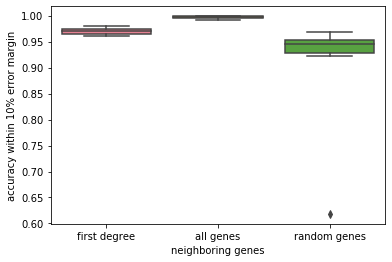

In [48]:
acc_df = pd.DataFrame.from_dict({'first degree': firstdeg_test[3], 
                                 'all genes': fc_test[3],
                                 'random genes': random_test[3]})

acc_df= acc_df.melt()
acc_df.columns = ["neighboring genes", "accuracy within 10% error margin"]
sns.set_palette("husl")
sns.boxplot(x="neighboring genes", y="accuracy within 10% error margin", data=acc_df)

### Visualizing Prediction for Test Data (First Degree Neighbor Genes)

In [49]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [50]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

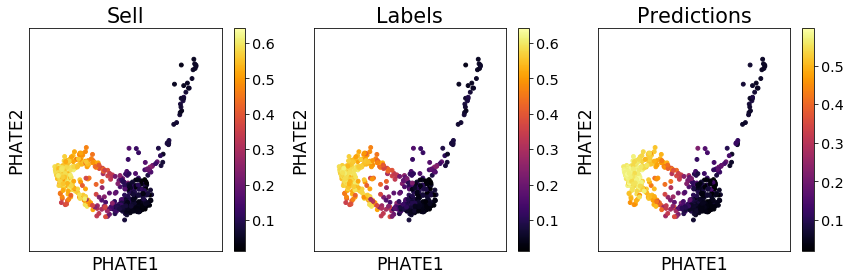

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (All Genes)

In [52]:
fc_test[0]['prediction'] = fc_test[1]
fc_test[0]['label'] = fc_test[2]
fc_test[0].sort_index(inplace=True)

In [53]:
test_mask = data_magic_filt.index.isin(fc_test[0].index)

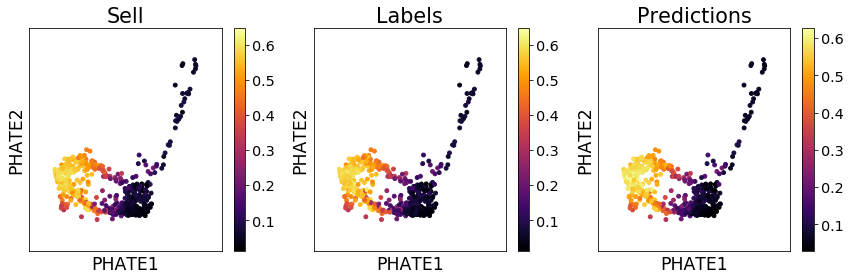

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=fc_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=fc_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (Random Genes)

In [55]:
random_test[0]['prediction'] = random_test[1]
random_test[0]['label'] = random_test[2]
random_test[0].sort_index(inplace=True)

In [56]:
test_mask = data_magic_filt.index.isin(random_test[0].index)

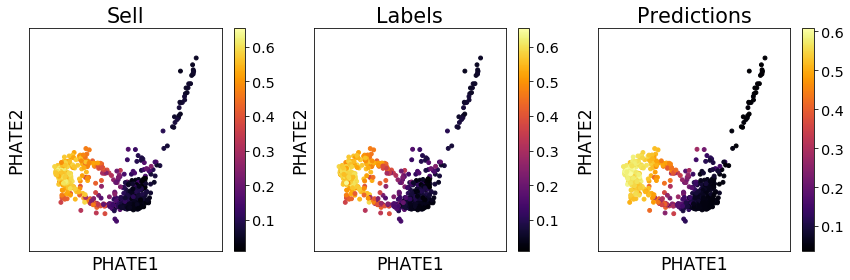

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=random_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=random_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

## Train for Foxp3 with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [58]:
gene = ensembl['Foxp3']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [59]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Foxp3
Number of first neighbors in graph 1636
Number of first neighbors in graph and found in dataset 1076


In [60]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

Early stopping metric is mean_squared_error


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0212
  batch (10/652), train loss:0.0194
  batch (20/652), train loss:0.0197
  batch (30/652), train loss:0.0196
  batch (40/652), train loss:0.0197
  batch (50/652), train loss:0.0174
  batch (60/652), train loss:0.0177
  batch (70/652), train loss:0.0182
  batch (80/652), train loss:0.0162
  batch (90/652), train loss:0.0156
  batch (100/652), train loss:0.0167
  batch (110/652), train loss:0.0164
  batch (120/652), train loss:0.0161
  batch (130/652), train loss:0.0159
  batch (140/652), train loss:0.0151
  batch (150/652), train loss:0.0145
  batch (160/652), train loss:0.0141
  batch (170/652), train loss:0.0136
  batch (180/652), train loss:0.0131
  batch (190/652), train loss:0.0133
  batch (200/652), train loss:0.0131
  batch (210/652), train loss:0.0117
  batch (220/652), train loss:0.0123
  batch (230/652), train loss:0.0117
  batch (240/652), train loss:0.0115
  batch (250/652), train loss:0.0105
  batch (260/652), train loss:0.0118
  batch (270

  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0002
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0002
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0002
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0003
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0004
  batch (460/652), train loss:0.0002
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0004
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0003
  batch (520/652), train loss:0.0001
 

  batch (480/652), train loss:0.0003
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0002
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), trai

  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0000
 

  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0003
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0209
  batch (10/652), train loss:0.0201
  batch (20/652), train loss:0.0200
  batch (30/652), train loss:0.0194
  batch (40/652), train loss:0.0189
  batch (50/652), train loss:0.0187
  batch (60/652), train loss:0.0186
  batch (70/652), train loss:0.0180
  batch (80/652), train loss:0.0174
  batch (90/652), train loss:0.0168
  batch (100/652), train loss:0.0163
  batch (110/652), train loss:0.0159
  batch (120/652), train loss:0.0162
  batch (130/652), train loss:0.0151
  batch (140/652), train loss:0.0148
  batch (150/652), train loss:0.0134
  batch (160/652), train loss:0.0140
  batch (170/652), train loss:0.0141
  batch (180/652), train loss:0.0138
  batch (190/652), train loss:0.0129
  batch (200/652), train loss:0.0119
  batch (210/652), train loss:0.0127
  batch (220/652), train loss:0.0116
  batch (230/652), train loss:0.0120
  batch (240/652), train loss:0.0120
  batch (250/652), train loss:0.0118
  batch (260/652), train loss:0.0110
  batch (270

  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0004
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0003
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0005
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0003
  batch (370/652), train loss:0.0002
 

  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
 

  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270

  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0003
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0212
  batch (10/652), train loss:0.0206
  batch (20/652), train loss:0.0194
  batch (30/652), train loss:0.0191
  batch (40/652), train loss:0.0196
  batch (50/652), train loss:0.0189
  batch (60/652), train loss:0.0184
  batch (70/652), train loss:0.0178
  batch (80/652), train loss:0.0158
  batch (90/652), train loss:0.0162
  batch (100/652), train loss:0.0151
  batch (110/652), train loss:0.0161
  batch (120/652), train loss:0.0153
  batch (130/652), train loss:0.0156
  batch (140/652), train loss:0.0145
  batch (150/652), train loss:0.0150
  batch (160/652), train loss:0.0139
  batch (170/652), train loss:0.0139
  batch (180/652), train loss:0.0138
  batch (190/652), train loss:0.0128
  batch (200/652), train loss:0.0128
  batch (210/652), train loss:0.0122
  batch (220/652), train loss:0.0120
  batch (230/652), train loss:0.0117
  batch (240/652), train loss:0.0104
  batch (250/652), train loss:0.0111
  batch (260/652), train loss:0.0109
  batch (270

  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0000
epoch: 3, time: 0.33, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0003
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0003
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train 

  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0004
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0003
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
 

  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0003
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0198
  batch (10/652), train loss:0.0207
  batch (20/652), train loss:0.0200
  batch (30/652), train loss:0.0196
  batch (40/652), train loss:0.0183
  batch (50/652), train loss:0.0189
  batch (60/652), train loss:0.0190
  batch (70/652), train loss:0.0183
  batch (80/652), train loss:0.0178
  batch (90/652), train loss:0.0161
  batch (100/652), train loss:0.0163
  batch (110/652), train loss:0.0160
  batch (120/652), train loss:0.0154
  batch (130/652), train loss:0.0146
  batch (140/652), train loss:0.0154
  batch (150/652), train loss:0.0149
  batch (160/652), train loss:0.0142
  batch (170/652), train loss:0.0142
  batch (180/652), train loss:0.0132
  batch (190/652), train loss:0.0129
  batch (200/652), train loss:0.0132
  batch (210/652), train loss:0.0132
  batch (220/652), train loss:0.0123
  batch (230/652), train loss:0.0119
  batch (240/652), train loss:0.0116
  batch (250/652), train loss:0.0114
  batch (260/652), train loss:0.0115
  batch (270

  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0002
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0005
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0005
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0005
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0005
  batch (490/652), train loss:0.0003
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0003
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0002
  batch (560/652), train loss:0.0001
 

  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0002
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batc

  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0003
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0001
 

  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0207
  batch (10/652), train loss:0.0209
  batch (20/652), train loss:0.0201
  batch (30/652), train loss:0.0197
  batch (40/652), train loss:0.0195
  batch (50/652), train loss:0.0181
  batch (60/652), train loss:0.0186
  batch (70/652), train loss:0.0179
  batch (80/652), train loss:0.0168
  batch (90/652), train loss:0.0170
  batch (100/652), train loss:0.0167
  batch (110/652), train loss:0.0167
  batch (120/652), train loss:0.0148
  batch (130/652), train loss:0.0151
  batch (140/652), train loss:0.0155
  batch (150/652), train loss:0.0147
  batch (160/652), train loss:0.0139
  batch (170/652), train loss:0.0125
  batch (180/652), train loss:0.0134
  batch (190/652), train loss:0.0123
  batch (200/652), train loss:0.0122
  batch (210/652), train loss:0.0129
  batch (220/652), train loss:0.0121
  batch (230/652), train loss:0.0121
  batch (240/652), train loss:0.0108
  batch (250/652), train loss:0.0119
  batch (260/652), train loss:0.0112
  batch (270

  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0003
  batch (500/652), train loss:0.0003
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0004
  batch (540/652), train loss:0.0003
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 4, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), trai

  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0002
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0002
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0002
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
 

epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train

  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0002
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0195
  batch (10/652), train loss:0.0196
  batch (20/652), train loss:0.0202
  batch (30/652), train loss:0.0195
  batch (40/652), train loss:0.0196
  batch (50/652), train loss:0.0186
  batch (60/652), train loss:0.0189
  batch (70/652), train loss:0.0168
  batch (80/652), train loss:0.0175
  batch (90/652), train loss:0.0174
  batch (100/652), train loss:0.0166
  batch (110/652), train loss:0.0164
  batch (120/652), train loss:0.0158
  batch (130/652), train loss:0.0158
  batch (140/652), train loss:0.0137
  batch (150/652), train loss:0.0150
  batch (160/652), train loss:0.0146
  batch (170/652), train loss:0.0138
  batch (180/652), train loss:0.0117
  batch (190/652), train loss:0.0136
  batch (200/652), train loss:0.0131
  batch (210/652), train loss:0.0120
  batch (220/652), train loss:0.0120
  batch (230/652), train loss:0.0104
  batch (240/652), train loss:0.0117
  batch (250/652), train loss:0.0121
  batch (260/652), train loss:0.0120
  batch (270

  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0001
  batch 

  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
 

  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
 

  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0209
  batch (10/652), train loss:0.0197
  batch (20/652), train loss:0.0200
  batch (30/652), train loss:0.0192
  batch (40/652), train loss:0.0197
  batch (50/652), train loss:0.0180
  batch (60/652), train loss:0.0180
  batch (70/652), train loss:0.0174
  batch (80/652), train loss:0.0175
  batch (90/652), train loss:0.0164
  batch (100/652), train loss:0.0167
  batch (110/652), train loss:0.0160
  batch (120/652), train loss:0.0162
  batch (130/652), train loss:0.0157
  batch (140/652), train loss:0.0148
  batch (150/652), train loss:0.0149
  batch (160/652), train loss:0.0142
  batch (170/652), train loss:0.0140
  batch (180/652), train loss:0.0128
  batch (190/652), train loss:0.0126
  batch (200/652), train loss:0.0127
  batch (210/652), train loss:0.0122
  batch (220/652), train loss:0.0124
  batch (230/652), train loss:0.0120
  batch (240/652), train loss:0.0118
  batch (250/652), train loss:0.0123
  batch (260/652), train loss:0.0116
  batch (270

  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
 

  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  

  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
 

  batch (650/652), train loss:0.0000
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0207
  batch (10/652), train loss:0.0206
  batch (20/652), train loss:0.0203
  batch (30/652), train loss:0.0192
  batch (40/652), train loss:0.0196
  batch (50/652), train loss:0.0176
  batch (60/652), train loss:0.0187
  batch (70/652), train loss:0.0172
  batch (80/652), train loss:0.0176
  batch (90/652), train loss:0.0174
  batch (100/652), train loss:0.0164
  batch (110/652), train loss:0.0163
  batch (120/652), train loss:0.0158
  batch (130/652), train loss:0.0158
  batch (140/652), train loss:0.0149
  batch (150/652), train loss:0.0144
  batch (160/652), train loss:0.0146
  batch (170/652), train loss:0.0138
  batch (180/652), train loss:0.0140
  batch (190/652), train loss:0.0138
  batch (200/652), train loss:0.0123
  batch (210/652), train loss:0.0132
  batch (220/652), train loss:0.0124
  batch (230/652), train loss:0.0120
  batch (240/652), train loss:0.0116
  batch (250/652), train loss:0.0117
  batch (260/652), train loss:0.0111
  batch (270

epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0002
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0001
  batch (250/652), train 

  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
 

  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  

epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0200
  batch (10/652), train loss:0.0196
  batch (20/652), train loss:0.0193
  batch (30/652), train loss:0.0185
  batch (40/652), train loss:0.0194
  batch (50/652), train loss:0.0193
  batch (60/652), train loss:0.0181
  batch (70/652), train loss:0.0167
  batch (80/652), train loss:0.0179
  batch (90/652), train loss:0.0170
  batch (100/652), train loss:0.0168
  batch (110/652), train loss:0.0162
  batch (120/652), train loss:0.0156
  batch (130/652), train loss:0.0150
  batch (140/652), train loss:0.0151
  batch (150/652), train loss:0.0149
  batch (160/652), train loss:0.0136
  batch (170/652), train loss:0.0140
  batch (180/652), train loss:0.0117
  batch (190/652), train loss:0.0132
  batch (200/652), train loss:0.0126
  batch (210/652), train loss:0.0121
  batch (220/652), train loss:0.0117
  batch (230/652), train loss:0.0118
  batch (240/652), train loss:0.0121
  batch (250/652), train loss:0.0114
  batch (260/652), train loss:0.0116
  batch (270

  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0004
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0003
  batch (260/652), train loss:0.0002
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0003
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0002
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0001
 

epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0002
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train 

  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train

  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0200
  batch (10/652), train loss:0.0208
  batch (20/652), train loss:0.0200
  batch (30/652), train loss:0.0195
  batch (40/652), train loss:0.0194
  batch (50/652), train loss:0.0183
  batch (60/652), train loss:0.0186
  batch (70/652), train loss:0.0172
  batch (80/652), train loss:0.0171
  batch (90/652), train loss:0.0173
  batch (100/652), train loss:0.0170
  batch (110/652), train loss:0.0164
  batch (120/652), train loss:0.0159
  batch (130/652), train loss:0.0142
  batch (140/652), train loss:0.0152
  batch (150/652), train loss:0.0151
  batch (160/652), train loss:0.0145
  batch (170/652), train loss:0.0138
  batch (180/652), train loss:0.0134
  batch (190/652), train loss:0.0128
  batch (200/652), train loss:0.0124
  batch (210/652), train loss:0.0130
  batch (220/652), train loss:0.0114
  batch (230/652), train loss:0.0120
  batch (240/652), train loss:0.0123
  batch (250/652), train loss:0.0114
  batch (260/652), train loss:0.0113
  batch (270

  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0002
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0004
  batch (440/652), train loss:0.0003
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0003
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 3, time: 0.01, valid_metric: 0.

  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0002
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0000
  batch 

epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train

epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0071
  batch (10/652), train loss:0.0029
  batch (20/652), train loss:0.0016
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0003
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0002
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270

  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
 

  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
 

  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.02, valid_metric: 0.00, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train

  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch 

epoch: 20, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 24, time: 0.14, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train

  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 28, time: 0.19, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), tr

  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 32, time: 0.22, valid_metric: 0.00, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652

epoch: 35, time: 0.23, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 39, time: 0.24, valid_metric: 0

epoch: 42, time: 0.24, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
e

epoch: 49, time: 0.25, valid_metric: 0.00, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0070
  batch (10/652), train loss:0.0029
  batch (20/652), train loss:0.0016
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270

  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
 

epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train 

  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0075
  batch (10/652), train loss:0.0032
  batch (20/652), train loss:0.0017
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0003
  batch (240/652), train loss:0.0002
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0000
  batch (270

  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 4, time: 0.02, valid_metric: 0.

  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
 

  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.02, valid_metric: 0.00, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), tra

  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0075
  batch (10/652), train loss:0.0030
  batch (20/652), train loss:0.0018
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0007
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0000
  batch (270

  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 4, time: 0.02, valid_metric: 0.00, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train 

  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 9, time: 0.02, valid_metric: 0.00, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0001
  batch (70/652), trai

  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
 

  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  bat

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0074
  batch (10/652), train loss:0.0033
  batch (20/652), train loss:0.0017
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0002
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270

  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
 

epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train 

  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
e

epoch: 17, time: 0.02, valid_metric: 0.00, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0070
  batch (10/652), train loss:0.0030
  batch (20/652), train loss:0.0018
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0007
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0004
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270

  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
 

epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train 

  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
 

  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch 

  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 21, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0072
  batch (10/652), train loss:0.0032
  batch (20/652), train loss:0.0016
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0006
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270

  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
 

epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train 

  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  

  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0002
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 17, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652)

  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 21, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), tr

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0073
  batch (10/652), train loss:0.0034
  batch (20/652), train loss:0.0016
  batch (30/652), train loss:0.0004
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0003
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0003
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270

  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
 

  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train 

  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train

  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 16, time: 0.02, valid_metric: 0.01, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0066
  batch (10/652), train loss:0.0032
  batch (20/652), train loss:0.0014
  batch (30/652), train loss:0.0005
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0004
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0002
  batch (260/652), train loss:0.0000
  batch (270

  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
 

  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train 

  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/65

  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0075
  batch (10/652), train loss:0.0035
  batch (20/652), train loss:0.0019
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0004
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0001
  batch (270

  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0002
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
 

  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), t

  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
 

  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 15, time: 0.02, valid_metric: 0.00, train_metric: 0.00
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0225
  batch (10/652), train loss:0.0210
  batch (20/652), train loss:0.0201
  batch (30/652), train loss:0.0196
  batch (40/652), train loss:0.0200
  batch (50/652), train loss:0.0186
  batch (60/652), train loss:0.0191
  batch (70/652), train loss:0.0161
  batch (80/652), train loss:0.0153
  batch (90/652), train loss:0.0172
  batch (100/652), train loss:0.0165
  batch (110/652), train loss:0.0155
  batch (120/652), train loss:0.0148
  batch (130/652), train loss:0.0153
  batch (140/652), train loss:0.0149
  batch (150/652), train loss:0.0135
  batch (160/652), train loss:0.0149
  batch (170/652), train loss:0.0141
  batch (180/652), train loss:0.0131
  batch (190/652), train loss:0.0128
  batch (200/652), train loss:0.0122
  batch (210/652), train loss:0.0110
  batch (220/652), train loss:0.0122
  batch (230/652), train loss:0.0118
  batch (240/652), train loss:0.0115
  batch (250/652), train loss:0.0114
  batch (260/652), train loss:0.0106
  batch (270

  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0001
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0003
  batch (80/652), train loss:0.0004
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0003
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train 

  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0001
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), tr

  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
 

epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0002
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0210
  batch (10/652), train loss:0.0208
  batch (20/652), train loss:0.0218
  batch (30/652), train loss:0.0212
  batch (40/652), train loss:0.0209
  batch (50/652), train loss:0.0210
  batch (60/652), train loss:0.0205
  batch (70/652), train loss:0.0199
  batch (80/652), train loss:0.0191
  batch (90/652), train loss:0.0199
  batch (100/652), train loss:0.0191
  batch (110/652), train loss:0.0189
  batch (120/652), train loss:0.0170
  batch (130/652), train loss:0.0182
  batch (140/652), train loss:0.0182
  batch (150/652), train loss:0.0180
  batch (160/652), train loss:0.0168
  batch (170/652), train loss:0.0167
  batch (180/652), train loss:0.0169
  batch (190/652), train loss:0.0169
  batch (200/652), train loss:0.0169
  batch (210/652), train loss:0.0161
  batch (220/652), train loss:0.0157
  batch (230/652), train loss:0.0158
  batch (240/652), train loss:0.0150
  batch (250/652), train loss:0.0153
  batch (260/652), train loss:0.0143
  batch (270

  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0002
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0004
  batch (170/652), train loss:0.0003
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0003
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0003
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0002
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0004
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0003
  batch (350/652), train loss:0.0003
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0005
 

  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batc

  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
 

  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0194
  batch (10/652), train loss:0.0191
  batch (20/652), train loss:0.0187
  batch (30/652), train loss:0.0171
  batch (40/652), train loss:0.0174
  batch (50/652), train loss:0.0172
  batch (60/652), train loss:0.0162
  batch (70/652), train loss:0.0165
  batch (80/652), train loss:0.0158
  batch (90/652), train loss:0.0158
  batch (100/652), train loss:0.0151
  batch (110/652), train loss:0.0148
  batch (120/652), train loss:0.0141
  batch (130/652), train loss:0.0143
  batch (140/652), train loss:0.0144
  batch (150/652), train loss:0.0136
  batch (160/652), train loss:0.0134
  batch (170/652), train loss:0.0130
  batch (180/652), train loss:0.0133
  batch (190/652), train loss:0.0131
  batch (200/652), train loss:0.0118
  batch (210/652), train loss:0.0120
  batch (220/652), train loss:0.0115
  batch (230/652), train loss:0.0111
  batch (240/652), train loss:0.0108
  batch (250/652), train loss:0.0107
  batch (260/652), train loss:0.0101
  batch (270

epoch: 4, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0002
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0006
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0002
  batch (120/652), train loss:0.0003
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0002
  batch (160/652), train loss:0.0003
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0002
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train 

  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0002
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0001
 

  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0197
  batch (10/652), train loss:0.0202
  batch (20/652), train loss:0.0200
  batch (30/652), train loss:0.0197
  batch (40/652), train loss:0.0186
  batch (50/652), train loss:0.0189
  batch (60/652), train loss:0.0190
  batch (70/652), train loss:0.0190
  batch (80/652), train loss:0.0188
  batch (90/652), train loss:0.0184
  batch (100/652), train loss:0.0177
  batch (110/652), train loss:0.0181
  batch (120/652), train loss:0.0178
  batch (130/652), train loss:0.0172
  batch (140/652), train loss:0.0168
  batch (150/652), train loss:0.0172
  batch (160/652), train loss:0.0169
  batch (170/652), train loss:0.0157
  batch (180/652), train loss:0.0156
  batch (190/652), train loss:0.0164
  batch (200/652), train loss:0.0155
  batch (210/652), train loss:0.0165
  batch (220/652), train loss:0.0162
  batch (230/652), train loss:0.0163
  batch (240/652), train loss:0.0161
  batch (250/652), train loss:0.0150
  batch (260/652), train loss:0.0160
  batch (270

  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0002
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0003
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0003
  batch (460/652), train loss:0.0002
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0003
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0003
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0001
 

epoch: 6, time: 0.02, valid_metric: 0.02, train_metric: 0.01
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0001
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0002
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0001
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0002
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0004
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train 

  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0000
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0001
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652),

  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0003
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0001
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0001
 

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0163
  batch (10/652), train loss:0.0160
  batch (20/652), train loss:0.0152
  batch (30/652), train loss:0.0141
  batch (40/652), train loss:0.0144
  batch (50/652), train loss:0.0138
  batch (60/652), train loss:0.0133
  batch (70/652), train loss:0.0127
  batch (80/652), train loss:0.0121
  batch (90/652), train loss:0.0121
  batch (100/652), train loss:0.0119
  batch (110/652), train loss:0.0116
  batch (120/652), train loss:0.0102
  batch (130/652), train loss:0.0103
  batch (140/652), train loss:0.0109
  batch (150/652), train loss:0.0103
  batch (160/652), train loss:0.0101
  batch (170/652), train loss:0.0095
  batch (180/652), train loss:0.0088
  batch (190/652), train loss:0.0093
  batch (200/652), train loss:0.0092
  batch (210/652), train loss:0.0087
  batch (220/652), train loss:0.0077
  batch (230/652), train loss:0.0086
  batch (240/652), train loss:0.0082
  batch (250/652), train loss:0.0085
  batch (260/652), train loss:0.0074
  batch (270

  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0002
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0003
  batch (530/652), train loss:0.0002
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0001
 

epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train 

  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
e

epoch: 13, time: 0.02, valid_metric: 0.00, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0190
  batch (10/652), train loss:0.0196
  batch (20/652), train loss:0.0192
  batch (30/652), train loss:0.0184
  batch (40/652), train loss:0.0181
  batch (50/652), train loss:0.0186
  batch (60/652), train loss:0.0180
  batch (70/652), train loss:0.0176
  batch (80/652), train loss:0.0174
  batch (90/652), train loss:0.0172
  batch (100/652), train loss:0.0168
  batch (110/652), train loss:0.0166
  batch (120/652), train loss:0.0160
  batch (130/652), train loss:0.0158
  batch (140/652), train loss:0.0153
  batch (150/652), train loss:0.0157
  batch (160/652), train loss:0.0157
  batch (170/652), train loss:0.0158
  batch (180/652), train loss:0.0153
  batch (190/652), train loss:0.0158
  batch (200/652), train loss:0.0156
  batch (210/652), train loss:0.0145
  batch (220/652), train loss:0.0152
  batch (230/652), train loss:0.0142
  batch (240/652), train loss:0.0141
  batch (250/652), train loss:0.0144
  batch (260/652), train loss:0.0138
  batch (270

  batch (310/652), train loss:0.0002
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0001
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0001
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0001
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0001
  batch (500/652), train loss:0.0002
  batch (510/652), train loss:0.0001
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
 

  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0002
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
 

  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0220
  batch (10/652), train loss:0.0209
  batch (20/652), train loss:0.0205
  batch (30/652), train loss:0.0214
  batch (40/652), train loss:0.0199
  batch (50/652), train loss:0.0199
  batch (60/652), train loss:0.0199
  batch (70/652), train loss:0.0192
  batch (80/652), train loss:0.0186
  batch (90/652), train loss:0.0169
  batch (100/652), train loss:0.0170
  batch (110/652), train loss:0.0173
  batch (120/652), train loss:0.0172
  batch (130/652), train loss:0.0164
  batch (140/652), train loss:0.0155
  batch (150/652), train loss:0.0151
  batch (160/652), train loss:0.0148
  batch (170/652), train loss:0.0148
  batch (180/652), train loss:0.0150
  batch (190/652), train loss:0.0139
  batch (200/652), train loss:0.0136
  batch (210/652), train loss:0.0138
  batch (220/652), train loss:0.0117
  batch (230/652), train loss:0.0106
  batch (240/652), train loss:0.0131
  batch (250/652), train loss:0.0118
  batch (260/652), train loss:0.0118
  batch (270

  batch (310/652), train loss:0.0001
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0001
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0000
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0003
  batch (570/652), train loss:0.0001
 

  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train 

  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), 

  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0000
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0000
  batch (220/652), train loss:0.0001
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0000
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0000
  batch (2

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0155
  batch (10/652), train loss:0.0159
  batch (20/652), train loss:0.0155
  batch (30/652), train loss:0.0147
  batch (40/652), train loss:0.0148
  batch (50/652), train loss:0.0146
  batch (60/652), train loss:0.0147
  batch (70/652), train loss:0.0140
  batch (80/652), train loss:0.0146
  batch (90/652), train loss:0.0147
  batch (100/652), train loss:0.0145
  batch (110/652), train loss:0.0122
  batch (120/652), train loss:0.0142
  batch (130/652), train loss:0.0135
  batch (140/652), train loss:0.0136
  batch (150/652), train loss:0.0129
  batch (160/652), train loss:0.0137
  batch (170/652), train loss:0.0132
  batch (180/652), train loss:0.0133
  batch (190/652), train loss:0.0123
  batch (200/652), train loss:0.0123
  batch (210/652), train loss:0.0118
  batch (220/652), train loss:0.0118
  batch (230/652), train loss:0.0113
  batch (240/652), train loss:0.0110
  batch (250/652), train loss:0.0103
  batch (260/652), train loss:0.0101
  batch (270

  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0001
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0002
  batch (530/652), train loss:0.0001
  batch (540/652), train loss:0.0001
  batch (550/652), train loss:0.0004
  batch (560/652), train loss:0.0002
  batch (570/652), train loss:0.0002
  batch (580/652), train loss:0.0004
  batch (590/652), train loss:0.0002
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0002
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0003
  batch (650/652), train loss:0.0001
epoch: 3, time: 0.02, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0002
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0001
  batch (40/652), t

  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0001
  batch (160/652), train loss:0.0001
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0000
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0001
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0000
  batch (260/652), train loss:0.0000
  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0000
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0001
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0000
  batch (370/652), train loss:0.0003
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
 

  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0000
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0000
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0000
  batch (180/652), train loss:0.0000
  batch (190/652), train

  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0000
  batch (470/652), train loss:0.0000
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0000
  batch (530/652), train loss:0.0000
  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0000
  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0000
  batch (580/652), train loss:0.0000
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0000
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 15, time: 0.03, valid_metric: 0.01, train_metric: 0.01
  batch (0/65

INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0206
  batch (10/652), train loss:0.0182
  batch (20/652), train loss:0.0177
  batch (30/652), train loss:0.0173
  batch (40/652), train loss:0.0160
  batch (50/652), train loss:0.0157
  batch (60/652), train loss:0.0150
  batch (70/652), train loss:0.0131
  batch (80/652), train loss:0.0135
  batch (90/652), train loss:0.0122
  batch (100/652), train loss:0.0119
  batch (110/652), train loss:0.0105
  batch (120/652), train loss:0.0108
  batch (130/652), train loss:0.0098
  batch (140/652), train loss:0.0090
  batch (150/652), train loss:0.0092
  batch (160/652), train loss:0.0083
  batch (170/652), train loss:0.0084
  batch (180/652), train loss:0.0088
  batch (190/652), train loss:0.0076
  batch (200/652), train loss:0.0078
  batch (210/652), train loss:0.0068
  batch (220/652), train loss:0.0072
  batch (230/652), train loss:0.0063
  batch (240/652), train loss:0.0067
  batch (250/652), train loss:0.0065
  batch (260/652), train loss:0.0060
  batch (270

  batch (230/652), train loss:0.0002
  batch (240/652), train loss:0.0001
  batch (250/652), train loss:0.0002
  batch (260/652), train loss:0.0001
  batch (270/652), train loss:0.0004
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0001
  batch (300/652), train loss:0.0001
  batch (310/652), train loss:0.0002
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0001
  batch (350/652), train loss:0.0001
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0001
  batch (380/652), train loss:0.0001
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0001
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0001
  batch (450/652), train loss:0.0002
  batch (460/652), train loss:0.0003
  batch (470/652), train loss:0.0002
  batch (480/652), train loss:0.0002
  batch (490/652), train loss:0.0001
 

  batch (540/652), train loss:0.0000
  batch (550/652), train loss:0.0001
  batch (560/652), train loss:0.0000
  batch (570/652), train loss:0.0001
  batch (580/652), train loss:0.0002
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0002
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0001
  batch (650/652), train loss:0.0000
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0001
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0002
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0000
  batch (130/652), train 

  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0000
  batch (600/652), train loss:0.0000
  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0001
  batch (20/652), train loss:0.0000
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0001
  batch (50/652), train loss:0.0000
  batch (60/652), train loss:0.0000
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0000
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0001
  batch (170/652), train

  batch (610/652), train loss:0.0000
  batch (620/652), train loss:0.0001
  batch (630/652), train loss:0.0000
  batch (640/652), train loss:0.0000
  batch (650/652), train loss:0.0000
total train time:2.05 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


  batch (0/652), train loss:0.0188
  batch (10/652), train loss:0.0170
  batch (20/652), train loss:0.0168
  batch (30/652), train loss:0.0181
  batch (40/652), train loss:0.0172
  batch (50/652), train loss:0.0160
  batch (60/652), train loss:0.0160
  batch (70/652), train loss:0.0161
  batch (80/652), train loss:0.0164
  batch (90/652), train loss:0.0165
  batch (100/652), train loss:0.0163
  batch (110/652), train loss:0.0160
  batch (120/652), train loss:0.0152
  batch (130/652), train loss:0.0141
  batch (140/652), train loss:0.0146
  batch (150/652), train loss:0.0143
  batch (160/652), train loss:0.0142
  batch (170/652), train loss:0.0129
  batch (180/652), train loss:0.0141
  batch (190/652), train loss:0.0124
  batch (200/652), train loss:0.0134
  batch (210/652), train loss:0.0129
  batch (220/652), train loss:0.0126
  batch (230/652), train loss:0.0126
  batch (240/652), train loss:0.0116
  batch (250/652), train loss:0.0109
  batch (260/652), train loss:0.0108
  batch (270

  batch (270/652), train loss:0.0003
  batch (280/652), train loss:0.0003
  batch (290/652), train loss:0.0005
  batch (300/652), train loss:0.0002
  batch (310/652), train loss:0.0002
  batch (320/652), train loss:0.0002
  batch (330/652), train loss:0.0002
  batch (340/652), train loss:0.0002
  batch (350/652), train loss:0.0002
  batch (360/652), train loss:0.0006
  batch (370/652), train loss:0.0004
  batch (380/652), train loss:0.0002
  batch (390/652), train loss:0.0001
  batch (400/652), train loss:0.0002
  batch (410/652), train loss:0.0003
  batch (420/652), train loss:0.0002
  batch (430/652), train loss:0.0002
  batch (440/652), train loss:0.0005
  batch (450/652), train loss:0.0001
  batch (460/652), train loss:0.0004
  batch (470/652), train loss:0.0003
  batch (480/652), train loss:0.0001
  batch (490/652), train loss:0.0002
  batch (500/652), train loss:0.0004
  batch (510/652), train loss:0.0002
  batch (520/652), train loss:0.0003
  batch (530/652), train loss:0.0004
 

  batch (560/652), train loss:0.0001
  batch (570/652), train loss:0.0003
  batch (580/652), train loss:0.0001
  batch (590/652), train loss:0.0001
  batch (600/652), train loss:0.0001
  batch (610/652), train loss:0.0001
  batch (620/652), train loss:0.0003
  batch (630/652), train loss:0.0001
  batch (640/652), train loss:0.0002
  batch (650/652), train loss:0.0001
epoch: 6, time: 0.16, valid_metric: 0.02, train_metric: 0.02
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0004
  batch (20/652), train loss:0.0002
  batch (30/652), train loss:0.0001
  batch (40/652), train loss:0.0002
  batch (50/652), train loss:0.0003
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0001
  batch (80/652), train loss:0.0001
  batch (90/652), train loss:0.0002
  batch (100/652), train loss:0.0001
  batch (110/652), train loss:0.0001
  batch (120/652), train loss:0.0001
  batch (130/652), train loss:0.0003
  batch (140/652), train loss:0.0001
  batch (150/652), train 

epoch: 10, time: 0.04, valid_metric: 0.01, train_metric: 0.01
  batch (0/652), train loss:0.0000
  batch (10/652), train loss:0.0003
  batch (20/652), train loss:0.0001
  batch (30/652), train loss:0.0000
  batch (40/652), train loss:0.0000
  batch (50/652), train loss:0.0002
  batch (60/652), train loss:0.0002
  batch (70/652), train loss:0.0000
  batch (80/652), train loss:0.0000
  batch (90/652), train loss:0.0001
  batch (100/652), train loss:0.0000
  batch (110/652), train loss:0.0000
  batch (120/652), train loss:0.0000
  batch (130/652), train loss:0.0001
  batch (140/652), train loss:0.0000
  batch (150/652), train loss:0.0000
  batch (160/652), train loss:0.0000
  batch (170/652), train loss:0.0001
  batch (180/652), train loss:0.0001
  batch (190/652), train loss:0.0001
  batch (200/652), train loss:0.0001
  batch (210/652), train loss:0.0001
  batch (220/652), train loss:0.0000
  batch (230/652), train loss:0.0000
  batch (240/652), train loss:0.0001
  batch (250/652), train

  batch (270/652), train loss:0.0001
  batch (280/652), train loss:0.0001
  batch (290/652), train loss:0.0000
  batch (300/652), train loss:0.0000
  batch (310/652), train loss:0.0000
  batch (320/652), train loss:0.0000
  batch (330/652), train loss:0.0000
  batch (340/652), train loss:0.0000
  batch (350/652), train loss:0.0000
  batch (360/652), train loss:0.0002
  batch (370/652), train loss:0.0000
  batch (380/652), train loss:0.0000
  batch (390/652), train loss:0.0000
  batch (400/652), train loss:0.0000
  batch (410/652), train loss:0.0000
  batch (420/652), train loss:0.0001
  batch (430/652), train loss:0.0000
  batch (440/652), train loss:0.0000
  batch (450/652), train loss:0.0000
  batch (460/652), train loss:0.0001
  batch (470/652), train loss:0.0001
  batch (480/652), train loss:0.0000
  batch (490/652), train loss:0.0000
  batch (500/652), train loss:0.0000
  batch (510/652), train loss:0.0000
  batch (520/652), train loss:0.0001
  batch (530/652), train loss:0.0001
 

### RMSE results

In [61]:
print('RMSE (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('RMSE (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('RMSE (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

RMSE (first degree): 0.000 +/- 0.000
RMSE (all genes): 0.000 +/- 0.000
RMSE (random genes): 0.000 +/- 0.000


### Accuracy within Error Margin Results

In [62]:
print('Accuracy (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_test[3]), np.std(firstdeg_test[3])))
print('Accuracy (all genes): %.3f +/- %.3f' %(np.mean(fc_test[3]), np.std(fc_test[3])))
print('Accuracy (random genes): %.3f +/- %.3f' %(np.mean(random_test[3]), np.std(random_test[3])))

Accuracy (first degree): 0.794 +/- 0.028
Accuracy (all genes): 0.943 +/- 0.026
Accuracy (random genes): 0.869 +/- 0.049


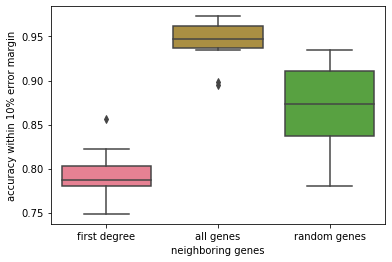

In [63]:
acc_df = pd.DataFrame.from_dict({'first degree': firstdeg_test[3], 
                                 'all genes': fc_test[3],
                                 'random genes': random_test[3]})

acc_df= acc_df.melt()
acc_df.columns = ["neighboring genes", "accuracy within 10% error margin"]
sns.set_palette("husl")
sns.boxplot(x="neighboring genes", y="accuracy within 10% error margin", data=acc_df)

### Visualizing Prediction for Test Data (First Degree Neighbor Genes)

In [64]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [65]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

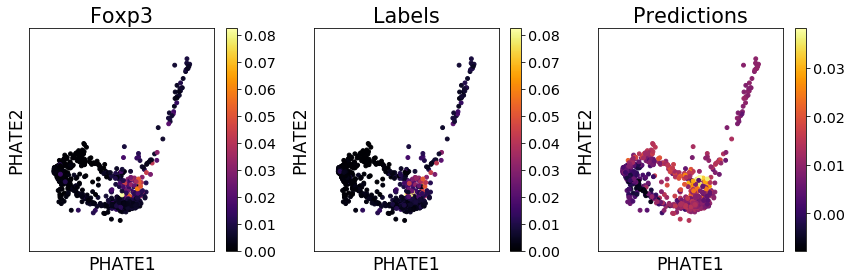

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (All Genes)

In [67]:
fc_test[0]['prediction'] = fc_test[1]
fc_test[0]['label'] = fc_test[2]
fc_test[0].sort_index(inplace=True)

In [68]:
test_mask = data_magic_filt.index.isin(fc_test[0].index)

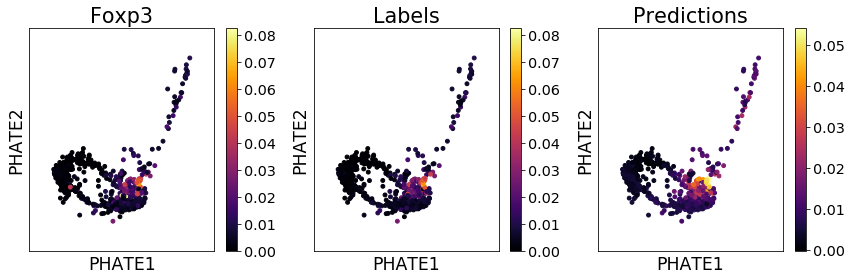

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=fc_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=fc_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (Random Genes)

In [70]:
random_test[0]['prediction'] = random_test[1]
random_test[0]['label'] = random_test[2]
random_test[0].sort_index(inplace=True)

In [71]:
test_mask = data_magic_filt.index.isin(random_test[0].index)

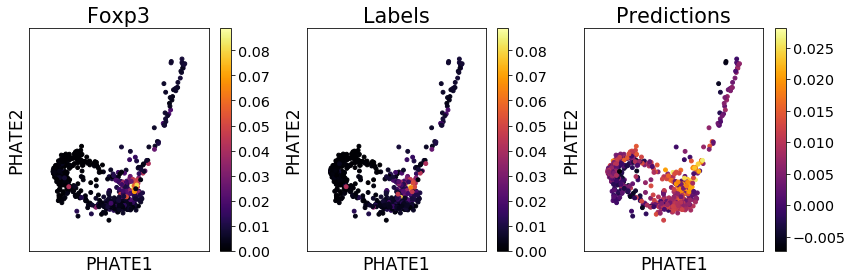

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=random_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=random_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()